Посмотрим на то, какую точность можно получить, используя разные подходы и библиотеки к снятию омонимии.

In [1]:
from russian_tagsets import converters
import conllu
import pymorphy2
import pymystem3

from tqdm.auto import tqdm

# Эта строчка, если поставить соответствующее расширение будет показывать, что ничего не зависло, а время тикает.
%load_ext autotime

У меня Universal Dependencies лежит здесь. Надо исправить путь к корпусу у себя.  
А вообще, скачивается [отсюда](https://universaldependencies.org/).

In [2]:
ud_path = "/home/edward/projects/Alien_bases/Universal Dependencies/ud-treebanks-v2.8/UD_Russian-SynTagRus/"

Прочитаем файл с синтаксически размеченным корпусом (часть train) при помощи специальной библиотеки `conllu`. Ее плюсом является тот факт, что она создает специальные структуры, с которыми удобнее работать. Из минусов, она оказывается несколько медленнее, чем решение с разбором вручную и хранением данных в списках. Но решение со списками гораздо менее читаемое, что мы увидим ниже.

In [3]:
data_file = open(ud_path+"ru_syntagrus-ud-train.conllu", "r", encoding="utf-8")
all_data = []
for tokenlist in conllu.parse_incr(data_file):
    all_data.append(tokenlist)

Это решение "вручную на списках".

In [4]:
def readSentence(lines, pos):
    ''' Возвращает предложение из списка строк lines, записанных в формате UD. 
        Предложение находится начиная со строки с номером pos.
    '''
    sent=[]
    while pos<len(lines) and lines[pos]!="\n":
        if lines[pos][0]!='\n' and lines[pos][0]!='#':
            sent.append(lines[pos][:-2].split("\t"))
        pos+=1
    pos+=1
    return sent, pos

In [5]:
with open(ud_path+"ru_syntagrus-ud-train.conllu") as infile:
    lines2=infile.readlines()
    
pos = 0
all_data2 = []
while pos<len(lines2):
    sent, pos=readSentence(lines2, pos)
    all_data2.append(sent)


Опробуем следующее решение. Возьмем pymorphy, при анализе он выдает список вариантов разбора, упорядоченных по убыванию частоты встречаемости в OpenCorpora. Фактически, это будет снятием омонимии по частоте униграммы.  
Но у pymorphy и Universal Dependencies разные форматы представления части речи и грамматических тегов. Для конвертации используем библиотеку `russian_tagsets`.

In [6]:
# Позиция в файле
pos=0
# Количество слов для расчета доли правильных ответов.
simwords=0
allwords=0
simpos=0
allpos=0
simnoun=0
allnoun=0

tag_conv = converters.converter('opencorpora-int', 'ud20')
morph = pymorphy2.MorphAnalyzer()

# Пока не закончились предложения.
while pos < len(lines2):
    # Читаем очетердное предложение.
    sent, pos = readSentence(lines2, pos)
    for w in sent:
        r = morph.parse(w[1]) # Морфологический анализ слова.
        if r[0].normal_form == w[2].lower(): # Совпадает ли начальная форма.
            simwords += 1
            
        tags = tag_conv(str(r[0].tag))
        pos_tag = tags.split(' ')[0]
        tags = tags.split(' ')[1]
        if w[3] == pos_tag: # Совпадает ли часть речи.
            simpos += 1
            if r[0].tag.POS == 'NOUN': # Если совпадает, для существительных посчитаем совпадение тегов.
                if tags == w[5]:
                    simnoun += 1
                allnoun += 1
        allpos += 1
        allwords += 1
    print(f"{pos}/{len(lines2)}", end='\r') # Промежуточный вывод, раз мы не испольуем tqdm.
    
print('precision ini form =', simwords/allwords)
print('precision PoS      =', simpos  /allpos)
print('precision noun tags=', simnoun /allnoun)

precision ini form = 0.938834871248821
precision PoS      = 0.887064757677912
precision noun tags= 0.792758056177839


Прежде чем пробовать MyStem, посмотрим, сравнимы ли у него результаты с UD. По дороге мы выясняем, что разделение на токены у них существенно отличается, но отличия частично сглаживаются, если в UD пропускать знаки препинания и числительные. Но отличия все равно остаются, особенно в словах со знаками препинания внутри. Ниже приведено очень показательное предложение, в котором отличия сперва появляются, а потом исчезают.

In [7]:
mystem = pymystem3.Mystem()


In [30]:
sent, pos = readSentence(lines2, 173920)
sent2 = ' '.join([w[1] for w in sent])

#sent2 = 'Зато в Маньчжурии китайские войска разбежались без сопротивления, и 1 мая 1932 года Япония объявила об образовании "независимого" государства Маньчжоу-Го во главе с президентом Пу И - бывшим китайским императором, целиком подконтрольным японцам.'
res = mystem.analyze(sent2)

pos2 = 0
for w2 in res:
    if 'analysis' in w2 and w2['analysis'] != []:
        print(w2['analysis'][0]['lex'], sent[pos2][2])
        pos2 += 1
        while pos2 < len(sent) and sent[pos2][3] in ['PUNCT', 'NUM']:
            pos2 += 1
    

зато зато
в в
маньчжурия Маньчжурия
китайский китайский
войско войска
разбегаться разбежаться
без без
сопротивление сопротивление
и и
май май
год год
япония Япония
объявлять объявить
об о
образование образование
независимый независимый
государство государство
маньчжоу Маньчжоу-Го
го во
во глава
глава с
с президент
президент Пу
и И
бывший бывший
китайский китайский
император император
целиком целиком
подконтрольный подконтрольный
японец японец


In [25]:
# Для MyStem придется конвертировать части речи вручную. Возьмем не все.
PoS_mystem ={'ADJ': 'ADJ', 'S': 'NOUN', 'V': 'VERB', 'PR': 'ADP', 'ADV': 'ADV'}

pos=0
simwords=0
allwords=0
simpos=0
allpos=0
# simnoun=0 
# allnoun=0

mystem = pymystem3.Mystem()

while pos < len(lines2):
    sent, pos = readSentence(lines2, pos)
    sent2 = ' '.join([w[1] for w in sent])
    
    sent_st = mystem.analyze(sent2) # Отправляем предложение на анализ.
    
    pos2 = 0
    for w in sent_st:
        if 'analysis' in w and w['analysis'] != []:
            while pos2 < len(sent) and sent[pos2][3] in ['PUNCT', 'NUM']:
                pos2 += 1 # Пропускаем знаки препинания и числительные.
            if pos2 >= len(sent):
                continue
                
            if w['analysis'][0]['lex'] == sent[pos2][2].lower():
                simwords += 1
            else:
                print(w['analysis'][0]['lex'], sent[pos2][2].lower())
            
            pos_tag = w['analysis'][0]['gr'].split('=')[0].split(',')[0]
            if pos_tag in PoS_mystem:
                if PoS_mystem[pos_tag] == sent[pos2][3]:
                    simpos += 1
                allpos += 1
            # Грамматические параметры сравнивать не будем, с ними возни больше.
            allwords += 1
            pos2 += 1
            while pos2 < len(sent) and sent[pos2][3] in ['PUNCT', 'NUM']:
                pos2 += 1 # Пропускаем знаки препинания и числительные.
                
    print(f"{pos}/{len(lines2)}", end='\r')
    
print('precision ini form =', simwords/allwords)
print('precision PoS      =', simpos  /allpos)
# print('precision noun tags=', simnoun /allnoun)

его он7968
решать решить
желающий желать
обставлять обставить
пишущий писать
два кожаный
кожаный кресло
накрывать накрыть
оба сторона
сторона аккуратно
аккуратно заставить
заставлять стул
отодвигать отодвинуть
десять час8
час раздаться
раздаваться короткий
короткий звонок
скрываться скрыться
проговаривать проговорить
ефимов ефимова
проходить пройти
забывать забыть
закрывать закрыть
оба обить
обивать черный
черный клеенка
клеенка дверь
склонять склонить
подымать поднимать
садиться сесть
посмотреть смотреть
ефимов ефимова
начинать начать
приготавливать приготовить
отредактировать редактировать
взять брать
предлагать предложить
приходить прийти
взглядывать взглянуть
садиться сесть
отзываться отозваться
трудно трудный
переключать переключить
попадать попасть
приходить прийти
предлагаться предлагать
наказывать наказать
докладывать доложить
об о
это этот968
проходить пройти
написать писать
выводить вывести
секретно секретный
написать писать
три причина
причина во-первых
во-первых заявка
заяв

стягивать стянуть
прижимать прижать
упирать упереть
наклонять наклонить
подшивать подшить
оказываться оказаться
оказываться оказаться
услуживать услужить
замечать заметить
прикуривать прикурить
доставать достать
высекать высечь
раздувать раздуть
подносить поднести
сильно сильный
прикуривать прикурить
погасить гасить
доставать достать
высекать высечь
помахать махать
бросать бросить
появляться появиться
ударять ударить
втаптывать втоптать
приминать примять
раскидывать раскинуть
находить найти
вымокать вымокнуть
его он017968
уходить уйти
бросать бросить
б бы/1017968
ты _
такой ты
храбрый такой
оба и1017968
и солдат
солдат и
и тракторист
тракторист слышать
услышать близкий
близкий автоматный
автоматный очередь
подниматься подняться
во в
понимать понять
исчезать исчезнуть
низкий низко
облеплять облепить
он оно
со с
охрипнуть хрипнуть
повертываться поворачиваться
облеплять облепить
оскаливать оскалить
растрескиваться растрескаться
пошло идти68
пошло идти68
пойти идти68
жарко жаркий
развязыва

вспыхивать вспыхнуть
загораться загореться
умирать умереть
поджигать поджечь
все весь17968
некоторые некоторый
хорошо хороший
сорвать срыть
собирать собрать
давать дать68
несколько человек
человек понять
понимать изменить
изменять направление
направление кидаться
кинуться к
к овраг
вскакивать вскочить
лающий лаять
светящийся светиться
подымать поднять
заливать залить
обступать обступить
проваливаться провалиться
блестящий блестеть
исступленный исступленно
останавливать остановить
должный должен
далеко дальше
сбиваться сбиться
освещать осветить
появляться появиться
несколько человек
человек присесть
приседать под
под пуля
пуля беспокойно
беспокойно озираться
бросать бросить
заваливаться завалиться
отбивать отбить
открывать открыть
успевать успеть
бросать бросить
выхватывать выхватить
ко к2/1017968
пушок пушка
понимать понять
кинуть кидать
весь все
бросаться броситься
попадать попасть
ударять ударить
два взрыв
вскакивать вскочить
освещать осветить
со с
вытягивать вытянуть
достигать дости

состоять %968
из состоять
вода из
упаковывать вода
отнюдь упаковать
не отнюдь
в не
древесный в
картон древесный
а картон
в а
съедобный в
кожура съедобный
достаточно кожура
аппетитный достаточно
чтобы аппетитный
привлекать чтобы
животное привлечь
который животное
съедать который
фрукт съедать
и фрукт
распространять и
зерно распространять
эйфелевый эйфелев
поступать поступить
построить строить
считаться считать
один из
из самый
самый ранний
ранний очевидный
очевидный пример
пример использование
использование бионика
бионика в
в инженерия
основывать основать
задокументировать документировать
подводить carl
теоретический cullman
база подвести
под теоретический
открытие база
фон под
мейер открытие
а фон
спустя мейер
год а
природный спустя
распределение год
нагрузка природный
с распределение
помощь нагрузка
кривой с
суппорт помощь
быть кривой
использовать суппорт
эйфель быть
сделать делать
со с1/1017968
замечать заметить
уставать устать
решать решить
выяснивать выяснить
определять определить

спрашивать спросить
уставать устать
вставать встать
потянуться потягиваться
соглашаться согласиться
подкладывать подложить
один лечь7968
ложиться можно
можно _
опускать опустить
удивляться _8
он удивиться
и он
сразу и
вспомнить сразу
весь вспомянуть
ее весь
сегодняшний ее
грустно сегодняшний
отчужденный грустный
вид отчужденный
а вид
вспомнить а
озлобляться вспомянуть
и озлобиться
сердце и
у сердце
он у
больно он
застучать больно
понимать понять
чем что
нужно нужный8
сделать делать
нужно нужный
становиться стать
нужно нужный
это этот17968
счастие счастье
ж же5/1017968
переводить перевести
взглядывать взглянуть
ложиться лечь
накрываться накрыться
становиться стать
переходить перейти
садиться сесть
закуривать закурить
потушить тушить
ложиться лечь
горько горький
становиться стать
со с1/1017968
счастие счастье
услышать слышать
привставать привстать
посмотреть смотреть
светло светлый
заливать залить
весь все
становиться стать
тяжело тяжелый
несчастливо несчастливый
проходить пройти
станови

посвящать посвятить
помешать помешанный
два задаваться
задаваться вопрос
вопрос какой
какой черт
черт я
я здесь
здесь а
а не
не там
там где
где я
я ждать
ждать и
и где
где я
я сам
сам гораздо
гораздо интересный
перекрашивать перекрошить
значит значить
лишенный лишить
скоро скорее8
самый сам
спешивать спешить
во в2/1017968
многий случай
случай нет
нет необходимость
необходимость прибегать
прибегать к
к сильнодействующий
сильнодействующий химический
химический вещество
вещество ведь
ведь в
в буквальный
буквальный смысл
смысл у
у мы
мы под
под нога
нога расти
расти лекарство
лекарство создать
создавать природа
один процент8
процент житель
житель планета
много человек
человек страдать
страдать от
от побочный
побочный эффект
эффект который
который снижать
снижать качество
качество жизнь
жизнь и
и инициировать
инициировать патологический
патологический процесс
мало побочный
побочный эффект
разрешать разрешить
уточнять уточнить
проводить провести
достаточно достаточный
взглядывать взглянуть
л

находить найти
выпускать toto
модель выпустить
который модель
с который
помощь с
компьютер помощь
производить компьютер
мгновенный производить
анализ мгновенный
моча анализ
и моча
выдавать и
информация выдавать
о информация
состояние о
здоровье состояние
пользователь здоровье
не пользователь
отходить не
от отходить
касса от
выпускаться выпускать
стоять стоить
несколько тысяча
тысяча доллар
доллар ведь
ведь дорогой
дорогой унитаз
унитаз это
это не
не только
только качество
качество но
но и
и авторский
авторский дизайн
предлагать villeroy
экземпляр and
в boch
форма предлагать
слон экземпляр
сидеть в
предлагаться форма
на слон
спина сидеть
животное предлагать
филипп филиппе
старка старк
цветок цветы8
крепиться крепить
кг килограмм
один новинка8
новинка шведский
шведский унитаз
унитаз с
с сенсорный
сенсорный система
система бесконтактный
бесконтактный слив
слива достаточный
достаточно провести
проводить над
над она
она рука
рука и
и электроника
электроника слить
сливать в
в чаша
чаша литр


известно известный
он оно
высекать высечь
сделать делать
взяться браться
ко к3/1017968
весь все
прочее прочий
включать включить
ничего ничто8
удивлять удивить
вникать вникнуть
тринадцать год
год независимость
независимость так
так ничто
ничто и
и не
не заполнить
заполнять идеологический
идеологический ниша
закладывать заложить
трудно трудный
приводить привести
повторяться повториться
ясно ясный
приобретать приобрести
перегружать перегрузить
приписываться приписывать
собирать собрать
переселять переселить
становиться стать
занятый занять
нету нет17968
гавно говно
ее она
понятно понятный
рассказывать рассказать
рассказываться рассказывать
хорошо хороший
х 80-й1017968
доставать достать
десять спустя
относиться отнестись
оказывать оказать
соглашаться согласиться
поселяться поселиться
пять раз17968
раз в
в день
день протирать
протирать он
он сначала
сначала влажный
влажный потом
потом сухой
сухой тряпочка
тряпочка а
а главное
главное беззаветно
беззаветный он
они любоваться
поугас поугаснут

летний 100-летний
ее она1017968
настраивать настроить
заставлять заставить
устанавливать установить
оказываться оказаться
низко низкий
приносить принести
весь все17968
объявлять объявить
вводить ввести
оставаться остаться
настраивать настроить
ханс ханс-лотар
лотар мертен
мертный автор
автор книга
книга бестселлер
бестселлер налоговый
налоговый оазис
продолжаться продолжиться
принимать принять
отражаться отразиться
изменяться измениться
не _
в не
польза в
владелец польза
вилла владелец
поскольку вилла
сделка поскольку
по сделка
купля по
продажа купля
пусть продажа
формально пусть
но формально
проходить но
через проходить
испанский через
банк испанский
святой свято8
взять брать68
считаться считать
получать получить
много более68
рассматриваться рассматривать
получать получить
отказывать отказать
скоро скорее8
потерять терять
ассоциированный ассоциировать
приходиться прийтись
постигать постичь
с _
нидерланды с
заявлять заявить
провозглашать провозгласить
ассоциированный ассоциировать
дог

погружать погрузить
должный должен
один важный68
важный момент
момент посадочный
посадочный маячок
маячок по
по который
который самолет
самолет заходить
заходить на
на посадка
должный должен
смочь мочь968
обеспечивать обеспечить
все весь17968
просчитывать просчитать
мореграда мореград
многий ученый
ученый понять
понимать что
что в
в отличие
отличие от
от квадратный
один метр
квадратный поверхность
метр земля
поверхность квадратный
земля метр
один море
квадратный не
метр стоить
море ровный
не счет
стоить ничто
никкей никкеи
сейккей сейккеи
предлагать предложить
мореграда мореград
предусматривать предусмотреть
приживаться прижиться
предлагать предложить
построить строить
обозначать обозначить
представлять представить
построить строить
открывать открыть
созревать созреть
один момент68
момент в
в польза
польза такой
такой сооружение
проходить пройти
со с9/1017968
близкий ближайший
связывать связать
один государство
государство строить
построить плавучий
плавучий объект
объект не
не под
под

позволять позволить
выявлять выявить
разрабатываться разрабатывать
создаваться создавать
многий вопрос
вопрос должен
должный дать
давать наземный
наземный экспедиция
ознакомляться ознакомиться
выявлять выявить
включаться включать
порождать породить
четыре раз
нарушать нарушить
изменять изменить
связанный связать
выяснивать выяснить
производить произвести
прочностный прочностной
нарушать нарушить
прочностный прочностной
судя судить68
трудно трудный
узнавать узнать
провожать проводить
считаться считать
решать решить
примыкать примкнуть
подбираться подобраться
шесть час7968
час езда
езда без
без учет
учет очередь
очередь на
на паром
пар дорожник
дорожник единственный
единственный вид
вид сообщение
сообщение между
между остров
остров и
и большой
большой земля
воскресение воскресенье
уже _
в уже
обратный в
сторона обратный
уважительный _
по уважительно
имя по
семьдесят километр
километр вытянуться
вытягиваться вдоль
вдоль его
его западный
западный часть
большой больший
облюбовывать облюбова

становиться стать
три с
с половина
половина раз
раз и
и приобрести
приобретать звездный
звездный величина
величина это
это почти
почти как
как у
у венера
венера в
в период
период самый
самый интенсивный
интенсивный блеск
во в5/1017968
отмечать отметить
сохраняться сохраниться
извлекать извлечь
расширять расширить
километр _968
для километр
сравнение для
земной сравнение
большой земной
каньон большой
в каньон
аризона в
иметь аризона
длина иметь
километр длина
ширина километр
до ширина
километр до
и километр
глубина и
километр глубина
возникать возникнуть
несколько миллиард
миллиард год
год назад
назад когда
когда планета
планета остывать
обнаруживать обнаружить
изучать изучить
открывать открыть
сделать делать
заявлять заявить
обнаруживать обнаружить
нас наса17968
проводить провести
показывать показать
нас наса17968
засекречивать засекретить
подтверждать подтвердить
сделать делать
великий большой
воспринимать воспринять
создавать создать
становиться стать
удаваться удаться
высказываться 

заглядывать заглянуть
подрываться подрывать
рассчитать расчесть
включаться включать
устанавливать установить
проходить пройти
отражаться отразиться
наноситься наносить
два небольшой
небольшой слепой
слепой пятно
пятно из
один который
из приходиться
который как
приходиться раз
как на
раз медведицкий
на гряда
один из017968
из вход
вход в
в тоннель
тоннель однако
однако этот
этот дело
дело оказаться
оказываться безнадежный
грунтовый грунтовой
решать решить
прекращать прекратить
прогуливаться прогуляться
сталкиваться столкнуться
давать дать68
дистиллированный дистиллировать
то тот1017968
один странность
странность благодаря
благодаря который
который о
об этот
этот тоннель
тоннель заговорить
заговаривать в
в академия
академия наука
полметра полуметр
два метр
метр как
как маршрутный
маршрутный такси
такси практически
практически каждый
каждый день
день летать
летать шаровой
шаровой молния
обнаруживать обнаружить
остекловать остекловывать
обжигать обжечь
больше все968
все сомнение
сомнение у


ограничивать ограничить
предназначать предназначить
сапиенс хомо
а сапиенс
для а
теленок для
простата _968
у простата
мужчина у
заменять заменить
относить отнести
очищать очистить
очищать очистить
выводить вывести
пристраивать пристроить
сложно сложный
отказываться отказаться
полезно полезный
многий исследование
исследование показывать
показывать польза
польза умеренный
умеренный потребление
потребление алкоголь
алкоголь в
в любой
любой форма
форма вино
вино пиво
пиво или
или крепкий
крепкий напиток
напиток для
для сердце
сердце и
и сосуд
сто67/1017968 тысяча
тысяча американец
американец выбрать
выбирать человек
человек питание
питание который
который быть
быть наиболее
наиболее близкий
близко к
к новый
новый идея
идея диетолог
оказываться оказаться
на _
понижаться понизиться
два год017968
год количество
количество эмитировать
эмитировать в
в россия
россия пластиковый
пластиковый карта
карта увеличиться
увеличиваться примерно
примерно в
в раз
проводить провести
наличный наличные
один и

несколько пример
пример когда
когда свободный
свободный доступ
доступ к
к услуга
услуга являться
являться оправданный
вызывать вызвать
известно известный
один из
из наиболее
наиболее действенный
действенный рычаг
рычаг реклама
реклама являться
являться совет
совет друг
друг и
и знакомый
необходимо необходимый
предоставлять предоставить
занятый занять
много большой
оставлять оставить
открытый открыть
отказываться отказаться
обреченный обречь
может мочь968
суметь уметь
обеспечивать обеспечить
нагонять нагнать
позиционироваться позиционировать
привлекать привлечь
рассматриваться рассматривать
целесообразно целесообразный
ориентированный ориентировать
нацеливать нацелить
умирать умереть
выдавливать выдавить
привлекать привлечь
лишать лишить
дот дот-ком68
хороший лучший
должный должен
тот то1017968
дот дот-ком68
комов не
не являться
являться сигнал
сигнал к
к то
то что
что поставщик
поставщик бесплатный
бесплатный услуга
услуга финансировать
финансироваться исключительно
исключительно за
за

хорошо хороший
проясниваться проясниться
заинтересовывать заинтересованный
банка банк
зарабатывать заработать
обесценивать обесценить
проводиться проводить
пониматься понимать
обертываться обернуться
становиться стать
неуютно неуютный
по по-серому
по по-белому8
белый культурно
культурно прилично
сделать делать
нелегко нелегкий
съедать съесть
съедать съесть
ж же
давать дать
закрывать закрытый
вальцев вальцева
потерять терять
перепутывать перепутать
оказываться оказаться
многий из
из сверстник
сверстник с
с кто
кто лариса
лариса васильевна
васильевна кончать
кончать школа
школа погибнуть
погибать погибнуть
погибать и
и миша
миша неустроев
неустрой который
который она
она любить
изменяться измениться
уезжать уехать
оставаться остаться
перемещаться переместиться
понимать понять
успевать успеть
выходить выйти
вырастать вырасти
вырастать вырасти
ускорять ускорить
смешать смесить
вальцевой вальцева
тридцать и
и в
в ее
ее жизнь
жизнь все
все так
так смутный
смутно так
так неустроенный
неустрое

два год017968
год и
и ориентировать
ориентировать на
на практический
практический спасение
спасение усадьба
усадьба в
в современный
современный условие
спасать спасти
удаваться удаться
давать дать68
хороший лучший
архангельский архангельское
закрывать закрытый
восстанавливать восстановить
поступать поступить
соединять соединить
четыре сторона
сторона государство
государство общество
общество который
который небезразличный
небезразличный к
к культурный
культурный наследие
наследие памятник
памятник сам
сам по
по себя
себя и
и человек
человек который
который мочь
мочь вложить
вкладывать в
в они
они свой
свой средства
средство говорить
говорить алявдин
коралловый кораллово
дом _/1017968
творчество дом
потом творчество
ансамбль потом
приходить ансамбль
в прийти
упадок в
появляться появиться
взять брать68
приводить привести
ограничивать ограничить
коралловый кораллово
переходить перейти
должный должен
посвящать посвятить
середниковый середниково
обидно обидный
связанный связать
изменяться и

про _/1017968
дилер про
вот дилер
собственник вот
бизнес собственник
все бизнес
известный все
разочаровывать разочаровать
один собственник
собственник крупный
крупный торговый
торговый бизнес
бизнес стучать
стучать по
по стол
стол и
и пытаться
пытаться доказать
доказывать правильность
правильность его
его сведение
сведение по
по импорт
оказываться оказаться
неправый неправ
вызывать вызвать
два и
и выражаться
выражаться в
в нежелание
нежелание платить
платить высокий
высокий цена
цена за
за информация
собирать собрать
приглашать пригласить
называть назвать
ее она1017968
попробовать пробовать
осуществлять осуществить
появляться появиться
без _/1017968
он без
должный должен
вставать встать
необходимо необходимый
год _/1017968
и год
более и
представляться представлять
запрещать запретить
основывать основать
кардинальный кардинально
раскрывать раскрыть
основывать основать
применяться применять
собранный собрать
необходимо необходимый
проводить провести
необходимо необходимый
сформировывать 

рассматриваться рассматривать
создаваемый создавать
зеркально зеркальный
становиться стать
создавать создать
разрабатывать разработать
продемонстрировать демонстрировать
один из017968
из область
область разработка
разработка приложение
приложение который
который естественный
естественный образ
образ способствовать
способствовать развитие
развитие такой
такой область
область робототехника
робототехника как
как искусственный
искусственный зрение
зрение и
и навигация
навигация на
на открытый
открытый воздух
воздух в
в неструктурированный
неструктурированный окружение
окружение распределить
распределять ии
ия и
и интеллектуальный
интеллектуальный управление
предназначать предназначить
вестись вести
позволять позволить
получать получить
апробироваться cmvision
на апробировать
команда на
робот команда
который робот
университет который
готовить университет
для готовить
участие для
в участие
в cmvision968
действие в
нацеливать нацелить
планироваться планировать
смочь мочь
поставлять ставить
ре

проходить пройти
плохой худший
уходить уйти8
поминать помянуть
задерживаться задержаться
украшать украсить
ореховый орехово-борисово
помирать помереть
решаться решиться
обращаться обратиться
ли _
увековечивать увековечить
тов товарищ68
хо-хо хо-хо-хо
сочинять сочинить
выстреливать выстрелять
открывать открыть
называть назвать
открывать открыть
перечислять перечислить
весь все
называть назвать
усыновлять усыновить
призадумываться призадуматься
разыскивать разыскать
его он
обмирать обмереть
счастие счастье
разбивать разбить
порывать рвать
подтяжка подтяжки
отмутузить мутузить
приседать присесть
со с
обниматься обняться
пополам _
естественно естественный
скажем сказать
замирать замереть
весь все
крутой круто
отрываться отрыться
кхе кхе-ррр-кхм
кху кху-кху-кху
крепенький крепенько
размножаться размножиться
разбегаться разбежаться
во в
светить светило
погасать гаснуть
обледеневать обледенеть
неисповедовать неисповеданный
стираться стереться
пропадать пропасть
высекать высечь
вбивать вбить
у

засорять засорить
кончаться кончиться
искривлять искривить
проблема _968
она проблема
сказать она
это сказать
за это
предел за
ее предел
компетенция ее
но компетенция
вот но
сейчас вот
в сейчас
москва в
с москва
визит с
какой-то визит
совершенно какой-то
замечательный совершенно
гуру замечательный
имя гуру
не имя
произносить не
панфутий произнести
допускать панфутий
эмпамидонович допустить
он эмпамидонович
излечивать он
веровать излечивать
в верующий
он в
плевок он
многий уже968
уже убедить
убеждать что
что оно
он нет
нет даже
даже один
один врачиха
врачиха из
из ведомственный
ведомственный поликлиника
поликлиника большой
большой он
его поклонница
поклонница совершенно
совершенно убежденный
убеждать что
что в
в сущность
сущность он
он прав
право никакой
никакой кровообращение
кровообращение нет
нет учить
учить панфутий
панфутий а
а _
застаиваться застояться
чертовый чертов
высыхать высохнуть
упасть падать
попросить просить
подсоблять подсобить
попросить просить
легко легкий
два неделя9

посылать послать
назначать назначить
совершенный совершить
засылаться засылать
создавать создать
больше спам
спам фильтр
распространяться распространять
самоустановиться самоустанавливаться
активироваться активировать
два конец7968
д д.6/1017968
к к.
манай матаи
оставаться остаться
приоткрытый приоткрыть
во в3/1017968
приходиться прийтись
провожать проводить
приходиться прийтись
рассматривать рассмотреть
изощрять изощрить
совершаться совершать
возрождать возродить
хороший лучший
изменяться измениться
протягивать протянуть
становиться стать
давать иридиум
повод дать
для повод
создание для
многий создание
с иридиум7968
кирпич с
они кирпич
быть они
такой быть
же такой
тяжелый же
и тяжелый
неэффективный и
для неэффективный
пользователь для
который пользователь
даже который
не даже
иметь не
возможность иметь
позвонить возможность
находиться звонить
внутри находиться
помещение внутри
выясняться выясниться
спасать иридиум
военный спасти
сша военный
инвестиция иридиум
в инвестиция
создание в
к

краденый краденое
устанавливать установить
они их
находить найти
заканчиваться закончиться
проверять проверить
решать решить
отправляться отправиться
куватать куватал
км километр68
добираться добраться
пробиваться пробиться
находить найти
куватать куватал
поговорить говорить
со с
понимать понять
удаваться удаться
определять определить
сверяться свериться
со с
понимать понять
находить найти
азяш азяш-уфимский
уфимский железоделательный
железоделательный и
и чугуноплавильный
чугуноплавильный завод
находить найти
растворяться раствориться
находить найти
азяш азяш-уфимский
уфимский завод
завод окончательно
окончательно рассеяться
рассеиваться после
после то
то как
как ученый
ученый сопоставить
сопоставлять рельеф
рельеф местность
местность с
с архивный
архивный карта
убеждаться убедиться
выбирать выбрать
приступать приступить
азяш азяш-уфимский
уфимский завод
завод в
в то
то что
что это
это единственный
единственный демидовский
демидовский предприятие
предприятие остатки
остаток который
ко

несколько сотня
сотня миллион
миллион год
год марс
марс по
по какой-то
какой-то причина
причина превратиться
превращаться из
из теплый
теплый и
и влажный
влажный в
в сухой
сухой и
и холодный
вызывать вызвать
повторяться повториться
построить строить
сконструировать конструировать
оказываться оказаться
построить строить
тепло теплый8
появляться появиться
появляться появиться
показывать показать
позволять позволить
проверять проверить
поставлять ставить
об о
во в
удаваться удаться
находить найти
он _
являться он
единственный являться
планета единственный
в планета
солнечный в
система солнечный
не система
считать не
земля считать
на земля
поверхность на
который поверхность
человек который
мочь человек
находиться мочь
без находиться
сверхсложный без
система сверхсложный
жизнеобеспечение система
становиться стать
уверять уверенный
приходить прийти
свыкаться свыкнуться
тепло теплый
со с1/1017968
намечать наметить
проанализировать анализировать
выявлять выявить
неоднородно неоднородный
соотве

со весь
все вытекать
вытекать из
из это
это последствие
естественный естественно
узнавать узнать
многий заключенный
заключенная обычно
обычно делать
делать характерно
характерный оловянный
оловянный глаз
глаз и
и говорить
говорить что
что в
в их
их страна
страна такой
такой не
не бывать
некоторые некоторый
отмечать отметить
поручать поручить
один офицер968
офицер специально
специально заниматься
заниматься борьба
борьба с
с травля
травля быть
быть у
у они
они там
там такой
такой пост
пост признать
признавать что
что уголовный
уголовный авторитет
авторитет устанавливать
устанавливать свой
свой правило
правило и
и разбираться
разбираться с
с непослушный
непослушный с
с помощь
помощь другой
другой заключенный
заключенный сам
сам при
при это
это оставаться
оставаться в
в тень
серьезно серьезный
тот то/1017968
находить найти
этот это
два в5/1017968
в день
день на
на завтрак
завтрак заключенный
заключенный получать
получать или
или что-нибудь
что-нибудь вроде
вроде хлопья
хлопья или
или немн

попадать попасть
непросто непростой
во в59/1017968
открывать открыть
два равно17968
равно важный
важный задача
задача помочь
помогать писатель
писатель быть
быть прочесть
прочитывать и
и открывать
открывать новый
новый имя
шорты шорт-лист
лист конкурс
конкурс на
на лучший
хороший рассказ
рассказ год
год имя
имя юрий
юрий казаков
казаков я
я прочесть
прочитывать очень
очень интересный
интересный и
и очень
очень еще
еще молодой
молодой прозаик
прозаик иван
иван плужников
плужников из
из екатеринбург
шорты шортлист
лист конкурс
конкурс имя
имя белкин
белкин на
на лучший
хороший повесть
повесть год
год оказаться
оказываться на
на мой
мой взгляд
взгляд замечательный
замечательный повесть
повесть встречный
встречный движение
движение юрий
юрий горюхин
горюхин из
из уфа
потратить тратить
они их/1017968
оканчивать окончить
два фраза17968
три уже
фраза диалог
уже реплика
диалог уже
один характер
пять минута968
шесть дать
минута случиться
давать сюжет
случаться это
сюжет хороший
это школа
хороши

должный должен
появляться появиться
напоминать напомнить
должный должен
вносить внести
его оно1017968
задумываться задуматься
окружать окружить
начинать начать
суметь уметь
отвечать ответить
поставлять ставить
разрабатывать разработать
находить найти
пролагать проложить
х 30-й
зафиксировать фиксировать
смочь мочь7968
сфотографировать фотографировать
замечать заметить
обнаруживать обнаружить
называть назвать
получать получить
начинаться начаться
удаваться удаться
понимать понять
окружать окружить
продолжаться продолжать
разрабатывать разработать
смочь мочь7968
понимать понять
вовлекать вовлечь
это грв1017968
образно это
говорить образно
цифровой говорить
компьютерный цифровой
стадия компьютерный
эффект стадия
кирлиан эффект
создавать создать
подаваться подавать
располагать расположенный
связанный связать
со с
многий тысячелетие
тысячелетие использовать
использоваться традиционный
традиционный китайский
китайский медицина
медицина который
который брать
взять за
за основа
основа понятие
п

излагать изложить
объяснять объяснить
отказываться отказаться
храниться хранить
написать писать
хорошо хороший
прощать простить
естественно естественный
трудно трудный
сформулировать формулировать
десять заповедь
уходить уйти68
созревать созреть
должно должен8
уставать устать
устало устать
суметь уметь68
навещать навести
понимать понять
м 99-й
посчитать счесть
справляться справиться
продемонстрировать демонстрировать
обеспечивать обеспечить
вписывать вписать
правый прав968
становиться стать
уходить уйти68
попросить просить
оставаться остаться
оставаться остаться
некоторые некоторый
надолго _
кажется казаться
оправдывать оправдать
х 90-й/1017968
считаться считать
приходиться прийтись
порывать рвать
болезненно болезненный
посмотреть смотреть
три тот
тот кто
кто определять
определять в
в начало
начало 90-й
х экономический
экономический политика
политика россия
пожимать пожать
вспомнить вспомянуть
замешать замешанный
взять брать968
посмотреть смотреть
оказываться оказаться
попробовать проб

заявлять заявить
помогать помочь
сохраняться сохраниться
со с
один из1017968
из причина
причина недомогание
недомогание в
в этот
этот день
день мочь
мочь стать
становиться дефицит
дефицит кислород
кислород в
в воздух
воздух который
который негативно
негативно влиять
влиять на
на самочувствие
самочувствие человек
человек с
с кислородный
кислородный недостаточность
уменьшать уменьшить
рекомендоваться рекомендовать
помогать помочь
восполнять восполнить
многий метеочувствительный
метеочувствительный человек
человек мочь
мочь ощущать
ощущать недомогание
недомогание сильный
сильный слабость
слабость рассеянность
оказываться оказаться
вегетососудистый вегетативно-сосудистый
желательно желательный
эмоциональный эмоционально
российско российский
признавать признать
зарегистрировать регистрировать
установленный установить
удаваться удаться
опускаться опуститься
приходиться прийтись
два год
год таков
таков формальный
формальный требование
требование международный
международный союз
легко легкий68

мало малый7968
невозможно невозможный
измерять измерить
начинать начать
один замечание
соединять соединить
об о49/1017968
принимать принять
встречаться встречать
крыло крыть
устраивать устроить
договариваться договориться
приносить принести
один бумага
бумага с
с себя
должный должен
получать получить
показывать показать
голиков голикова
установленный установить
сообщать сообщить
первый первое8
исключать исключить
физико физический
иофф иоффе
установленный установить
его он
посылать послать
физико физический
иофф иоффе
принимать принять
наркомтяжмаш вснх
наркомсредмаш наркомтяжмаш
с наркомсредмаш
год с
в год
академия _
наука в
ссср академия
с наука
год ссср
в с
российский год
академия _
летие 85-летие
иофф иоффе7968
выходить выйти
прославлять прославить
многий многое8
выходить выйти
физико физический
иофф иоффе7968
создавать создать
два с4/1017968
с половина
половина тысяча
тысяча работать
работать в
в тот
тот число
число академик
академик и
и членкор
членкор доктор
доктор наука
наука к

процентный 12-процентный
умалчивать умолчать
подорожать дорожать
возрастать возрасти
относить отнести
начинаться начаться
во в78/1017968
сколько областной
областной центр
центр влететь
влетать мягкий
мягкий тарифный
тарифный политика
политика областной
областной руководство
энергоресурсы энергоресурс
упасть падать
закладывать заложить
нужно нужный
два раз
средство средства
закрывать закрыть
принимать принять
приходиться прийтись
средство средства
средство средства
повышенный повысить
предусматривать предусмотреть
гребец гребцов
понимать понять
направлять направить
расценок расценка
весь все017968
заявлять заявить
энергетика энергетик
сбивать сбить8
должный должен
чем что1017968
изымать изъять
поставлять ставить
давать дать968
заблокировать блокировать
заплатить платить
снимать снять8
завышать завысить
давать дать968
убеждаться убедиться
вспомнить вспомянуть
странно странный
начинаться начаться
сделать делать
потратить тратить
поставлять ставить
заставлять заставить
выплачивать выплатит

есна есн017968
предлагаться предлагать
уменьшать уменьшить
проц процент
есна есн017968
облагаться облагать
два год
год минимум
минимум возрасти
возрастать до
до тысяча
облагаться облагать
есна есн
проц процент
по _
ставка по
проц ставка
замечать заметить
облагаться облагать
процентный 20-процентный
есна есн
от _
до от
тысяча до
по тысяча
ставка _
проц по
свыше ставка
тысяча процент
рубль _
по свыше
ставка тысяча
проц рубль
предлагаться предлагать
отменять отменить
увеличивать увеличить
попадать попасть
оказываться оказаться
есна есн017968
ндс _
причем ндс
на причем
куда на
больший куда
величина больший
чем величина
проц чем
один из1017968
из самый
самый сильный
сильный думский
думский шахматист
шахматист жуков
жуков мочь
мочь бы
бы сказать
сказать что
что правительство
правительство перепутать
перепутывать порядок
порядок ход
есна есн017968
проц процент
проц процент68
приводить привести
снижать снизить
проц процент
начинать начало
просчитывать просчитать
об о69/1017968
трлн триллион8
п

финансирование сокращать
мероприятие расход
сокращать будущий
расход период
будущий в
период близкий
в перспектива
близкий не
перспектива планировать
действующий действовать
средство средства
накоплять накопить
позволять позволить
обеспечивать обеспечить
четыре месяц
месяц или
или на
на уровень
уровень доллар
доллар за
за баррель
баррель в
в течение
течение месяц
остаток остатки
средство средства
накоплять накопить
млрд миллиард
позволять позволить
действующий действовать
великобритания the
отражать отразить
завершать завершить
отменять отменить
три зарубежный
зарубежный поездка
поездка прилететь
прилетать на
на восток
восток россия
россия чтобы
чтобы нажать
нажимать символический
символический кнопка
кнопка пуск
пуск на
на единственный
единственный крупный
крупный электростанция
электростанция строить
построить в
в страна
страна за
за последний
последний год
устроенный устроить
должно должен8
пять год
год и
и служить
послужить пример
пример на
на следующий
следующий год
пять ожидать
г

появляться появиться
испечь испекать
это этот017968
исчезать исчезнуть
переменять переменить
впадать впасть
отказываться отказаться
последовать следовать
плохой плохо68
появляться появиться
взять брать968
обшаривать обшарить
давать дать
оказываться оказаться
кончаться кончиться
проходить пройти
приносить принести
вставать встать
весь все017968
решать решить8
приносить принести
придумывать придумать
исчезать исчезнуть
оставлять оставить
счастие счастье
вынимать вынуть
вынимать вынуть
потянуть тянуть
напиваться напиться
хорошо хороший
хорошо хороший
выпивать выпить
вынимать вынуть
хорошо хороший
помочиться мочиться
заглядывать заглянуть
закрывать закрыть
решать решить8
помочиться мочиться
вытаскивать вытащить
находить найти
упираться упереться
помочиться мочиться
вынимать вынуть
два раз1017968
раз лоб
лоб по
по кирпичный
кирпичный стена
стена чтобы
чтобы подтвердить
подтверждать свой
свой существование
пойти идти7968
заманивать заманить
отвечать ответить
высокий высший
приходиться прийти

исчезать исчезнуть
съеживаться съежиться
окружающий окружающие
убивать убить8
их они/1017968
смочь мочь7968
упасть падать8
оказываться оказаться
оглядеться оглянуться
понимать понять
попадать попасть
протягиваться протянуться
манхеттен манхэттен
четыре шестиэтажный
пять здание
разрушать разрушить
уходящий уходить
со с
посмотреть смотреть
один человек
человек и
и тишина
посмотреть смотреть
взглядывать взглянуть
увидеть видеть
решать решить8
неясно неясный
то тот/1017968
закоченеть закоченевать
переставать перестать
показываться показаться
относить отнести
привыкать привыкнуть
ко к
весь все
понимать понять
покрывать покрыть
скрывать скрыть
взять брать968
немой он
выбивать выбить
попадать попасть
притворяться притвориться
разбивать разбить
появляться появиться
большой больше
сдергивать сдернуть
упасть падать8
покрывать покрыть
об о57/1017968
попадаться попасться
три день017968
день назад
назад он
он встретить
встречать на
на второй
тридцать улица
второй толстяк
улица фантастический
толстя

ничего ничто68
услышать слышать
оборвать обрыть
становиться стать
поддерживать поддержать
наступать наступить
запевать запеть
взять брать968
запевать запеть
начинаться начаться
срываться сорваться
поцеловать целовать
поцеловать целовать
поцеловать целовать
получать получить
ж же77/1017968
огненный огненно
покраснеть краснеть
воплощаться воплотиться
страшно страшный
много больше68
начинаться начаться
его он
проживать прожить
экстрасенок экстрасенка
подпрыгивать подпрыгнуть
поверять поверить
она ее
плюхнуться плюхаться
опрокидывать опрокинуть
закусывать закусить
обнажать обнажить
становиться стать
он оно
оживать ожить8
чтоб чтобы7968
усиливать усилить
закрывать закрыть
помирать помереть
пять всего
проживать прожить
весь все017968
приходить прийти
весть ведать
ошалевать ошалеть
подбегать подбежать
подпрыгивать подпрыгнуть
разражаться разразиться
во в90/1017968
весь все
притихать притихнуть
ж же16/1017968
кончаться кончиться
ж же27/1017968
позволять позволить
заливаться залиться
убивать 01

добираться добраться
сделать делать
минутный 20-минутный
затрагивать 68затронуть
надавливать надавить
помогать помочь
посодействовать содействовать
надавливать надавить
получать получить
подмигивать подмигнуть
заказ _
наш заказ
фирма наш
оба сторона968
сторона в
в выигрыш
открывать открыто
добавлять добавить
проводиться фцп
через проводить
федеральный через
казначейство федеральный
узнавать узнать
странно странный
разочаровываться разочароваться
извещать известить
намечать наметить
проводить ввж
не проводить
становиться не
уклоняться уклониться
уделять уделить
нужно нужный68
построить строить
называть назвать
находить найти
оказываться оказаться
становиться стать
хороший лучший
решать решить8
кардинальный кардинально
не ввж/1017968
становиться не
бы стать
спешить бы
с спешить
ратификация с
договор ратификация
о договор
российский о
литовский российский
граница литовский
договариваться договориться
километровый 90-километровый
один из
из телекомпания
заполучать заполучить
отдавать отдат

растягиваться растянуться
согласовывать согласовать
продлиться длиться
сколько требоваться
потребоваться для
для восстановление
восстановление здоровье
здоровье после
после перенести
перенести болезнь
болезнь заявить
заявлять в
в аппарат
аппарат белый
белый дом
дом подчеркнуть
подчеркивать при
при это
это что
что речь
речь о
об отставка
отставка греф
греф не
не идти
становиться стать
известно известный
оглашать огласить
подвергать подвергнуть
премьера премьер
возлагать возложить
судя судить968
приходиться прийтись
получать получить
напоминать напомнить
поручать поручить
проводить провести
выявлять выявить
находить найти
хорошо хороший
отказываться отказаться
повторять повторить
проводить провести
ознакомляться ознакомиться
приходить прийти
приговаривать приговорить
устаревать устареть
понятно понятный
давать дать
представлять представить
ложиться лечь
создавать создать
отказываться отказаться
рано _
давать дать968
понимать понять
все всего17968
один управление
управление государственны

поставлять 968ставить
эффективный эффективно
мало нести7968
нести и
и воевать
воевать хорошо
хорошо хороший
экономичный экономично
вооруженный вооружить
много больше
изменяться измениться
много больше
наращиваться наращивать
средство средства
вооруженный вооружить
личный личной8
присоединяться присоединиться
во в95/1017968
накоплять накопить
го 2000-й17968
войско войска
должный должен
становиться стать
хороший лучший
повышать повысить
сделать делать
должный должен
становиться стать
нужно нужный68
войско войска
необходимо необходимый
возрождать возродить
один важный968
важный проблема
проблема сегодня
сегодня наш
наш армия
армия и
и флот
флот остро
остро нуждаться
нуждаться в
в современный
современный оружие
оружие и
и техника
весь все017968
много средства
один из1017968
из первоочередной
первоочередный задача
задача если
если не
не преодоление
преодоление технологический
технологический разрыв
разрыв между
между вооруженный
вооружать сила
сила сша
сша западный
западный европа
европа и


польский польско-германский
германский спорный
спорный вопрос
вопрос данцигский
данцигский коридор
коридор верхний
верхний силезия
силезия и
и так
т далее
во в82/1017968
униженный унизить
ограбить грабить
становиться стать
подписывать подписать
об о
получать получить
запрещать запретить
поставляться поставлять
высокий высший
войско войска
оттеснять оттеснить
для са/1017968
охрана для
партийный охрана
митинг партийный
а митинг
в а
март в
год март
более год
элитарный _
охранный более
отряд элитарный
и скф5/1017968
юнгштурм и
суметь уметь68
одерживать одержать
понимать понять
чем что
объясняться объяснять
учреждать учредить
воспользоваться пользоваться
в в.91/1017968
и и.
насчитывать насчитать
три источник
источник то
то у
у национал-социализм
национал-социализм они
они быть
быть значительно
значительно больше
все весь017968
фелькиш фелькише
разлагающий разлагать
заменять заменить
дополнять дополнить
надергать надернуть
со с13/1017968
во в
озлобленный озлобить
приходить прийти
т то
е быть

весь опасаться
опасаться союз
союз германия
германия с
с англия
англия и
и франция
франция нацист
нацист тоже
тоже быть
быть удобный
удобно чем
чем откровенно
откровенно прозападный
прозападный центрист
центрист и
и социал-демократ
входить войти8
двое член
член нсдап
нсдап это
это уже
уже не
не иметь
иметь значение
значение нацист
нацист не
не собираться
собираться играть
играть по
по старый
старый правило
обвинять обвинить
этот это
запрещать запретить
получать получить
допускать допустить
запрещать запретить
выходить выйти
а а.35/1017968
приходить прийти
урфо уфо
арестованный арестовывать
возбужденный возбудить
прекращать прекратить
направлять направить
урфо уфо017968
дата дата-крат
судно суд17968
приходиться прийтись
сталкиваться столкнуться
доверяться довериться
принимать принять
исполняться исполнять
личный личной8
счастие счастье
смочь мочь7968
устранять устранить
во в69/1017968
судно суд17968
припоминать припомнить
находить найти
становиться стать
его оно1017968
хороший лучший
хо

процесс их
их функционирование
функционирование на
на научный
научный основа
основа оптимизация
оптимизация функционирование
функционирование политический
политический социальный
социальный научный
научный образовательный
образовательный экономический
экономический оборонный
оборонный правоохранительный
правоохранительный антитеррористический
антитеррористический и
и другой
другой динамично
динамично действовать
действующий система
система в
в их
их единый
единый целенаправленность
целенаправленность к
к всеобщий
всеобщий благоденствие
благоденствие государство
государство общество
общество благосостояние
благосостояние каждый
каждый гражданин
два твердо7968
три нести
твердо свой
нести общественно
свой значимый
общественный национальный
значимый идея
национальный пользоваться
идея реальный
пользоваться популярность
реальный значительный
популярность часть
значительный население
попытаться пытаться
создавать создать
вводить ввести
вкладывать вложить
покупаться покупать
продаваться прода

руководящий руководить
все весь
свершаться свершиться
определять определить
сломать ломать
доставаться достаться
некоторые некоторый
забывать забыть
входить войти
удалять удалить
направлять направить
находить найти
растаптываться растаптывать
растрачиваться растрачивать
накоплять накопить
разрушаться разрушать
добывать добыть
обрезаться обрезать
забывать забыть
оказываться оказаться
создавать создать
расширять расширить
снижать снизить
порождать породить
создавать создать
становиться стать
бесконтрольно бесконтрольный
прожорливо прожорливый
он оно/1017968
об о14/1017968
во в
фашиствующий фашиствовать
предполагать предположить
приходить прийти
показываться казаться
останавливать остановить
наводить навести
известно известный
приходить прийти
много больше68
усиливать усилить
вносить 017968внести
пугающий пугать
отравлять отравить
год №8/1017968
в в.23/1017968
записывать записать
становиться стать
поступать поступить
они он/1017968
разрабатывать разработать
выявлять выявить
определять опр

вооруженный вооружить
пропечатывать пропечатать
широко широкий
называть назвать
утомлять утомить
обходиться обойтись
возводиться возводить
предусмотренный предусмотреть
его он/1017968
его он
сформировывать сформировать
расширять расширить
сосредоточиваться сосредоточиться
скажем сказать
во в13/1017968
принимать принять
об 586/1017968о
об о
оперативно оперативный
со с28/1017968
становиться стать
региональный регионально
ограничивать ограничить
скажем сказать
подавлять подавляющий
справляться справиться
подчинять подчинить
вырастать вырасти
три основный68
основной кит
кит фсб
фсб мвд
мвд и
и мо
мо не
не в
в состояние
состояние наладить
налаживать там
там реальный
реальный кооперация
кооперация каждый
каждый структура
структура действовать
действовать так
так как
как считать
считать нужный
нужный мало
мало заботиться
заботиться как
как о
об интерес
интерес коллега
коллега соперник
соперник так
так и
и собственно
собственно о
о дело
говориться говорить
об о
то тот/1017968
реализовывать реа

сделать делать
пропитывать пропитать
отгораживать отгородить
десять барьер
барьер частный
частный жизнь
таганок таганка
намекать намекнуть
забавно забавный
со с
он его/1017968
он его/1017968
кончаться кончиться
начинать начать
со с
потрясать потрясти
оказываться оказаться
случаться случиться
со с67/1017968
со с87/1017968
закладываться закладывать
дистиллированный дистиллировать
завоевывать завоевать
давать дать968
взять брать
подавать подать
этот это017968
усугублять усугубить
чудо _/1017968
принимать принятый
весы вес
принимать принятый
взяться браться
взяться браться
хрущев _017968
а хрущев
из а
маразматический из
брежневский маразматический
политбюро брежневский
горбить политбюро
удивление _
не горби
быть удивление
предел не
проживать прожить
счастие счастье
далеко дальше8
проходить пройти
понимать понять
прочитывать прочесть
пожалеть жалеть
обходиться обойтись
пересматривать пересмотреть
утверждаться утвердиться
оценивать оценить
успевать успеть
доводить довести
пожалеть жалеть
го 

вынуждать вынудить
все весь017968
неэффективно неэффективный
один из1017968
из важный
важный программа
программа это
это создание
создание индустрия
индустрия информационный
информационный система
система технопарк
технопарк опорный
опорный центр
должно должен8
ита ит/1017968
входить войти
один из
из приоритетный
приоритетный направление
направление в
в стратегия
стратегия развитие
развитие сибирь
со с00/1017968
накоплять накопить
ита ит
ита ит-технология
технология и
и они
их применение
применение в
в различный
различный область
область наука
наука и
и экономика
создаваемый создавать
ита ит
ита ит/1017968
поражать поразить
сделать делать
ита ит
известно известный
мозги мозг7968
ита ит/1017968
обеспечивать обеспечить
нужно нужный68
об о45/1017968
сделать делать
т так1/1017968
д далее
пять тысяча968
тысяча программист
близкий ближайший
нужно нужный
пять раз
раз тысяча
их они/1017968
должный должен
наступать наступить
хороший лучший
соглашаться согласиться
предоставлять предоставить
в 88

становиться стать
представлять представить
отрабатывать отработать
проинформировать информировать
е 30-й
сообщать сообщить
осуществлять осуществить
рассказывать рассказать
го 38-й
будущее будущий
планироваться планировать
произносить произнести
сделать делать
принимать принять
шестнадцать день
день спустя
спустя исторический
исторический речь
речь быть
быть произнести
скомпилировать компилировать
несколько часть
часть из
из первоначальный
первоначальный проект
проект представить
представлять февраль
февраль секретарь
секретарь цк
цк поспелов
поспелов и
и аристов
аристов из
из дополнение
дополнение на
на следующий
следующий день
день лично
лично диктовать
продиктовать хрущев
хрущев из
из вставка
вставка писать
написать затем
затем еще
еще один
один секретарь
секретарь цк
цк шепилов
шепилов из
из поправка
поправка внести
вносить в
в текст
текст член
член президиум
президиум цк
цк и
и наконец
наконец из
из импровизированный
импровизировать пассаж
пассаж хрущев
хрущев непосредственно
непос

упасть падать8
покидать покинуть
наносить нанести
хороший лучший
оказываться оказаться
многий академический
академический лаборатория
лаборатория и
и некоторый
некоторый вузовский
вузовский коллектив
коллектив сохранить
сохранять достаточный
достаточный количество
количество квалифицировать
квалифицировать кадр
кадр для
для продолжение
продолжение исследование
исследование хотя
хотя и
и здесь
здесь значительный
значительный часть
часть ученый
ученый особенно
особенно средний
средний возраст
возраст вынудить
вынуждать быть
быть уйти
уходить из
из наука
постареть стареть
пятнадцать год
стоять стоить8
необходимо необходимый
приобретать приобрести
несколько десяток
десяток экземпляр
экземпляр чтобы
чтобы оснастить
оснащать они
они центр
центр коллективный
коллективный пользование
средство средства
получать получить
построить строить
уменьшаться уменьшиться
много внимание
внимание стать
становиться уделять
уделять обработка
обработка получить
получать результат
результат различный
различный

совершать совершить
начинать начать
оказываться оказаться
во в87/1017968
заниматься заняться
чем что
получать получить
давать дать968
находить найти
во в
во в83/1017968
один из1017968
из немногие
немногие способ
способ вложение
вложение деньги
деньги который
который давать
давать и
и быстрый
быстрый отдача
отдача и
и надежность
надежность отмывание
ее она/1017968
легко легкий
памятно памятный
ворваться врыться
двести метр
метр от
от свежепостроенный
свежепостроенный для
для иностранный
иностранный инвестор
инвестор гостиница
гостиница и
и уложить
укладывать без
без разбор
разбор на
на пол
пол торжественно
торжественно вскрыть
вскрывать кассовый
кассовый аппарат
продемонстрировать демонстрировать
он его/1017968
ко к
весь все
устраивать устроить
один из
из воинский
воинский часть
часть с
с последующий
последующий совместный
совместный гимнастика
гимнастика тоже
тоже быть
быть счесть
счесть пиар
пиар но
но саакашвили
саакашвили получать
получать явный
явный удовольствие
удовольствие не
не

привыкать привыкнуть
важно важный68
доносить донести
много тема7968
то связать
связывать с
с наука
наука например
например возможный
возможный глобальный
глобальный потепление
потепление и
и его
его последствие
последствие проблема
проблема возникать
возникать в
в связь
связь с
с употребление
употребление генетически
генетически модифицировать
модифицированный продукт
продукт питание
питание и
и так
так далее
соглашаться согласиться
должный должен
чем что
начинать начать
должный должен
убеждать убежденный
и _692/1017968
телепрограмма и
о телепрограмма
наука о
издаваться наука
немало издавать
научно-популярный немало
книга научно-популярный
судя судить968
интересный интересно
три год1017968
год назад
назад мы
мы открыть
открывать специальный
специальный web-сайт
сайт с
с помощь
помощь который
который ученый
ученый мочь
мочь достаточно
достаточно быстро
быстро и
и эффективно
эффективно объяснить
объяснять журналист
журналист свой
свой идея
идея свой
свой замысел
во в75/1017968
скажем ска

подсказывать подсказать
во в38/1017968
весь все
изменять изменить
пропагандистский пропагандистски
оформлять оформить
один крытый
крытый спортивный
спортивный арена
арена и
и дорожный
один развязка
остальное остальной
расширенный расширить
предусматривать предусмотреть
возобновлять возобновить
сопутствующий сопутствовать
построить строить
ремонтироваться ремонтировать
становиться стать
несколько мост
мост и
и тоннель
тоннель над
над и
и под
под нева
модернизироваться модернизировать
удваиваться удвоиться
останавливаться остановиться
десять разрыв8
разрыв между
между их
их возможность
возможность и
и потребность
потребность автомобилист
автомобилист пожалуй
пожалуй стать
становиться сокращаться
осуществляться осуществлять
планироваться планировать
далеко далекий
хорошо хороший
несколько год
год назад
чувствоваться чувствовать
трудно трудный
увидеть видеть
обязанный обязать
открывать открыть
во в
многий аспект
аспект и
и спорный
спорный но
но целостный
целостный и
и системный
сохраняться

лишать мрт7968
этот лишить
недостаток этот
но недостаток
пока но
из-за пока
высокий из-за
цена высокий
не цена
все не
даже весь
крупный даже
медицинский крупный
центр медицинский
располагать центр
необходимый располагать
оборудование необходимый
да оборудование
и да
сам и
обследование сам
большинство обследование
пациент большинство
не пациент
по не
карман по
не мрт/1017968
годиться не
для годиться
диспансерный для
осмотр диспансерный
и мрт0/1017968
рентгеновский и
метод рентгеновский
исследование метод
не исследование
давать не
возможность давать
увидеть возможность
кровоток видеть
на кровоток
снимок на
видный снимок
только видный
изображение только
стенка изображение
сосуд стенка
увидеть видеть
получать получить
считаться считать
вестись вести
тридцать год68
год назад
назад в
в ультразвуковой
ультразвуковой диагностика
диагностика начать
начинать развиваться
развиваться так
так называть
называть метод
метод согласовать
согласованный фильтрация
фильтрация идея
идея который
который воз

го 2003-й
невозможно невозможный
обеспечивать обеспечить
вводиться вводить
один из
из самый
самый строгий
строгий возможный
возможный вариант
вариант режим
режим чп
взяться браться
замечать заметить
подчинять подчинить
основное основной
назначать назначить
понятно понятный
й 58-й
по по-лагерному
лагерный марафет
марафет очень
очень прилично
прилично выглядеть
выглядеть в
в законопослушный
законопослушный страна
требоваться требовать
становиться стать
словом слово68
нужно нужный
страшно страшный
давать дать968
большой больше
ж же48/1017968
расставаться расстаться
завоевывать завоевать
быть было
все весь017968
один судья
много более968
подавлять подавляющий
успевать успеть
осознавать осознать
правый прав968
пойти идти7968
позволять позволить
напоминать напомнить
несколько публичный
публичный урок
урок о
о который
который сказать
сказать высоко
общественный общественно
подчинять подчинить
хорошо хороший
приходиться прийтись
немногий немногие
усваивать усвоить
обнаруживать обнаружить
зарож

указанный указать
способствовать гф
власть способствовать
в власть
разделение в
общественность разделение
на общественность
овен на
и овен
козлище и
все весь017968
делаться делать
создаваться создавать
понятно понятный
создавать создать
невозможно невозможный
опираться опереться
предъявлять предъявить
безусловно gongo
становиться безусловно
общественный стать
палата общественный
приводный приводной
хорошо хороший
назначать назначить
назначать назначить
два из/1017968
из они
они почему-то
почему-то рекомендовать
рекомендовать в
в палата
палата г.
г м.
м резник
резник не
не отказаться
отказываться кстати
кстати от
от бойкот
ограждать оградить
много больше
нужно нужный68
усваиваться усваивать
расчетливый расчетливо
вероломный вероломно
замечать заметить
должный должен
быть gongo7968
допускать быть
и допустить
ясно и
одобрять ясно
так одобрить
сказать так
приручать сказать
власть приручить
самодеятельный власть
нго самодеятельный
уж нго
слишком уж
их слишком
много они
становиться много
все

производиться производить
закупаться закупать
стоять стоить
продумывать продумать
весь все
заглохнуть глохнуть
сколько такой8
такой предприятие
предприятие бедствовать
бедствовать в
в сибирь
добиваться добиться
т т-80
налаживать наладить
средство средства
они их/1017968
хороший лучший
средство средства
закупаться закупать
один слово7968
слово быть
быть что
чем загружать
загружать сибирский
сибирский предприятие
предприятие более
более то
то прийтись
приходиться строить
строить новый
один красноярский
красноярский завод
завод комбайн
невозможно невозможный
шесть авиазавод
авиазавод загрузить
загружать недостаточно
недостаточно или
или вообще
вообще сидеть
сидеть без
без заказ
заказ а
а малый
малый авиация
авиация заниматься
заниматься только
только один
один иркутский
иркутский производить
производить гидросамолет
построить строить
зарабатывать заработать
два то
то ли
ли ветряк
три когда
ветряк читать
когда что
читать в
что омск
в добывать
омск электроэнергия
добывать из
электроэнергия 

отмечаться отметиться
привозить привезти
кг килограмм
заявлять заявить
запрещать запретить
рассказывать рассказать
спасать спасти
будущее будущий
связывать связать
показывать показать
давать дали
срисовывать срисовать
обсуждаться обсуждать
предупреждать предупредить
допускать допустить
кроссовок кроссовки
отказываться отказаться
предлагать предложить
находить найти
раздавать раздать
заклеивать заклеить
заканчиваться закончиться
давать дать968
становиться стать
переименовывать переименовать
отбивать отбить
начинать начать
выгонять выгнать
вчинять вчинить
все весь017968
срежиссировать режиссировать
культурно культурный
проходить пройти
попадать попасть
хороший лучший
взять брать
четыре золото
перевыполнять перевыполнить
дементьева _
в дементьев
лыжа в
сбываться сбыться
опубликовывать опубликовать
оказываться оказаться
выступающий выступать
определяться определиться
привозить привезти
их они/1017968
взбадривать взбодрить
три блестящий8
блестящий игра
игра с
со швеция
швеция сша
сша и
и ка

несколько секунда
секунда вспыхивать
вспыхивать дуга
дуга из
из яркий
яркий звездочка
звездочка блестка
блестка так
так называть
называть четка
четки бейли
бейли после
после что
что небо
небо вдруг
вдруг резко
резко темнеть
темнеть зажигаться
зажигаться звезда
звезда а
а вместо
вместо солнце
солнце в
в небо
небо появляться
появляться черный
черный круг
круг дыра
дыра окружить
окружать жемчужный
жемчужный голубой
голубой серебристый
серебристый сияние
сияние это
этот солнечный
солнечный корона
несколько секунда
секунда до
до минута
окружающее окружать
светить светило
должный должен
бугорков бугорок
окружающий окружать
вооруженный вооружить
со с
смочь мочь
много больше
возможно возможный
впечатлять впечатляющий
необходимо необходимый
несколько секунда
секунда отрыться
отрываться от
от прибор
прибор чтобы
чтобы осмотреть
осматривать небосвод
небосвод и
и окружать
окружать местность
он оно/1017968
зажигаться зажечься
окрашиваться окраситься
скрытый скрыть
отмечать отметить
т то
п подобный


приводить привести
считаться считать
забраковывать забраковать
приходиться прийтись
разумеется разуметься
приковывать приковать
выдворять выдворить
несколько группа
группа некий
некий наблюдатель
наблюдатель из
из россия
россия быть
быть скандал
го 2005-й17968
обращаться обратиться
давать дать
запрещать запретить
повышать повысить
молдаван молдаванин
начинаться начаться
валерия валерий
экс экс-шеф
шеф госбезопасность
госбезопасность республика
один собственный
собственный гражданин
гражданин российский
российский посольство
посольство так
так никогда
никогда не
не вступаться
вступаться как
как за
за молдавский
молдавский гражданин
гражданин пасат
марта март7968
предъявлять предъявить
все весь017968
го 2005-й17968
прекращать прекратить
один бутылка68
бутылка не
не мочь
мочь быть
быть допустить
допускать в
в продажа
продажа без
без такой
такой марка
опровергать опровергнуть
вино вина
сходиться сойтись
во в
предусматривать предусмотреть
торговый торгово-экономический
экономический политич

один очень7968
очень важный
важный вещь
становиться стать
много больше
отдаляться отдалиться
позволять позволить
помышлять помыслить
чем что
многий мой
мой знакомый
знакомый в
в россия
построить строить
два нефтегазовый
нефтегазовый страна
страна удаться
удаваться в
в полный
полный мера
мера сохранить
сохранять демократический
демократический строй
строй норвегия
норвегия и
и канада
потом пот17968
весь все017968
занимать занять
удаваться удаться
создавать создать
извинять извинить
х 30-й/1017968
получаться получиться
выбирать выбрать
добиваться добиться
оказывать оказать
представлять представить
давать дать968
один в/1017968
в европа
европа и
и по
по темп
темп рост
рост и
и по
по глубина
глубина реформа
обгонять обогнать
самый сам17968
много чем17968
чем у
у украина
украина пусть
пусть не
не обидеться
обижаться на
на я
я мой
мой украинский
украинский друг
уже узкий17968
малый малейший
попробовать пробовать
плохо плохой68
упасть падать8
ничто ничего
три раз1017968
раз стабфонд
стабфонд 

списывать списать
определять определить
достигать bankengruppe
млрд достичь
евро миллиард
пускать пустить
погибать погибнуть
приходить прийти
хорошо хороший
поставлять ставить
уходить уйти68
решать решить8
происходить произойти
или рбр
вэб или
скучно скучный
противно противный
есть быть17968
начинать начать
показывать показать
три раз1017968
раз за
за последний
последний неделя
неделя побывать
побывать я
я в
в строительный
строительный садовый
садовый маркет
маркет леруа
леруа мерлен
уезжать уехать
посчитать счесть
оформлять оформить
от _45/1017968
ладан от
двое так017968
так и
и сказать
сказать не
не уметь
уметь я
я считать
находиться найтись
закладываться закладывать
оказываться оказаться
нужно нужный
выясняться выясниться
приходить прийти
во в
два проверять
проверять по
по накладная
накладной что
что она
она привезти
суметь уметь68
сматываться смотаться
выяснивать выяснить
нужно нужный
закупать закупить
удаваться удаться
закупать закупить
весь все
несколько день
день но
но поскольку

должный должен
приходить прийти
ноль нуль
засчитываться засчитывать
заканчивать закончить
очки очко17968
должный должен
попадать попасть
один розыгрыш8
розыгрыш очко
очко называться
называться лег
приходить прийти
ноль нуль
нужно нужный
несколько бросок
бросок вперед
вперед а
а при
при промах
промах заново
заново пересматривать
пересматривать план
один81/1017968 из
из самый
два титулованный
самый игрок
титуловать джон
игрок лоу
джон в
лоу год
в получить
год самый
получать большой
самый приз
большой в
приз история
в дартс
история фунт
дартс за
фунт то
за что
то завершить
что лег
завершать всего
ложиться за
всего ход
разрабатывать разработать
короткий краткий
два или1017968
или сектор
три вперед
сектор соответственно
завершаться завершать
закрепляться закреплять
выбираться выбирать
определенный определить
израсходовать расходовать
трудно трудный
джима джим7968
сделать делать
приходиться прийтись
доказывать доказать
приглашать пригласить
без bigfoot968
промах без
попадать промах
в попадат

двое афро-американец
афроамериканец который
который якобы
якобы видеть
видеть убегать
убегать с
с место
место преступление
преступление нацелиться
нацеливаться на
на машина
машина chrysler
приезжать приехать
украсть красть
атташе атташе-кейс
заявлять заявить
пропадать пропасть
предполагать предположить
удаваться удаться
выстреливать выстрелять
попросить просить
сделать делать
позвонить звонить
об о84/1017968
логичный логично
позвонить звонить
об о16/1017968
об о87/1017968
происходить произойти
ограбить грабить
этот это017968
обнаруживать обнаружить
четыре машина
машина припарковать
припарковывать вокруг
вокруг дом
дом джоял
джоял и
и неразговорчивый
неразговорчивый молодой
молодой человек
человек открыть
открывать дверь
дверь но
но отказаться
отказываться общаться
общаться с
с репортер
появляться появиться
предпочитать nbc
приставлять предпочесть
охрана приставить
к охрана
команда к
готовить команда
программа готовить
про программа
гибель про
литвиненко гибель
подтверждать подтвердить


располагать расположить
смочь мочь
айс айс-дайвинг
обеспечивать обеспечить
испытывать испытать
оказываться оказаться
закреплять закрепить
другой _
на другой
лед на
использоваться использовать
вытравливать вытравлять
он сос/1017968
должный он
с должен
предельный с
скорость предельный
подтаскивать скорость
дайвер подтащить
к дайвер
майн к
и майна
доставать и
он достать
из он
вода из
восприниматься воспринимать
необходимо необходимый
отогревать отогреть
оканчивать окончить
дайва дайв
нужно нужный
обозначать обозначить
запорашивать запорошить
майн майна
оказываться оказаться
определяться определиться
со с
айс айс-дайвинг
близко близкий
использоваться использовать
успевать успеть
избавляться избавиться
растворять растворить
все весь017968
айс айс-дайвинг
дайвинг не
не требовать
требовать специальный
специальный подготовка
выучиваться выучиться
приобретать приобрести
дайва дайв-клуб
клуб пройти
проходить специальный
специальный курс
необходимо необходимый
прослушивать прослушать
закреплять з

на _36/1017968
паровоз на
пускать garden
в live
дом steam
такой railroad
паровоз пускать
небезопасный в
и дом
некомфортно такой
находить найти
два производитель
производитель старый
старый германский
германский компания
компания marklin
ставиться ставить
угол уголь7968
размещаться размещать
изготавливать изготовить
а eurotrain968
александра александр
занимать aster
месяц занять
каждый месяц
день каждый
по день
шесть по
занимать занять
мало менее
полгода полугод
и $379/1017968
доходить и
до доходить
постараться стараться
находить найти
в marklin17968
этот в
же этот
класс же
если класс
можно если
так можно
выражаться так
более выразиться
демократичный более
от демократичный
до от
собранный собрать
установленный установить
так g2/1017968
называть так
узкоколейка называть
в узкоколейка
масштаб в
мало деталь968
деталь не
не столь
столь точно
точно выдерживать
выдерживаться масштаб
масштаб как
как у
у локомотив
локомотив другой
другой класс
класс металл
металл где
где это
это возможный
возмо

покорять покорить
превращать превратить
очищать очистить
присваиваться присваивать
оформляться оформлять
много более
покорять покорить
ограбить грабить
сделать делать
исчезать исчезнуть
опускаться опускать
вербоваться вербовать
пригонять пригнать
оплачиваться оплачивать
мало %
заработок %
три раз1017968
раз нежели
много работать
нежели рядом
работать с
рядом они
с немец
во в86/1017968
увеличиваться увеличиться
отправляться отправлять
снимать снять8
т то
е быть
один из1017968
из псевдоним
псевдоним касса
касса германский
германский рейх
скажем сказать
увеличивать увеличить
вливаться влиться
многий миллиард
миллиард марка
марка для
для который
который не
не быть
быть покрытие
порождать породить
аля али1017968
он оно/1017968
об о
описывать описать
заинтересовывать заинтересованный
мало отражаться
отражаться на
на стратегический
стратегический план
план и
и моральный
моральный состояние
состояние войска
во в29/1017968
многий место
место они
они сам
сам организовывать
организовывать грабеж


обрекать обреченный
его он/1017968
отдавать отдать
известно известный
устаревать устареть
понимать понять
известие известия
узнавать узнать
их они/1017968
погибать погибнуть
рок рок-фестиваль
фестиваль возле
возле кафе
кафе в
в военный
военный госпиталь
кажется казаться
вестись вести8
об о
арестованный арестовывать
питие питье968
давать дать968
приезжать приехать
появляться появиться
возникать возникнуть
лишенный лишить
становиться стать
спрашиваться спрашивать
чего что
перевешивать перевесить
чем что1017968
подменивать подменять
принимать принять
закладывать заложить
вменять вменяемый
об о
их они/1017968
раздавать раздать
погибший погибнуть
догадываться догадаться
и и.53/1017968
взрыхлять взрыхлить
разрушать разрушить
завершаться завершиться
строиться строить
призывать призванный
создавать создать
получать получить
включая включать
вызывать вызвать
связывать связать
многий многое
называть назвать
один главный
главный на
на который
который хотеться
хотеться бы
бы обратить
обращать вним

достигнутый достичь
м 50-й
подходить подойти
дозревать дозреть
ориентированный ориентировать
х 70-й
потребовать требовать
многий задача
задача от
от который
который зависеть
зависеть создать
создавать ли
ли мы
мы условие
условие для
для устойчивый
устойчивый экономический
экономический рост
достигать достичь
го 1999-й
в %
год в
приводить привести
м 70-й/1017968
достигать достичь
ввп %
х 90-й/1017968
увеличиваться увеличиться
в %
год в
до год
в до
м %
определяться определиться
обусловливать обусловить
один сторона
сторона падение
падение уровень
уровень промышленный
промышленный производство
производство а
а с
с другой
другой резкий
резкий опережение
опережение рост
рост цена
цена на
на весь
весь услуга
должный должен
происходить произойти
посмотреть смотреть
увеличиваться увеличиться
десять год7968
претерпевать претерпеть
не _
в _
хороший не
сторона в
связанный связать
основное основной
его он
называть назвать
давать дать
тот то
становиться стать
достигать достичь
добиваться добиться
п

вскрываться вскрыться
главное главный
использоваться использовать
оснащать оснастить
поколение hepa
или поколение
который н12
задерживать или
соответственно н13
не который
менее задерживать
и соответственно
частица не
размер менее
много %
микрон и
со с21/1017968
позволять позволить
сохранять сохранить
обеспечивать обеспечить
применять animalpro
система применить
с система
три с
так hepa
что так
он что
фактически он
работать фактически
вхолостую работать
пол год1017968
приходиться прийтись
потратиться тратиться
связанный связать
защищать защитить
извертываться изворачиваться
достигать достичь
хороший наилучший
мало менее7968
удобно удобный
позволять позволить
засасывать засосать
ее она
вычисляться вычислять
л литр
измеряться измерять
находить найти
по пм7/1017968
пауэрлифтинг по
среди пауэрлифтинг
пылесос среди
производить произвести
восемь спортсмен
спортсмен из
из страна
шесть мир
узнавать узнать
все весь017968
прочищать прочистить
один чистый968
чистый нечистый
два давать
а animalpro

три год1017968
год назад
назад на
на встреча
встреча с
с редакция
редакция популярный
популярный механика
механика легендарный
легендарный изобретатель
изобретатель и
и директор
директор лондонский
лондонский музей
музей дизайн
дизайн джеймс
джеймс дайсон
дайсон рассказывать
рассказывать о
о проблема
проблема создание
создание робот
робот пылесос
закрытый закрыть
встроенный встроить
его оно
появляться появиться
решать решить8
устраивать устроить
подавать подать
три робот
робот представлять
представлять разный
разный школа
школа уборка
уборка американский
американский шведский
шведский и
и немецкий
кг килограмм68
тридцать минута
секунда по
по результат
результат контрольный
контрольный взвешивание
взвешивание и
и определяться
определяться победитель
окупать окупить
устраивать устроить
ценовый ценовой
распределяться распределиться
многие зритель
зритель в
в этот
этот момент
момент жалеть
пожалеть что
что ставить
поставлять не
не на
на он
приходиться прийтись
разворачиваться развертыватьс

постареть стареть
их они
со с07/1017968
останавливать остановить
научаться научиться
один из
из важный
важный для
для этот
этот процесс
процесс белок
придумывать придумать
пять назад7968
шесть предложить
назад майкл
предлагать мэрфи
майкл из
мерфи кембридж
обходиться обойтись
устанавливать установить
заряжать зарядить
гораздо _17968
резвый гораздо
потому резво
что потому
в что
митохондрия в
электрический митохондрия
разность электрический
потенциал разность
в потенциал
три в
заряжать зарядить
прицеплять прицепить
решать решить8
е e
активироваться активировать
мерфи мэрфи968
первый первое
излагать изложить
с с.
в в.
л л.
прицеплять прицепить
способный q968
придавать способный
свободный придавать
радикал свободный
ядовитый радикал
кислород ядовитый
лишний кислород
электрон лишний
и электрон
такой и
образ такой
восстанавливать образ
он восстанавливать
до он
безвредный до
кислород безвредный
мерфи мэрфи968
помогать помочь
один стимул968
стимул вплотную
вплотную заняться
заниматься проверка

умалчивать умолчать
похищать похитить
неизвестно неизвестный
готовиться готовить
эрсеноев эрсеноева
исчезать исчезнуть
она ее/1017968
очевидно очевидный
об о
ее она/1017968
решать решить
узнавать узнать
похищать похитить
разрушаться разрушиться
она ее/1017968
два день017968
день до
до свой
свой похищение
похищение элина
элина эрсеноева
эрсеноев обратиться
обращаться в
в международный
международный хельсинкский
хельсинский федерация
федерация с
с просьба
просьба о
о помощь
судя судить968
должный должен
становиться стать
разбираться разобраться
заставлять заставить
похищать похитить
защищать защитить
двадцать сын68
во в11/1017968
сделать делать
находить найти
емс емса
раскрашивать раскрошить
сорок век
век назад
получать получить
н н.
становиться стать
применяться применять
появляться появиться
многий литейщик
литейщик лишиться
лишаться массовый
массовый заказ
заказ переключаться
переключаться на
на производство
производство оловянный
оловянный миниатюра
наводнять наводнить
появляться поя

разрабатываться разрабатывать
сжатый сжать
суждено сужден
омрачать омрачить
х 90-й/1017968
средство средства
один из
из свой
свой главный
главный политический
политический мортира
прибывать прибыть
выступать выступить
приостанавливать приостановить
зарубать зарубить
преодолевать преодолеть
обертываться обернуться
крышующий крышевать
их они
искаться искать
случаться случиться
счастие счастье
ограбить грабить
приходить прийти
отнимать отнять
проводить провести
подорвать подрыть
чем что1017968
очевидно очевидный
все весь017968
актуально актуальный
представлять представить
высокий высший
их они
обнаруживать обнаружить
возглавлять возглавить
подтверждать подтвердить
отражаться отразиться
все весь
российско российский
заявлять заявить
несколько день
день все
все вдумчиво
вдумчиво взвесить
взвешивать японский
японский сторона
сторона решить
решать что
что для
для принципиальность
принципиальность время
время еще
еще настать
тоже shell7968
особенно тоже
не особенно
упрямиться не
соглашаться со

приходиться прийтись
претерпевать претерпеть
смочь мочь
дозваниваться дозвониться
утопать утонуть
повелеть повелевать
съедать съесть
отправлять отправить
б бы76/1017968
чтоб чтобы7968
лопнуть лопаться
поводить повести
заклеймить клеймить
отпускать отпустить
показываться казаться
он они/1017968
потерять терять
попадать попасть
кажется казаться
проходить пройти
приносить 7968принести
становиться стать
пол век1017968
век пугать
пугать ребенок
ребенок и
и взрослый
начинаться начаться
лопнуть лопаться
один из1017968
из последний
последний передача
передача в.
в соловьев
соловьев когда
когда мы
мы плохой
плохой мы
мы хотя
хотя бы
бы бояться
бояться а
а когда
когда мы
мы хороший
хороший о
о мы
мы вытирать
вытирать нога
решать решить8
лопнуть лопаться
оказываться оказаться
несколько соратник
соратник путин
путин и
и потому
потому что
что без
без нефть
нефть и
и газ
газ остальной
остальной страна
страна обделить
обделять этот
этот дар
дар никак
никак не
не обойтись
протягивать протянуть
прижима

рекомендоваться рекомендовать
привинчивать привинтить
прикреплять прикрепить
прикреплять прикрепить
мы lfe/1017968
использовать kit
набор мы
быстрый использовать
установка набор
входить быстрый
в установка
комплект входить
привинчиваться привинчивать
ставиться ставить
один из
из ножка
ножка диван
подкладываться подкладывать
позиционироваться buttkicker
как gamer
решение позиционировать
для как
любитель решение
компьютерный для
игра любитель
при компьютерный
это игра
выполнять при
он это
не выполнить
менее он
качественно не
чем менее
старший качественно
брат чем
для старший
домашний брат
кинотеатр для
обеспечивать buttkicker
мало gamer
интенсивный обеспечивать
спецэффект менее
предназначать buttkicker
для lfe
крепление предназначить
к для
большой крепление
кресло к
диван большой
или кресло
даже диван
пол или
струбцина даже
закреплять пол
он струбцина
на buttkicker
шток gamer
газовый закреплять
амортизатор он
обычный на
офисный шток
кресло газовый
как lfe1017968
бы как
детально бы
ни дет

достигать достичь
начинать начать
отрегулировать регулировать
сделать делать
его он
обеспечивать обеспечить
утапливать топить
открытый открыть
прикрывать прикрыть
богато богатый
заглохнуть глохнуть
сбивать сбить8
м 98-й/1017968
несколько заправка
й 95-й/1017968
предназначать предназначить
м 98-й
й 92-й/1017968
преображаться преобразиться
м 95-й
во в12/1017968
помогать помочь
тронуться трогаться
взбираться взобраться
оказываться оказаться
недостаточно недостаточный
загружать загрузить
заднеприводный заднеприводной
добиваться добиться
увеличивать увеличить
разгружать разгрузить
обертываться обернуться
переднеприводный переднеприводной
вести ведущий
загружать загрузить
повышенный повысить
весь все017968
часы час
бортовый бортовой
несколько месяц
месяц аккумулятор
аккумулятор мочь
мочь полностью
полностью разрядиться
дорого дорогой
отключать отключить
скоро скорее
приходиться прийтись
часы час
тот то/1017968
потребоваться требоваться
ноль нуль
просто простой
подключать подключить
концентри

сказываться сказаться
г год
нужно нужный68
сделать делать
удаваться удаться
давать дать968
позаботиться заботиться
ясно ясный7968
он оно
тыс тысяча7968
лицензированный лицензировать
набираться набраться
тыс тысяча
тесто тест7968
один сторона68
сторона весь
весь распространенный
распространять тест
тест от
от популярный
популярный до
до узкопрофессиональный
узкопрофессиональный в
в наш
наш страна
страна свободно
свободно продавать
продаваться в
в книжный
книжный магазин
х 1990-ый17968
приниматься приняться
зарабатывать заработать
удаваться удаться
хороший лучший
расходиться разойтись
тыс тысяча
всучивать всучить
вооружаться вооружиться
обучать обучить
семь из1017968
из психолог
десять в
психолог наш
в страна
наш не
страна получить
не нормальный
получать психологический
нормальный образование
попадать попасть
уберегаться уберечься
несколько совет
нужно нужный68
понимать понять
правило 017968править
обязанный обязать
восемь разноцветный
разноцветный карточка
отбирать отобрать
легко легкий

самый weta7968
ответственный самый
задание ответственный
оставаться задание
горлум оставаться
скользкий голлум
создание скользкий
становиться создание
самый стать
популярный самый
на популярный
сегодняшний на
день сегодняшний
киногерой день
создавать киногерой
с создать
помощь с
компьютер помощь
усложняться усложниться
горлум голлум
появляться появиться
становиться стать
быть syflex
разрабатывать быть
контроль разработать
для контроль
каждый для
отдельный каждый
волосок отдельный
горлум голлум8
измученный измучить
его он/1017968
элайя элайджа8
соответствующий соответствовать
горлум голлум8
во в10/1017968
горлум голлум
подарить дарить
два крепость68
крепость серкис
серкис играть
играть роль
роль трижды
трижды сначала
сначала _
в _
одиночество в
перед одиночество
камера перед
одевать камера
в motion
специальный capture
костюм одеть
с в
датчик специальный
передавать костюм
в с
компьютер датчик
весь передавать
его в
движение компьютер
получать получить
моделироваться моделировать
горлум го

сборная что
машинка позволять
тем не
что просто
позволять собрать
не какой-либо
просто работать
собирать механизм
какой-либо но
работать и
механизм программировать
но он
и на
запрограммировать вполне
он самостоятельный
на действие
шесть батарейка
батарейка размер
размер aa
об о90/1017968
написать писать
несколько прозрачный
прозрачный пакет
пакет в
в который
который лежать
лежать планка
планка ось
ось уголок
уголок шестерня
шестерня плоский
плоский элемент
элемент шарнир
шарнир рейка
рейка шкив
шкив ремень
ремень каток
каток для
для гусеница
гусеница и
и колесный
колесный диск
диск сам
сам разнокалиберный
разнокалиберный колесо
колесо гусеница
гусеница соединительный
соединительный провод
провод электромотор
электромотор датчик
с rcx0/1017968
три robotics
вход command
для system
датчик с
и вход
три для
выход датчик
для и
исполнительный выход
устройство для
двигатель исполнительный
он устройство
программироваться двигатель
с он
помощь программировать
ик с
порт помощь
подключать ик
к пор

выходить выйти
позеленеть зеленеть
зарубать зарубить
зарубать зарубить
оба глаз
воспринимать воспринять
решать решить
снимать снять
выявляться выявиться
корректироваться корректировать
становиться стать
сниматься снимать
замораживаться замораживать
шлифоваться шлифовать
приживляться приживлять
забраковывать забраковать
узнавать узнать
оправдывать оправдать
проходить пройти
признавать признать
слетать слететь
мало чем
чем ромео
ромео хотеть
хотеть целовать
поцеловать джульетта
многий молодой
молодой ребята
ребята врач
врач из
из наш
наш институт
институт где
где после
после студенческий
студенческий скамья
скамья я
я уже
уже год
год работать
работать в
в невысокий
невысокий должность
должность старший
старший лаборант
лаборант испытывать
испытывать тот
тот же
же чувство
считаться считать
старый старший
го 3-й/1017968
постольку 7968постольку-поскольку
поскольку и
и спесь
спесь чиновничий
чиновничий в
в он
он не
не быть
быть ни
ни капля
скоро скорее68
приобретать приобрести
прославлять пр

государственный о
поддержка государственный
развитие поддержка
детский развитие
общественный детский
движение общественный
в движение
город в
москва город
на москва
столичный на
образование год
культура столичный
москва образование
находить найти
программный программно-целевой
целевой ориентация
утверждать утвердить
духовно духовно-нравственный
нравственный воспитание
два год1017968
год назад
назад на
на фестиваль
фестиваль духовный
духовный культура
культура учебный
учебный комитет
комитет при
при священный
священный синод
синод русский
русский православный
православный церковь
церковь утвердить
утверждать программа
программа духовно-нравственный
духовно культура
нравственный подрастать
культура поколение
подрастать россия
поколение реализовать
россия сила
реализовывать попечительский
сила совет
попечительский по
совет благословение
по святой
благословление патриарх
святой алексий
патриарх и
алексий под
и руководство
под светлана
руководство владимировна
светлана медведева
многий соци

вооружаться вооружиться
подходить подойти
осуществлять осуществить
агор агора7968
проверять проверить
направлять направить
тыс тысяча
потребовать требовать
каждый _017968
седьмой каждый
в седьмой
калмыкия в
каждый калмыкия
восьмой _
в каждый
калининградский восьмой
и в
астраханский калининградский
область и
каждый астраханский
десятый область
невозможно невозможный
зарегистрировать регистрировать
хороший лучший
получать получить
несколько месяц
месяц пока
пока организация
организация не
не получить
получать заветный
заветный свидетельство
смочь мочь7968
тыс тысяча
ганнушкин ганнушкина
основной основное
отсеваться отсеиваться
зарегистрировать регистрировать
посчитать счесть
удаваться удаться
отстаивать отстоять
приводить привести
придумывать придумать
уменьшать уменьшить
самый сам17968
рассказывать рассказать
заинтересовывать заинтересованный
подчеркивать подчеркнуть
обращаться обратиться
выкладывать выложить
сделать делать
показывать показать
приходить прийти
заявлять заявить
потерятьс

увязать увязнуть
напакостить пакостить
устраивать устроить
увидеть видеть
получать получить
достигать достичь
заявлять заявить
озлобляться озлобиться
много больше
закручивать закрутить
никакой _17968
урон никакой
применять применить
сколько угодно
энергоресурсы энергоресурс
ограничивать ограничить
объявлять объявить
чем что1017968
размещать разместить
выгодно 017968выгодный
выгодно выгодный
удобно удобный
находить найти
чтоб чтобы
святой свято68
изображать изобразить
доходить дойти
уважаемый уважать
выражать выразить
один сторона68
сторона по
по наблюдение
наблюдение орех
орех мы
мы жить
жить в
в эпоха
эпоха когда
когда право
право человек
человек демократический
демократический ценность
ценность уважение
уважение к
к личность
личность большой
большой как
как никогда
два эпоха17968
эпоха должен
должный делать
сделать выбор
выбор в
в польза
польза один
один или
или другой
мы _25/1017968
в _842/1017968
эпоха в
прагматизм эпоха
этот это017968
чем что
соглашаться согласиться
прощать прости

сходиться сойтись
во в
хорошо хороший
становиться стать
развивающийся развиваться
развитый развить
владимир гу-вшэ
бессонов владимир
уверенный бессонов
что уверенный
страна что
с страна
переходный с
экономика переходный
гедонизм экономика
даже гедонизм
нужный даже
высоко высокий
в %866/1017968
год в
говорить год
сам говорить
за сам
себя за
дело себя
не дело
в не
то в
что то
российский что
продукция российский
на продукция
прилавок на
нет прилавок
а нет
в а
более в
высокий более
качество высокий
импорт качество
опрашивать %68
г год9/1017968
весь все017968
ценовый ценовой
все весь017968
сформировывать сформировать
подорожать дорожать
учитывать учесть
указывать ипц8
что указать
в что
случай в
существенный случай
качественный существенный
расхождение качественный
между расхождение
разный между
версия разный
один версия
попытаться пытаться
определять определить
стоимостный стоимостной
должный должен
написать писать
обязывать обязанный
скоро скорее68
приходиться штука
иметь прийтись
дело име

рекомендовать гу
альфа-банк вшэ
самый рекомендовать
перспективный альфа-банк
ребята самый
из перспективный
регион ребята
число регион
выигрывать из
олимпиада число
а выиграть
тот олимпиада
отбирать а
из тот
они отобрать
на из
собеседование они
человек на
помогать помочь
покорять покорить
закладывать заложить
хороший лучший
выдаваться выдавать
хороший лучший
оправдывать оправдать
хорошо хороший
выращивать вырастить
один уникальный
уникальный специалист
специалист открыть
открывать для
для он
он весь
весь дверь
дверь что
чем распылять
распылять усилие
усилие без
без уверенность
уверенность в
в конечный
конечный успех
пафосный пафосно
сто процент968
процент уверенный
уверенный этот
этот инвестиция
инвестиция в
в интеллект
интеллект нация
нация окупиться
окупаться сторицей
появляться появиться
посвящать посвятить
высокий высший
должно должен8
отвечать ответить
становиться стать
известно известный
пострадать страдать
раскрывать раскрыть
признавать признать
об о
старательный старательно
скаж

вы 592/1017968вас
оказываться оказаться
обнажать обнажить
исключать исключить
приходиться прийтись
давать дать
несколько разъяснение
появляться появиться
два позиция968
позиция суд
суд относительно
относительно трактовка
трактовка судебный
судебный практика
практика мочь
мочь перемениться
перемениться существовать
существовать вариант
несколько решение
вариант проблема
ограничивать ограничить
реально реальный
рф нк3/1017968
который рф
специально который
предусматривать специально
для предусмотреть
случай для
вынужденный случай
судебный вынудить
нормотворчество судебный
и нормотворчество
из и
который из
вытекать который
недопустимость вытекать
введение недопустимость
новый введение
менее новый
благоприятный менее
правило благоприятный
признавать признать
разрешать разрешить
изменять изменить
сформировывать сформировать
происходить произойти
складываться сложиться
решать решить
давать дать968
один совет
совет всегда
всегда иметь
иметь резервный
резервный сумма
сумма который
который можно

переходить перейти
издательство consumers
несколько месяц
месяц кресло
кресло главный
главный редактор
редактор быть
быть свободный
м 1966-й017968
становиться pm
роберт становиться
кроссли роберт
бывший кроссли
редактор robert
это pm/1017968
оказываться это
удачный оказаться
становиться james
исполнительный liston
редактор стать
после исполнительный
кроссли редактор
и после
работать кроссли
в и
этот работать
должность в
с этот
январь должность
го с
по январь
декабрь 1972-й
год по
усиливать усилить
занимать занять
вооруженный вооружить
и pm08/1017968
связь и
линклеттер связь
хорошо линклеттер
послужить хорошо
журнал служить
много все17968
все любить
любить посидеть
посидеть за
за штурвал
штурвал самолет
приглашать пригласить
получать получить
высокий высший
отмечать отметить
во pm
взаимопонимание в
между взаимопонимание
общественность между
и общественность
вооруженный и
сила вооружить
сша сила
начинать начать
становиться стать
расширять расширить
и pm
в и
значительный в
степень значите

два проблема68
проблема который
который мочь
мочь серьезно
серьезно затормозить
затормаживать наш
наш экономический
экономический развитие
развитие демографический
демографический ситуация
ситуация и
и развитие
развитие транспортный
транспортный энергетический
энергетический инфраструктура
решать решить8
один президентский
президентский срок
близкий ближайший
четыре год
год мы
мы нужный
нужный серьезный
серьезный прорыв
помогать помочь
помогать помочь
помогать помочь
показывать показать
оскотиниться оскотиниваться
удивлять удивить
напоминать напомнить
должный должен
учитываться учитывать
он его
скрываться скрыться
может мочь7968
уничтожать уничтожить
путем путь
воспрепятствовать препятствовать
допускать допустить
говориться говорить
прочее прочий
увидеть видеть
обращаться обратиться
возражать возразить
посылать послать
это этот
один чаша17968
чаша мелкий
мелкий карьерный
карьерный удобство
удобство а
а на
на другой
другой блаженный
блаженный милостивый
милостивый ибо
ибо они
они помило

похвалить хвалить
позабывать позабыть
немой он
устремляться устремиться
сочувствующий сочувствовать
время временами
непонятно непонятный
доставаться достаться
возникать возникнуть
обязательно обязательный
достаточно достаточный
упоминать упомянуть
вспомнить вспомянуть
ашкерова ашкеров
произносить произнести
е 90-й
должный должен
взять брать
должный должен
восприниматься воспринимать
переводить перевести
некоторые некоторый
продолжать продолжить
прочитывать читать
поляк поляков8
высокий высший
замечать заметить
они он
об о
выдыхать выдохнуть
уходить уйти68
последовать следовать
произносить произнести
высказываться высказаться
находиться найтись
свертывать свернуть
происходить произойти
вызывать вызвать
человек public
который philosopher
рассуждать человек
о который
смысл рассуждать
то о
что смысл
делать то
сам что
то делать
что сам
делать то
другой что
и делать
предлагать другой
концепция и
как предлагать
действовать концепция
далеко как
развращать развратить
господствующий господствова

бизнес бизнес-образование
образование весьма
весьма вероятный
вероятный считать
считать профессор
профессор гу-вшэ
понимать понять
достаточно достаточный
сравнивать сровнять
около mba17968
человек около
говорить человек
он гу
становиться стать
конвертироваться конвертировать
приспособлять приспособить
находиться найтись
считаться считать
появляться появиться
считаться считать
весь все
многий специалист
специалист полагать
полагать что
что подобный
подобный объект
объект должен
должный быть
быть в
в изобилие
изобилие образовываться
образовываться в
в самый
самый начало
начало наш
наш вселенная
вселенная из
из незначительный
незначительный флуктуация
флуктуация распределение
распределение материя
материя и
и гравитационный
гравитационный поле
принимать принятый
рассчитать расчесть
должный должен
чтобы пчд
успешно чтобы
доживать успешно
до дожить
наш до
день наш
кг килограмм68
кг килограмм68
океанов океан8
мало менее7968
очевидно очевидный
со с70/1017968
выяснять integral
как выяснить
быт

позвонить звонить
поражать поразить
поинтересоваться интересоваться
избегать избегнуть
напряга напряг
въезжать въехать
всего _
за всего
три за
один место
облегчать облегчить
оценивать оценить
привыкать привыкнуть
веселие веселье
круто крутой68
зачислять зачислить
наклеивать наклеить
о _733/1017968
восприятие о
другой восприятие
знак другой
их они/1017968
становиться стать
выходить выйти
помогать помочь
кажется казаться
убегать убежать
успевать успеть
спирать спереть
он его
постучать стучать
подхватывать подхватить
англичанин _68
трудно трудный
вспомнить вспомянуть
обходиться обойтись
удаваться удаться
один сторона
сторона толково
толково организовывать
организовывать их
они досуг
досуг не
не формально
формально и
и не
не навязчиво
взять брать968
смочь мочь7968
разводить развести
два болельщицкий
болельщицкий армия
армия но
но без
без лишний
лишний редут
редут милиция
милиция и
и заградительный
заградительный барьер
все весь017968
поп поп-концерт
концерт да
да вообще
вообще везде
по _45

чем что1017968
выгодно zune
отличаться выгодно
от отличаться
это от
способность ipod
временно это
передавать способность
свой временно
песня передавать
другой свой
плеер песня
находиться другой
неподалеку плеер
напрочь микрософт
ее напрочь
загубить она
вводить загубить
непонятный ввести
правило непонятный
согласно правило
который согласно
плеер который
адресат плеер
мочь адресат
проигрывать мочь
получать проиграть
от получить
другой от
плеер другой
композиция плеер
не композиция
более не
три более
сформулировать формулировать
втискивать втиснуть
полагать класть
доставать достать
в drywall17968
компания в
этот компания
определение husky
совершенно этот
не определение
соответствовать совершенно
открытый открыть
закрытый закрыть
его он
сложенный сложить
неудобно неудобный
неудобно неудобный
повреждать повредить
догадываться догадаться
воспользоваться пользоваться
забывать забыть
об о
соединение wifi
нужно нужный68
становиться nabaztag
для стать
вы для
идеальный вы
приобретение идеальный
о

создаваемый создавать
сделать делать
становиться стать
связанный связать
представлять представить
три из
из свой
свой многочисленный
многочисленный проект
проект направить
направлять на
на всемерный
всемерный развитие
развитие информационный
информационный общество
об о83/1017968
крупный international
международный charter
соглашение of
подписывать space
шесть and
космический major
агентство natural
основной disasters
космический крупный
держава международный
включая соглашение
ека подписать
об космический
использование агентство
космический основной
данные космический
и держава
аппаратура включая
для ека
организация о
срочный использование
помощь космический
пострадавший данные
восстановительный аппаратура
работа для
последний envisat
европейский последний
спутник европейский
ведущий спутник
непрерывный вести
наблюдение непрерывный
земля наблюдение
из земля
космос из
постоянный космос
мониторинг постоянный
окружающий мониторинг
среда окружать
в среда
тот в
число тот
глобальный число
и

то 271/1017968тот
становиться стать
просыпаться проснуться
понимать понять
привыкать привыкнуть
смочь мочь7968
спроектировать проектировать
некоторые некоторый
опрашивать опросить
он они
горовица горовиц
рассказывать рассказать
то тот/1017968
горовица горовиц
испытывать испытать
записывать записать
увидеть видеть
во в
забываться забывать
его он/1017968
привыкать привыкнуть
возникать возникнуть
во в
вспомнить вспомянуть
один из
из изобретатель
изобретатель лазер
лазер а.
а м.
м прохоров
прохоров как-то
как-то в
в интервью
интервью сказать
сказать озарение
озарение часто
часто приходить
приходить в
во сон
забывать забыть
полагать класть
рассказывать рассказать
должный должен
позволять позволить
несколько сложный
сложный математический
математический задача
во в90/1017968
увидеть видеть
данный данные
они их/1017968
понимать понять
просыпаться проснуться
садиться сесть
написать писать
несколько час8
час сон
сон что
что вообще
вообще характерный
характерный для
для всякий
всякий сновидение


бывший труд
вице-премьер бывший
борис вице-премьер
немцов борис
вкачивать вкачать
раздавать раздать
их они
гос государственный
это %7/1017968
быть это
чудо быть
сказываться сказаться
настраивать настроить
пессимистичный пессимистично
сообщать сообщить
несколько день
день назад
назад цб
цб выйти
выходить на
на рынок
рынок и
и стать
становиться регулировать
регулировать курс
курсы валюта
валюта курс
курс рубль
рубль стать
становиться более
более четко
четко следовать
следовать за
за движение
движение доллар
доллар по
по отношение
отношение к
к евро
становиться стать
чем что1017968
вырастать вырасти
рухнуть рушиться
удаваться удаться
избегать избегнуть
вырастать вырасти
высокий высший
высокий высоко
курсы курс7968
оказывать оказать
суметь уметь
обуздывать обуздать
снабжать снабдить
банка банк
оказываться оказаться
подешеветь дешеветь
х 1950-й017968
расширять расширить
несколько год
год назад
назад подписать
подписывать инвестиционный
инвестиционный контракт
контракт с
с интеко
интеко и
и 

крупный житель
российский крупный
город российский
ни город
под ни
какой под
предлог какой
не предлог
собираться не
покидать собираться
родной покидать
пенаты родной
и пенаты
перебираться и
в перебираться
столица в
планировать %8
переезд планировать
в переезд
близкий в
перспектива близкий
основной основное
мало все017968
все стремиться
стремиться в
в москва
москва человек
человек который
который неплохо
неплохо зарабатывать
зарабатывать у
у себя
себя на
на родина
родина где
где они
они вполне
вполне мочь
мочь устроить
устраивать себя
себя комфортный
комфортный жизнь
два год1017968
год назад
назад по
по данные
данные фонд
фонд общественный
общественный мнение
мнение в
в москва
москва мечтать
мечтать обосноваться
обосновываться каждый
каждый третий
третий россиянин
уверять уверенный
легко легкий
получать получить
находить найти
подходить подходящий
пробиваться пробиться
во в
проводить провести
много больше68
отказываться %
бы отказаться
от бы
переезд от
даже переезд
если даже
бы если
они

возможно возможный
проводить провести
начинать начать
консолидированный консолидировать
начинать начать
создавать создать
выстраивать выстроить
об о
решать решить8
переустраивать переустроить
заручаться заручиться
изнасиловать насиловать
два проблема68
проблема что
что именно
именно говорить
говорить и
и как
как в
в условие
условие медийный
медийный блокада
блокада донести
доносить свой
свой мысль
мысль и
и идея
идея до
до человек
останавливаться остановиться
готовиться готовить
проводиться проводить
необходимо необходимый
укореняться укорениться
ее она/1017968
придумывать придумать
скоро скорее
удаваться удаться
пускать пустить
интернет _
конечно интернет
поездка конечно
и _
встреча поездка
с и
общественный встреча
активист с
в общественный
регион активист
конечно в
многочисленный регион
и конечно
разнообразный _
печатный многочисленный
продукция и
должный должен
становиться стать
должный должен
действующий действовать
должный должен
вырабатывать выработать
закладывать заложить
один и

три год1017968
год увеличить
увеличивать вклад
вклад государство
государство в
в финансирование
финансирование общеобразовательный
общеобразовательный школа
школа высший
высокий образование
образование и
и научный
научный исследование
исследование высший
высокий образование
образование примерно
примерно на
на %
должный должен
помешать мешать
квалифицированный квалифицировать
высокий высший
большой больший
развитый развить
ввп %1/1017968
ввп %8/1017968
важно важный68
совершать совершить
забывать забыть
должный должен
пролагать проложить
находить найти
отправлять отправить
заменять заменить
правый право
его он
заменять заменить
каково каков68
высокий высший
высокий высший
соединять соединить
высокий высший
неравномерно неравномерный
наш %9/1017968
студент наш
это студент
студент это
заочник студент
один страна968
страна мир
много более968
российский %
высокий российский
образование высший
можно образование
смело можно
относить смело
к отнести
сектор к
псевдообразование сектор
куда псевдо

один республика
республика в
в который
который избиратель
избиратель один
один за
за другой
другой с
с паспорт
паспорт объявлять
объявлять что
что голосовать
голосовать они
они не
не ходить
ходить а
а они
они счесть
оставаться остаться
подтверждаться подтверждать
за transparency
год international
правление за
путин год
мы правление
с путин
место мы
опускаться с
на место
чем опуститься
много на
число чем
тем больше
активно число
взяточник тем
устраивать устроить
устраивать устроить
уставать устать
далеко дальше8
становиться стать
просто простой
наступать наступить
громко громкий
тот тем
гуща густой
должный должен
становиться стать
один из
из лучший
хороший страна
страна мир
о окей/1017968
входить войти8
весь все017968
попадать попасть
получать получить
должный должен
развитый развить
находиться найтись
попытаться пытаться
решать решить
создавать создать
появляться появиться
кв миллион
м квадратный
нежилой метр
помещение нежилой
появляться появиться
кв миллион
м квадратный
вложенный влож

ранее рано7968
проводить провести
собирать собрать
сколько человек
человек в
в тот
тот или
или иной
иной форма
форма принимать
принимать участие
участие в
в движение
движение новый
новый неформал
получать получить
затрагивать затронуть
умножать умножить
допускать допустить
получать получить
один сотня7968
сотня тысяча
тысяча человек
прибавлять прибавить
получать получить
зарегистрировать регистрировать
выше высоко968
умирать умереть
ложиться лечь
отстаивать отстоять
попирать попрать
свежо свежий
перспективно перспективный
находить найти
т то69/1017968
п подобный
обманывать обмануть
т то
п подобный
социально социальный
разделять разделить
два группа
отнимать отнять
обманывать обмануть
вкладывать вложить
средство средства
принимать принять
пропадать пропасть
во в
планироваться планировать
приводить привести
зарегистрировать регистрировать
несколько десяток
десяток регион
регион страна
интересно интересный
появляться появиться
весь все
спровоцировать провоцировать
необходимо необходимый
о

обращаться обратиться
возбуждать возбудить
позвонить звонить
подтверждать подтвердить
составлять составить
подшивать подшить
е е.
а а.
обращаться обратиться
весь все
выясняться выясниться
око ока
один из
из штрафстоянка
выходить выйти
баз база017968
извиняться извиниться
отдавать отдать
нужно нужный68
заплатить платить
со с88/1017968
понимать понять
обращаться обратиться
чтобы гсптс
он чтобы
освобождать он
от освободить
плата от
хотя плата
бы хотя
до бы
тот до
момент тот
когда момент
он когда
сообщать он
что сообщить
машина что
находиться машина
должный должен
извещать известить
интеллигентный интеллигентно
отвечать ответить
не гсптс
скоро не
причем скоро
в причем
особо в
циничный особо
и циничный
извращенный и
форма извращенный
получать получить
счастие счастье
предлагаться предлагать
заплатить платить
руб рубль
учительская учительский
посчитать счесть
во в
сколько раз
раз это
это большой
много стоимость
стоимость старый
старый ока
ока предлагать
предлагаться читатель
читатель в
в кач

срабатывать сработать
кончаться кончиться
извинять извинить
подвигаться подвинуться
организованный организовывать
чудесно чудесный
давать дать968
кончаться кончиться
проверять проверить
взять брать968
улетать улететь
приходить прийти
поводить повести
со с
становиться стать
бросать бросить
расплачиваться расплатиться
протягивать протянуть
успокаивать успокоить
сниматься сняться
становиться стать
вышвыривать вышвырять
подвертываться подвернуться
остальное остальной
становиться стать
вступать вступить
обостряться обостриться
сгорать сгореть
доходить дойти
появляться появиться
нарушать нарушить
подымать поднимать
заплатить платить
находить найти
трутнеть трутнев
несколько проблема
привыкать привыкнуть
получать получить
привыкать привыкнуть
получать получить
спрятаться прятаться
развертывать развернуть
развертывать развернуть
премьера премьер
ми 2000-й
избранный избрать
весь все
малый малейший
со с
равномерно равномерно-прямолинейный
прямолинейный движение
движение неотличимый
неотличимый о

восемь год7968
год документ
документ просто
просто штамповать
один думский68
думский ветеран
ветеран экс-спикер
экс геннадий
спикер селезнев
геннадий уже
селезнев год
уже являться
несколько президент
год федерация
являться конный
президент спорт
федерация россия
г-н господин68
находить найти
чем что
заниматься заняться
вовлекать вовлечь
становиться стать
становиться стать
много время
время для
для общение
общение с
с жена
жена дочка
дочка и
и внучка
внучка делиться
поделиться с
с ни
ни бывший
бывший глава
глава парламент
взять брать968
закрывать закрыть
взращивать взрастить
трудно трудный
отстаивать отстоять
й 4-й8/1017968
благословлять благословить
получать получить
экс экс-парламентарий
парламентарий виктор
виктор алкснис
избираться избирать
успевать успеть
признаваться признаться
охарактеризовать характеризовать
г-н господин
г-н господин68
понимать понять
рассказывать linux
г-н рассказать
алкснис господин
многие уйти968
уходить из
из госдума
госдума продолжать
продолжать активный
ак

этот голосование
голосование абсолютно
абсолютно непредсказуемый
списывать списать
обеспечивать обеспечить
чавеса чавес68
близкий ближайший
одалживать одолжить
несколько неделя
неделя чтобы
чтобы следующий
следующий референдум
референдум в
в венесуэла
венесуэла дать
давать нужный
нужный результат
развеиваться развеяться
оседать осесть
оглядеться оглянуться
подводить подвести
проигрывать проиграть
хороший лучший
отказываться отказаться
хороший лучший
получать получить
два раз
сложно сложный
объявлять объявить
сделать делать
занимать занять
привлекать привлечь
приемлить принимать
привлекать привлечь
привлекать привлечь
оставаться остаться
полтора месяц8
месяц честный
честный и
и бескомпромиссный
бескомпромиссный риторика
риторика не
не хватить
хватить на
на то
то чтобы
чтобы вернуть
вернуть к
к себя
себя доверие
белый белых968
оставаться остаться
необходимо необходимый
в в.47/1017968
в в.
сохранять сохранить
попытаться пытаться
решать решить
решать решить8
случаться случиться
высказывать

многие крутить
крутить палец
палец у
у висок
висок да
да и
и сам
сам джон
джон полсон
полсон вначале
вначале нести
нести убыток
млрд $/1017968
который миллиард
он который
потом он
зарабатывать потом
с заработать
лихва с
все лихва
компенсировать все
уверять уверенный
обогащаться обогатиться
сложно сложный
мало да
да и
и поздно
поздно уже
уже предугадывать
предугадывать катастрофа
катастрофа когда
когда она
она произойти
зарабатывать заработать
весь все
во в56/1017968
воспользоваться пользоваться
рискованно рискованный
сформировывать сформировать
стоять стоить8
ифа иф
олм олма
старец старцев
аккорд ифг7968
инвест аккорд
константин инвест
селянин константин
называть селянин
происходить называть
не произойти
иначе не
как иначе
финальный как
распродажа финальный
когда распродажа
первоклассный когда
акция первоклассный
продаваться акция
со продаваться
скидка с
зарабатывать заработать
два категория
профессиональный _
участник профессиональный
рынок участник
но рынок
не но
все не
а все
меньшин

со с40/1017968
вестись вести8
начало начать8
в рплбж1017968
отличие в
от отличие
рабочий от
переработка рабочий
рад форд
в переработка
они рад
они в
видеть они
чуть они
ли видеть
не чуть
единственный ли
источник не
рост единственный
заработный источник
плата рост
лишать лишить8
отнимать отнять
пригрозить грозить
выходить выйти
создавать создать
устраивать устроить
выходить выйти
увольнять уволить
повторять повторить
оставлять оставить
не рплбж017968
разделять не
функционер разделять
называть назвать
удаваться удаться
выяснивать выяснить
удовлетворять удовлетворить
избегать избегнуть
сообщать сообщить
допускать допустить
от фнпр
который от
мочь который
отделяться мочь
профсоюз отделиться
железнодорожник профсоюз
храм храмов968
приближать приблизить
научаться научиться
считаться _
с считаться
они с
считаться считать
скрытый скрыть
черт черта
черт черта7968
избранный избрать
случаться случиться
понятно понятный
один из1017968
из самый
самый скучный
скучный кампания
происходить произойти
о

дорваться 7968дорыться
шмотки шмотка
е 2000-й017968
ко к81/1017968
приходить прийти
многий хорошо8
хорошо покушать
все весь017968
деваться деться
становиться стать
хорошо хороший
посильный сильный
этот это017968
кажется казаться
забываться забыться
вспомнить вспомянуть
проходить пройти
переставать перестать
пускать пустить
основывать основать
чем что
узнавать узнать
кинуться кидаться
записываться записывать
подсчитывать подсчитать
закупать закупить
один мешок7968
мешок мочь
мочь хватить
хватить чуть
чуть ли
ли ни
ни на
на жизнь
пол а
жизнь брать
а грузовик
появляться появиться
вспомнить вспомянуть
давать дать968
начинать начать
начинать начать
взвинчивать взвинтить
называться называть
возникать возникнуть
объяснять объяснить
подниматься подняться
обеспечивать обеспечить
разворовываться разворовывать
проедаться проедать
обычный _17968
человек обычный
не человек
видно не
и видный
непонятно и
видно видный68
понятно понятный
понятно понятный
весь все
считаться считать
попадать попасть
объя

опубликовывать опубликовать
становиться стать
обнаруживать обнаружить
они eev
удаваться их
зарегистрировать удаться
лишь регистрировать
несколько лишь
судя судить968
удаваться удаться
получать получить
стоить стоять8
один из
из наиболее
наиболее приоритетный
приоритетный задача
задача современный
современный биология
управляющий управлять
связанный связать
помогать помочь
занимать занять
получать получить
называть назвать
догадываться догадаться
совмещать совместить
два полупроводник
полупроводник разный
разный тип
тип в
в результат
результат что
что на
на свет
свет появиться
появляться диод
диод транзистор
транзистор и
и микропроцессор
микропроцессор а
а мы
мы оказаться
оказываться по
по ухо
ухо в
в электронный
электронный век
уходить уйти68
связывать связать
об о28/1017968
заговаривать заговорить
г год
вручать вручить
закреплять закрепить
один из
из самый
самый причудливый
причудливый тема
тема современный
современный физика
кардинальный кардинально
интересно интересный
упаковывать у

многий страна8
страна разочаровать
разочаровывать престиж
престиж вто
вто подрыть
превращать превратить
сделать делать
многие казаться
казаться исчерпать
исчерпывать соблазн
соблазн использовать
использовать организация
организация для
для решение
решение политический
политический задача
задача большой
большой как
как никогда
сергей гу-вшэ8
рощин сергей
и рощин
директор и
институт директор
социальный институт
политика социальный
и политика
социально-экономический и
программа социально-экономический
сергей программа
смирнов гу-вшэ
сколько народ8
народ в
в москва
москва ни
ни ехать
ехать а
а столица
столица все
все равный
равный не
не хватать
хватать кадр
один компания8
компания в
в другой
другой предлагать
предлагать огромный
огромный деньги
деньги до
до тысяча
тысяча рубль
рубль в
в месяц
полтора раз968
находить найти
менять it17968
работа менять
как работа
перчатка как
чуть перчатка
что чуть
не что
понравиться не
писать понравиться
заявление писать
ведь заявление
на ведь
рынок на
труд

приводить привести
упоминать упомянуть
об о
один существенный
существенный обстоятельство
обстоятельство все
все кто
кто хотеть
хотеть выйти
выходить из
из тень
тень давно
давно применять
применять упростить
упрощать система
система налогообложение
налогообложение и
и вообще
вообще не
не платить
платить ндс
от %30/1017968
общий от
число общий
действующий число
предприятие действовать
один снижение8
снижение налоговый
налоговый бремя
бремя не
не приводить
приводить ни
ни к
к рост
рост налоговый
налоговый поступление
поступление ни
ни к
к выход
выход бизнес
бизнес из
из тень
тень уверенный
уверенный юрист
юрист компания
компания к
к вы
вы ехать
ехать ревизор
ревизор алексей
алексей милов
вспомнить вспомянуть
приводить привести
есна есн
к ндфл
создание к
комиссия создание
по комиссия
выбивание по
налог выбивание
и налог
применение и
репрессивный применение
мера репрессивный
исключать исключить
последовать следовать
обнаруживать обнаружить
практика практик
проводить провести
клерк клерк.ру

удаваться удаться
вырабатывать выработать
приостанавливать приостановить
очевидно очевидный
один козырь968
козырь приостановление
приостановление переговоры
переговоры в
в отношение
отношение безвизовый
безвизовый режим
режим с
с россия
позволять позволить
устранять устранить
позволять позволить
оценивать оценить
облегчать облегчить
замораживать заморозить
облегчать облегчить
применять применить
многий специалист
специалист считать
считать что
что для
для целый
целый ряд
ряд отрасль
отрасль и
и сегмент
сегмент российский
российский экономика
экономика членство
членство в
в вто
вто крайне
крайне неблагоприятный
убежденный убедить
предпринимать предпринять
присоединяться присоединиться
соглашаться согласиться
удаваться удаться
приходить прийти
принимать принять
решать решить8
принимать принять
облегчать облегчить
отражаться отразиться
высокий высший
обязывать обязать
взвешивать взвешенный
нацеливать нацелить
наказывать наказать
их они/1017968
решаться решать
останавливать остановить
немы

все весь017968
последний superjob
колебание последний
спрос колебание
и спрос
предложение и
дорогой дорого
много больше68
все весь
вырастать вырасти
вырастать вырасти
заканчивать закончить
скажем сказать
получать получить
высоко высокий
подсчитывать подсчитать
заявлять заявить
близкий ближайший
потребоваться требоваться
три с6/1017968
с половина
половина миллион
миллион строитель
строитель сот
несколько тысяча
сотня транспортник
этот это017968
скажем сказать
высокий высший
сравниваться сровняться
нужно нужный68
многие потом68
потом просто
просто не
не найти
находить работа
работа опасаться
опасаться в
в министерство
министерство образование
образование и
и призывать
призывать россиянин
россиянин думать
думать о
о будущее
будущее свой
свой отпрыск
отпрыск заранее
снимать снять8
со с
посмотреть смотреть
понимать понять
необходимо необходимый
нужно нужный68
становиться стать
высокий высший
проходной проходная
выводить вывести
зарабатывать заработать
потом пот
взять брать968
подходить подо

он оно/1017968
большой больший
много все17968
все опасаться
опасаться противник
противник идея
идея автономия
об о03/1017968
заговаривать заговорить
х 90-й/1017968
этот это
организационно организационно-правовой
правовой форма
форма мочь
мочь быть
быть при
при это
это любой
федеральный вшэ
университет федеральный
о университет
необходимость о
создание необходимость
который создание
в который
последний в
год последний
много год
заявлять много
и заявлять
президент и
и президент
глава и
правительство глава
выделяться выделять
два категория
категория университет
университет который
который быть
быть пользоваться
пользоваться специальный
специальный поддержка
поддержка государство
государство федеральный
федеральный университет
университет и
и национальный
национальный исследовательский
исследовательский университет
создавать создать
два федеральный
федеральный университет
университет путь
путем объединение
объединение в
в университет
один территориальный
университет вуз
может мочь7968
объе

тяжело тяжелый
тяжело тяжелый
спрашивать спросить
невозможно невозможный
должно должен8
скоро скорее
взваливать взвалить
медленно _7968
то медленно
это то
заставлять это
задумываться заставлять
мочь задуматься
быть мочь
нужный быть
сделать нужный
что-то делать
чтобы что-то
потенциал чтобы
расти потенциал
быстро расти
необходимо необходимый
находить найти
невозможно невозможный
добиваться добиться
важно важный68
перебарывать перебороть
доделывать доделать
начинать начать
со с57/1017968
усваивать усвоить
карате каратэ8
понимать понять
карате каратэ
связанный связать
нужно нужный68
поставлять ставить
нужно нужный
отжиматься отжаться
больше не
не мочь
мочь и
и если
если продолжать
продолжать отжиматься
отжиматься тогда
тогда быть
быть эффект
решать решить8
ноль нуль
решать решить8
ноль нуль
решать решить8
два неделя7968
неделя решить
решать вот
вот тогда
тогда быть
быть эффект
осознавать осознать
осознавать осознать
додумываться додуматься
решать решить8
смочь мочь
научаться научиться
нужн

интерес интересы
становиться стать
во в
представлять представить
он его
силовой _17968
в силовой
качество в
путин качество
ресурсы ресурс
указывать указать
их они/1017968
об о
вложиться вкладываться
понятно понятный
будущее будущий
повлиять влиять
негусто негустой
нетрудно нетрудный
замечать заметить
начинать начать
близкий ближайший
попробовать пробовать
разбираться разобраться
понимать понять
близкий ближайший
начинать начать
один из1017968
из самый
самый далекий
далекий от
от реальность
реальность миф
миф из
из число
число внедрять
внедрять нынешний
нынешний пропагандистский
пропагандистский машина
машина это
это миф
миф о
о возрождение
возрождение российский
российский армия
со с67/1017968
многий категория
категория гражданский
гражданский чиновник
чиновник крайне
крайне низкий
низкий военный
военный заказ
заказ с
с сторона
один провалить
сторона военный
проваливать реформа
военный с
реформа другой
с отнимать
другой коррупционный
отнимать кормушка
добавлять добавить
мало повод7968


прослывать прослыть
пожалеть жалеть
считаться считать
этот это
оставаться остаться
во в
увидеть видеть
кара кара-мурза
мурза привычно
привычно произносить
произносить новость
происходить произойти
лимоновый лимонов
прислушиваться прислушаться
оказываться оказаться
калоша галоша
переставать перестать
происходить произойти
выходить выйти
начинать начать
удивляться удивиться
начинать начать
задумываться задуматься
приходить прийти
поделиться делиться
сопряженный сопрячь
собираться собраться
лишать лишить8
многий другой
другой от
от омерзительный
омерзительный эстетика
эстетика путинский
путинский режим
получаться получиться
весь все017968
запускать запустить
понимать понять
чем что
речь _
обрекать обречь
становиться стать
становиться стать
вызывать вызвать
дотягиваться дотянуться
многий многое
обнаруживать обнаружить
посвящать посвятить
объяснять объяснить
один из1017968
из либо
два разлагаться
либо вместе
разлагаться с
вместе власть
с не
власть рассчитывать
не на
рассчитывать перемена
на

два десятилетие
десятилетие то
то назад
назад казаться
казаться главный
главный угроза
угроза для
для будущее
безысходный безысходно
много более
два миллиард
миллиард человек
человек население
население китай
китай южный
южный и
и восточный
восточный азия
начинать начать
окружающий окружать
разумеется разуметься
один последствие
последствие этот
этот экономический
экономический рост
рост который
который мало
мало обсуждать
обсуждаться резкий
резкий взрывной
взрывной изменение
изменение отношение
отношение между
между труд
труд и
и капитал
капитал между
между богатый
богатый и
и бедный
бедный особенно
особенно в
в старый
старый развить
развитый мир
становиться стать
много более
низкий низший8
они их
становиться стать
многий слой
слой коренной
коренной средний
средний класс
класс традиционный
традиционный запад
образовывать образованный
связывать связать
убыстряться убыстриться
появляться появиться
связывать связать
несколько процент
процент мировой
мировой социальный
социальный пирамида

связывать связать
продолжать продолжить
приводить привести
повлечь влечь
много больше
сокращать сократить
смочь мочь7968
приходить прийти
тони government
тэн of
описывать описать
срабатывать сработать
заявлять заявить
защищать защитить
добавлять добавить
высокий высший
сообщать сообщить
близкий ближайший
приходиться прийтись
выигрывать выиграть
тем то/1017968
легко легкий
вписываться вписаться
пострадать страдать
начинать начать
набираться набраться
снижаться снизиться
который reuters
учитывать jefferies
изменение который
цена учитывать
основной изменение
товар цена
упасть основной
только товар
за падать
прошлый только
неделя за
на прошлый
это неделя
полувековой на
рекорд %
г-н господин68
белоусова белоусов
вызывать вызвать
завышать завысить
заканчиваться закончиться
пояснять пояснить
четыре путь968
путь из
один они
из к
они золотой
к миллиард
наступать наступить
изменяться измениться
изменяться измениться
отвечать ответить
четыре год7968
год мы
мы делать
делать выбор
выбор и
и нести
н

год _
и год
так и
далее так
начинать начать
поставлять ставить
фундаментально фундаментальный
реализовываться реализоваться
получать получить
этот это
трудно трудный
хорошо хороший
взяться браться
растягивать растянуть
несколько десятилетие
нужно нужный68
посмотреть смотреть
откладывать отложить
съедаться съедать
запускать запустить
изобретать изобрести
создавать создать
известно известный
обременять обременить
неконкурентность неконкурентностью
воспроизводить воспроизвести
плохой худший
высокий высший
сформировываться сформироваться
высокий высший
т так7/1017968
д далее
построить строить
три важный7968
важный лозунг
лозунг _
власть _
народ власть
анархия народ
мать анархия
порядок мать
опутывать опутать
извинять извинить
перекупать перекупить
должно должен8
отменять отменить
переживать пережить
отменять отменить
вводить ввести
высвобождаться высвободиться
направлять направить
поставлять поставить
увеличивать увеличить
до %
к до
конец %
мой к
срок конец
власть _017968
народ власть
поря

хайтек хайтек-компания
компания аналогичный
аналогичный схема
схема взимание
взимание налог
налог с
с малый
малый бизнес
определенный определить
добавлять добавить
разрабатываться разрабатывать
немой он
объединять объединить
один направление
направление и
и только
только потом
потом этот
этот закон
закон можно
можно быть
быть кодифицировать
готовиться готовить
запланировать планировать
десять законодательный
законодательный инициатива
обсуждать обсудить
посвящать посвятить
ред редактор
закрывать закрыть
ранее рано
вводить ввести
об о
вводить ввести
технопарка технопарк
нужно нужный
принимать принять
зафиксировать фиксировать
выстраивать выстроить
действующий действовать
оставаться остаться
хорошо хороший
прописывать прописать
должный должен
получать получить
ухватываться ухватиться
останавливать остановить
создавать создать
е 1990-й
высокий высший
должный должен
создавать создать
два аналогичный
аналогичный вуз
вуз в
в другой
другой область
получать 17968получить
создавать создать
долж

г-н господин
белый белых
становиться стать
принимать принять
планироваться планировать
удаваться удаться
зарегистрировать регистрировать
заниматься заняться
либерально либерально-демократический
демократический идея
идея неизбежный
неизбежный считать
считать владимир
владимир милов
человек миллион
поддерживать человек
европейский поддерживать
либеральный европейский
ценность либеральный
нужно нужный68
расширять расширить
нужно нужный68
призывать призвать
отмечать отметить
во в
завоевывать завоевать
во в
завоевывать завоевать
рухнуть рушиться
останавливаться остановиться
то тот
много все17968
все страдать
пострадать представитель
представитель тот
тот профессия
профессия который
который еще
еще недавно
недавно быть
быть на
на конь
приходиться прийтись
затягивать затянуть
их они/1017968
один сторона68
сторона по
по данные
данные государственный
государственный статистика
статистика у
у мы
мы она
она почитать
почитай что
что и
и нет
во в98/1017968
г год3/1017968
оставаться остаться
сокращ

талантливый и
и умный
умный коллега
коллега мужчина
весь все017968
отмечать отметить
занятый занять
женщина %
а женщина
в а
руководящий в
орган руководить
образование орган
дама образование
не дама
много не
глебов глебова
приходить прийти
называть назвать
значит значить
весь всего7968
два предмет
предмет русский
русский и
и математика
выпадать выпасть
один балл17968
один из1017968
из этот
этот предмет
предмет в
в рамка
рамка егэ
егэ в
в аттестат
аттестат он
он гарантировать
гарантировать тройка
это этот017968
отменять отменить
ужасаться ужаснуться
школьник %7968
только школьник
по только
математика по
получать математика
неудовлетворительный получить
оценка неудовлетворительный
на оценка
егэ на
в егэ
прошлый в
год прошлый
входить войти8
получать получить
гос государственный
два двойка7968
двойка выпускник
выпускник получить
получать не
не аттестат
аттестат а
а всего
всего лишь
лишь справка
справка о
об окончание
окончание школа
толик толика68
внедрять внедрить
сделать делать
приходить 

лишаться лишиться
летний 73-летний
смочь мочь7968
налаживать наладить
присылать прислать
спасибо смс
за спасибо
работа за
увольнять уволить
его он/1017968
устаревать устареть
медведева медведев
присваивать присвоить
шорт-трек шорттрек
переходить перейти
андрианов андрианова
сосредоточиваться сосредоточиться
оставаться остаться
наказывать наказать
юлия bosco
бордовский юлия
конькобежец бордовских
алексей конькобежец
кравцов алексей
он кравцов
совсем он
недавно совсем
возглавлять недавно
федерация возглавить
музырь музыря8
минобрнаука минобрнауки
басков баскова
м 2007-й
оканчивать окончить
оказываться оказаться
приходиться прийтись
находить найти
нетрудно нетрудный
курсы курс7968
два год1017968
год работа
работа по
по карьерный
карьерный лестница
лестница так
так и
и не
не подняться
подниматься и
и зарплата
зарплата тысяча
тыс рубль
руб в
в месяц
месяц быть
быть не
не очень
очень довольный
удаваться удаться
переходить перейти
уходить уйти68
басков баскова
убеждать убедить
оглядываться ог

настраивать настроить
х 2000-й017968
собирать собрать
со с
два разный
разный лига
вкладывать вложить
и $
еще миллион
потратить и
на еще
его $
продвижение миллион
делаться тратить
по на
весь он
голливудский продвижение
канон делать
включая по
диковинный весь
для голливудский
российский канон
зритель включая
продакт диковинный
плейсмент для
прямой российский
реклама зритель
товар продакт-плейсмент
в прямой
кинофильм реклама
становиться стать
взять брать
до bazelevs
это production
заниматься до
в это
основной заниматься
съемка в
реклама основный
выходить выйти
собирать собрать
обходить $
по миллион
сборы обойти
фаворит по
киносезон сбор
фильм фаворит
властелин киносезон
кольцо фильм
возвращение властелин
король кольцо
отбивать отбить
потратить тратить
удаваться удаться
сбор %
традиционно сбор
забирать традиционно
кинотеатр забирать
еще кинотеатр
прокатчик еще
в %
данный _
случай прокатчик
компания в
гемини данный
официальный случай
дистрибьютор компания
удаваться удаться
выходить выйти
но

по bazelevs968
итог по
год итог
составлять год
около составить
а около
в $
следующий миллион
два а
год в
она следующий
должный год
увеличиваться она
в должен
раз увеличиться
за в
счет раз
уже за
иметься счет
проект уже
го 2010-й17968
все всего17968
около bazelevs
проект около
от darkest7968
киностудия hour
с от
бюджет киностудия
житель universal
россия с
и бюджет
сша $
защищать миллион
москва житель
от россия
инопланетный и
вторжение сша
известно известный
по $
один миллион
из по
известный из
литературный известный
первоисточник литературный
быть первоисточник
уже быть
полностью уже
англоязычный полностью
заканчивать закончить
собирать собрать
команда bazelevs
который команда
быть который
полностью быть
заниматься полностью
весь заниматься
вопрос весь
кинобизнес вопрос
с кинобизнес
тот с
же тот
степень же
самостоятельность степень
который самостоятельность
обладать который
ее обладать
рекламный ее
подразделение рекламный
какой-то подразделение
фильм какой-то
бекмамбетов фильм
смочь бек

нервно нервный
весь все
вылетать вылететь
склоняться склониться
летний 74-летний
ошибаться ошибиться
попробовать пробовать
взять брать
поправлять поправить
расписываться расписаться
поверживать повергнуть
об о24/1017968
х 70-й
сбываться сбыться
сделать делать
объяснять объяснить
приезжать приехать
летний 25-летний
решать решить8
выступать выступить
они их
производить произвести
нужно нужный
доказывать доказать
фид фиде
решать решить8
проводить провести
несколько месяц
месяц до
до старт
старт нынешний
нынешний чемпионат
чемпионат мир
мир а
а потом
потом сровнять
сравнивать какой
какой оказаться
оказываться популярный
вспомнить вспомянуть
колыбельный колыбельная
фид фиде017968
заинтересовывать заинтересовать
приезжать приехать
много больше68
выделять выделить
ананда ананд
топалова топалов
из €
который миллион
пойти из
на который
нужда пойти
фид на
составлять составить
собирать собрать
становиться стать
го 2009-й
оставаться остаться
рассматриваться рассматривать
рассказывать рассказать
по

определяться определиться
высокий высший
весь все
сдавать сдать
составлять составить
много более
человек миллион
мало малый7968
курсы курс
место миллион8
около место
тысяча около
бюджетный тысяча
остальной бюджетный
платный остальной
они гу/1017968
составлять вшэ
примерно они
процент составить
абитуриент примерно
много более968
складываться сложиться
смешать смешанный
платно платный
нужно нужный68
сдавать сдать
один опасность
выбирать выбрать
осознанный осознать
легко легкий68
они он
об о35/1017968
многий вуз7968
вуз заявлять
заявлять что
что у
у они
они быть
быть конкурс
конкурс человек
человек на
на место
много более968
рассчитать расчесть
один вуз017968
вуз кроме
кроме гу
не вшэ
публиковать не
список публиковать
человек список
подавать человек
заявление подать
рассчитать расчесть
разделять разделить
подавать подать
несколько вуз8
вуз известный
известный случай
случай когда
когда абитуриент
один подать
абитуриент документ
подавать более
документ чем
много в
чем вуз
один университет
у

два безоговорочно
безоговорочно лучший
хороший гонщица
гонщица этот
этот игра
игра за
за отдельно
отдельно брать
взять золотой
золотой медаль
два мир1017968
мир полюс
два лыжный
полюс мир
запрещать запретить
приезжать приехать
противопоставлять противопоставить
становиться стать
пята _
одерживать одержать
приходить прийти
оставаться остаться
становиться стать
разражаться разразиться
юстин юстина68
кулуары кулуар
становиться стать
обращать обратить
существующий существовать
сделать делать
обрекать обречь
произносить произнести
разделяться разделиться
два фронт
кажется казаться
оказываться оказаться
м 2005-й017968
запрещать запретить
вступаться вступиться
многие в
в частность
частность героиня
героиня этот
этот игра
игра словенка
словенка петра
петр майдич
майдич и
и бронзовый
бронзовый призер
призер наталья
наталья коростелева
постараться стараться
оказываться оказаться
выписывать выписать
об о69/1017968
занимать занять
е 23-й
й 30-й/1017968
щучкин щучкина
й _
завершать завершить
слезат

даже и
крупный даже
ремонт крупный
аппаратура ремонт
узел аппаратура
и узел
агрегат и
на агрегат
борт на
межпланетный борт
лайнер межпланетный
создавать создать
оснащать оснастить
проникать проникнуть
разлагающий разлагать
проходить пройти
проводить провести
оглядываться оглядывать
задаваться задаться
чем что
для тмк
космонавтика для
спроектировать проектировать
сконструировать конструировать
построить строить
отлаживать отладить
отрабатывать отработать
считаться считать
отделять отделить
пол год1017968
считаться считать
доставлять доставить
не тмк/1017968
улучшать не
космический улучшить
станция космический
а станция
такой а
внеземной такой
корабль внеземной
качественно корабль
отличаться качественно
от отличаться
весь от
пилотировать весь
космический пилотировать
летательный космический
аппарат летательный
создавать создать
чем что1017968
рассказывать рассказать
было быть
определяться определять
получать получить
х 1970-х
построить строить
разгадывать разгадать
разрабатывать разработ

выполнять выполнить
высокий высший
несколько работа
работа в
в целое
понимать понять
протягивать протянуть
договариваться договориться
пол план
план который
который выполнять
выполнять обычный
обычный сотрудник
начинать начать
один раз017968
раз в
в жуткий
жуткий спешка
спешка я
я лепить
лепить труд
труд по
по повод
повод творческий
творческий путь
путь из
один знаменитый
из российский
знаменитый журналист
прочитывать читать
этот это017968
отправлять отправить
написать писать
опоминаться опомниться
сдавать сдать8
огорошивать огорошить
договариваться договориться
оказываться оказаться
много более968
вызывать вызвать
задумывать задумать
решать решить
два задача
задача сразу
сразу и
и план
план выполнить
выполнять и
и реферат
реферат получить
высокий высший
модно модный
хорошо хороший
приобретать приобрести
в _315/1017968
клиника в
ведь клиника
черт ведь
знать черт
что знать
быть что
техника техник
касаться коснуться
обвинять обвинить
отмечать отметить
самый сам
оставаться остаться
написа

становиться стать
осознавать осознать
пять год017968
год он
он стесняться
стесняться брать
брать в
в рука
рука палка
палка и
и лишь
лишь изредка
изредка кататься
кататься один
один рядом
рядом с
со свой
свой дом
параолимпиец паралимпиец
попадать попасть
закипать закипеть
то тот
чем что
связанный связать
много более968
полтора минута
минута надо
надо быть
быть сократить
сокращать тут
тут он
он немного
немного запинаться
запинаться стесняться
стесняться а
а зарипов
зарипов смотреть
смотреть на
на он
он то
то ли
ли строго
строго то
то ли
ли с
с интерес
сокращать сократить
выигрывать выиграть
весь все017968
его он
рано раньше968
представлять представить
смочь мочь
поговорить говорить
три год1017968
десять год7968
год назад
назад о
о такой
такой аудиенция
аудиенция можно
можно быть
быть даже
даже не
не мечтать
мечтать относиться
относиться к
к паралимпиец
параолимпиец пренебрежительно
пренебрежительный и
и называть
называть они
они исключительно
исключительно инвалид
все весь017968
то тот/1

закупать закупить
минспорт минспорта
закупать закупить
средство средства
многие _017968
получать получить
высокий высший
не _
долго не
многий из17968
из они
они вообще
вообще не
не до
до спорт
спорт хватать
хватать проблема
проблема в
в бизнес
выделять выделить
выполнять выполнить
их они/1017968
выходить выйти
е 1990-й017968
вынуждать вынужденный
выживать выжить
порядок порядка
в $
месяц в
поэтому месяц
многий поэтому
занимать занять
минспорт минспорта
минспорт минспорта
много более968
весь %
профессиональный весь
спортсмен профессиональный
страна спортсмен
об о26/1017968
в $958/1017968
хороший в
случай лучший
в случай
месяц $
становиться стать
обрекать обречь
многие из17968
из они
они уезжать
уезжать а
а потом
потом завоевывать
завоевывать медаль
медаль для
для другой
другой страна
высокий высший
который гу-вшэ
он который
возглавлять он
один возглавлять
должно должен8
становиться стать
маленький и
и зачем
зачем преподаватель
преподаватель быть
быть ученый
ученый ярослав
ярослав кузьми

занимать занять
появляться появиться
закрывать закрыть
решать решить
логичный логично
сплетать сплести
два животворный
животворный идея
идея путинский
путинский и
и медведевский
возможно возможный
весь все
решать решить
посмотреть смотреть
появляться появиться
г-н господин
г-н господин68
посмотреть смотреть
важно важный68
исчезать исчезнуть
появляться появиться
значить значит
вылезать вылезть
уходить уйти68
два другой
другой примечательный
примечательный продукт
поверять поверить
истый ист17968
фантастеть фантастишь
решать решить8
восстанавливать восстановить
нужно нужный
выходить выйти
нужно нужный68
затрачивать затратить
прорваться прорыться
избирать избрать
со с
гора гор
потратить тратить
подымать поднять
получать получить
попробовать пробовать
взять брать
может мочь7968
замечать заметить
подымать поднять
надевать надеть
надевать надеть
чтоб чтобы
сваливаться сваляться
всякое всякий8
один слово7968
слово помазанник
взять брать968
добиваться добиться
выполняться выполнять
освещать ос

закрывать закрыть
высокий высший
и mba9/1017968
скажем сказать
покупаться покупать
брэнд бренд
уверять уверенный
давать mba
он дать
неоспоримый он
преимущество неоспоримый
и преимущество
мечтать и
конвертировать мечтать
он конвертировать
в он
деньги в
дорого дорогой
строгий строго
продавать продать
короткий executive
открытый education
и короткий
корпоративный открытый
программа и
для корпоративный
топ-менеджер программа
основной для
хлеб топменеджер
западный основной
бизнес хлеб
школа западный
тогда бизнес
как школа
на тогда
они как
в на
хороший mba
случай они
выходить в
в лучший
ноль случай
нужный mba7968
скоро нужный
для скорее
аккредитация для
обкатка аккредитация
новый обкатка
технология новый
обучение технология
и обучение
т и
д так
получать insead
от получать
около от
доход executive
а education
выпускник около
эмбиэев %
выпускать доход
школа а
ежегодно выпускник
приносить эмбиэй
она выпускать
лишь школа
должный должен
финансовый финансово
отставать отстать
устаревать устареть
х

подкачивать подкачать
со с
со с88/1017968
заканчиваться закончиться
весь все017968
нападать ньюсвик
сборная нападающий
данис сборная
зарипов данис
доставать достать
со с
выходить выйти
прошедший пройти
грясти грядущий
оценивать bc68
перспектива оценивать
пермский перспектива
высокий пермский
образование высший
высокий высший
послужить служить
высокий высший
должный должен
создавать создать
сделать делать
появляться появиться
заявлять заявить
будущий будущее
напоминать напомнить
проходить пройти
представлять представить
высокий высший
сокращать сократить
университет %
смочь мочь7968
выдерживать выдержать
планироваться планировать
понижать понизить
превращать превратить
подчеркивать bc
что подчеркивать
результативность что
реформа результативность
быть реформа
зависеть быть
от зависеть
разный от
фактор разный
расформировывать расформировать
оставаться остаться
отражаться отразиться
средство средства
возрастать возрасти
высокий высший
многий профильный
профильный вуз
вуз в
в университет
у

создавать создать
позволять позволить
биоэнергетика биоэнергетик
т т.
разрабатывать разработать
со с82/1017968
т т.14/1017968
т так
д далее
снимать снять8
хчасовой 4-хчасовой
тайный тайна
их они/1017968
в в.
написать писать
научно научный
г год4/1017968
запатентовывать запатентовать
зарегистрировать cylinders
в of
страна the
мир pharaohs
на регистрировать
имя в
исследователь страна
в мир
ковтун на
х 70-й/1017968
физика физик68
пожелтеть желтеть
находить найти
интригующий интриговать
описываться описывать
вызывать вызвать
проходить пройти
останавливать остановить
заинтересовывать заинтересовать
располагать расположенный
убеждать убедить
находить найти
ложиться лечь8
исчезать исчезнуть
затаивать затаить
взять брать
ощущать ощутить
оставлять оставить
зажимать зажать
неизвестно неизвестный
достаточно достаточный
взглядывать взглянуть
менкаурый менкаура
хатор хатхор
нома ном
см смотреть
их они/1017968
их они
высокий высший
соглашаться согласиться
логичный логично
правдоподобный правдоподобн

во в10/1017968
все весь
более _
уравновешенный более
излечиваться излечивать
со с36/1017968
начинать начать
скрытый скрыть
улучшаться улучшиться
усиливаться усилиться
отмечать отметить
достигать достичь
рекомендоваться рекомендовать
см смотреть
см смотреть968
низкий ниже
только _
в только
левый в
рука левый
и рука
ни и
в ни
кой в
случай кой
наоборот случай
желательно желательный
должный должен
сжинать сжать8
опускать опустить
вставать встать
выставлять выставить
пол шаг
шаг вперед
отбрасывать отбросить
сосредоточивать сосредоточить
улыбаться улыбнуться
расслаблять расслабить
опускать опустить
расслаблять расслабить
оставаться остаться
взять брать968
применяться применять
необходимо необходимый
взяться браться
взять брать
в _
правый в
солнечный правый
другой солнечный
в другой
левый _
лунный в
показывать показать
разрабатывать разработать
т т.
а а.
стон 7/1017968стоне
указанный указать
т т.25/1017968
а а.
мешков мешкова
г год1/1017968
зафиксировать фиксировать
объяснять объяснить
предпо

объяснять объяснить
принимать принять
появляться появиться
и the
другой sun
издание the
известно известный
сдержанный сдержать
появляться появиться
получать получить
заваливать завалить
одемвинг одемвинги
многий болельщик
болельщик в
в москва
москва играть
играть нелучший
нелучший образ
образ в
в свой
свой предыдущий
предыдущий клуб
много более968
появляться би-би-си
первый появиться
развертывать первый
ответ развернутый
официальный ответ
лицо официальный
на лицо
обвинение рфс
пресса на
объяснять объяснить
попытаться пытаться
сборный сборная
одемвинг одемвинги
выражать выразить
немой он017968
одемвинг одемвинги
заявлять заявить
получать получить
проходить пройти
выполнять выполнить
справляться справиться
подхватывать подхватить
лава лав017968
запрещать запретить
позволять позволить
они он
дозволять дозволить
приводить рфс8
слово би-би-си
один приводить
из слово
руководитель из
информационно руководитель
аналитический информационный
центр аналитический
сова центр
заниматься сова
проблем

в в.00/1017968
г г.
совершаться совершать
свое свой17968
сделать делать
он его/1017968
защищать защитить
поражать поразить
охарактеризовать характеризовать
вырастать вырасти
возмущаться возмутиться
проклятый проклясть
защищать защитить
вырастать вырасти
сталкиваться столкнуться
честной честный
обижаться обидеться
вырастать вырасти
принимать принять
отказываться отказаться
оказываться оказаться
а а.07/1017968
м м.
заговаривать заговорить
отказываться отказаться
взрывать взрыть
совершать совершить
в в.58/1017968
г г.
отказываться отказаться
отказываться отказаться
поставлять ставить
становиться стать
хороший лучший
смочь мочь
придумывать придумать
сделать делать
один из
из самый
самый знаменитый
знаменитый наш
наш современник
называть назвать
со с
доказывать доказать
пуанкара пуанкаре
заговаривать заговорить
естественно естественный
нормально нормальный
доказывать доказать
отказываться отказаться
много больше68
несколько раз8
раз за
за столетие
а а.50/1017968
м м.
оказываться оказаться
п

собираться собраться
четыре человек
человек слушатель
убивать убить8
чем что
должно должен
кончаться кончиться
соврать врать8
потребовать требовать
спирать спереть
чем что1017968
заканчивать закончить
убивать убить8
начинаться начаться
тяжело тяжелый
трудно трудный
выражать выразить
епрст ёпрст968
на _62/1017968
армянский на
становиться стать
познакомиться знакомиться
переезжать переехать
пол год
год работать
работать с
с великий
великий аниматор
аниматор роберт
роберт саакянц
саакянц и
и еще
еще год
год _
становиться стать
извлекать извлечь
связывать связать
невозможно невозможный
девять парень8
парень косить
косить от
от армия
армия и
и все
все в
в одинаково
одинаково растерянный
растерянный и
и неприкаянный
неприкаянный положение
все весь017968
основной основный
попадать попасть
оказываться оказаться
привыкать привыкнуть
знать _1017968
я знать
казаться я
я казаться
все-таки я
любить все-таки
не любить
ты не
а ты
кто-то а
другой кто-то
продвигать продвинутый
много больше
старый старш

увидеть видеть
находить найти
уменьшать уменьшить
до нанометр
то до
они нанометр
просто то
не они
быть просто
работать не
потому быть
что работать
электрон потому
начинать что
туннелировать электрон
через начать
слой туннелировать
изолятор через
истончаться истончиться
становиться стать
забывать забыть
много большой8
этот это017968
сдвигать сдвинуть
приходиться прийтись
затрачивать затратить
нетрудно нетрудный
сделать делать
прицеплять прицепить
несколько нанометр
нанометр к
к углеродный
углеродный нанотрубка
нанотрубка диаметр
диаметр нанометр
и нанометр
подвешивать и
он подвесить
к он
пластинка к
кремний пластинка
раскачивать раскачать
останавливаться остановиться
говориться говорить
легко легкий
сбивать сбить
многие наверно
наверно наблюдать
наблюдать в
в микроскоп
микроскоп броуновский
броуновский движение
движение беспорядочный
беспорядочный метание
метание мелкий
мелкий твердый
твердый частичка
частичка в
в вода
объяснять объяснить
чувствовать микрометр
сила чувствовать
удар сила

корреспондент то
то для
для вступление
вступление в
в ряд
ряд многочисленный
многочисленный клон
клон ран
ран достаточный
достаточно оплатить
оплачивать вступительный
вступительный взнос
высокий высший
тот то/1017968
средство средства
осужденный осудить
г год
условно условный
становиться стать
один из1017968
из недавний
недавний и
и самый
самый громкий
громкий научный
научный достижение
достижение в.
в петрик
петрик его
его недавний
недавний заявление
заявление о
о разработка
разработка он
они броневой
броневой керамика
керамика шпинель
шпинель над
над который
который в
в 80-й
х год
год минувший
минувший столетие
столетие трудиться
трудиться сотрудник
сотрудник гои
гои и
и ряд
ряд коллектив
коллектив ссср
ссср она
ее первый
первый образец
образец появиться
появляться в
в гои
гои еще
еще в
в год
г-н господин68
получать получить
г год
существующий существовать
г год5/1017968
основывать основать
должный должен
составлять составить
подчеркивать подчеркнуть
допускать допустить
проводить про

показывать показать
два тело017968
отделяться отделиться
сие сей
четыре пункт68
пункт свой
свой труд
труд а
а всего
всего они
они в
в учебник
учебник изложить
излагать самый
самый основа
основа химия
химия понятный
понятный даже
даже младший
младший школьник
скоро скорее68
заглядывать заглянуть
находить найти
четыре пункт
пункт учебник
учебник с
с 1788-й
й по
по 1791-й
процитировать цитировать
их они
многие способ8
способ употреблять
употребляться для
для сохранение
сохранение яство
яство как-то
как-то сушение
сушение соление
соление квашение
объяснять объяснить
сообщать сообщить
один способ
способ который
который менее
менее употреблять
употребляться нежели
нежели он
сколько то
он заслуживать
вскипятить кипятить
наливать налить
он оно
сохраняться сохраниться
погружать погрузить
и и.
л л.
сохраняться сохраниться
малый малейший
проникать проникнуть
г-н господин68
шванна шванн
прокаливать прокалить
молока молоко8
все весь
варена варить
сохранять пр.
в сохранять
полный в
мера полный
даже 

отрываться отрыться
слетать слететь
определяться определять
восходящий восходить
км километр968
км км/ч
км километр968
начинающий начинать
разрешаться разрешать
вырастать вырасти
х 1960-й
становиться стать
км километр968
км км/ч
ч давно
давно не
не являться
являться необычный
устанавливаться устанавливать
несколько секунда
секунда использовать
использовать gps-трекер
проходить пройти
один неделя968
неделя международный
международный соревнование
соревнование _
проходить пройти
привлекать привлечь
несколько планер
планер опасный
опасный пилот
пилот выбирать
выбирать время
время свой
свой старт
старт сам
сложно сложный
становиться стать
несколько раз
раз и
и упрощенный
упрощенный определение
определение победитель
децентрализовать децентрализованный
фиксироваться фиксировать
в online
который contest
пилот в
загружать который
файл пилот
данные загружать
и файл
победитель данные
определяться gps
по и
преодолевать победитель
расстояние определять
со с76/1017968
принимать принять
маккрийти м

оставаться остаться
многий человек
человек настаивать
настаивать на
на то
то что
что наука
наука сверхъестественный
сверхъестественный просто
просто не
не заниматься
обусловливать обусловить
т то
е быть
неправда _7968
очень неправда
часто очень
и часто
очень и
охотно очень
уступать уступить
давать дать968
ее она
много более968
один из
из выделяться
многие из
выделяться число
из другой
число прежде
другой все
прежде свой
все размер
свой и
размер влияние
и на
влияние жизнь
на российский
жизнь общество
российский а
общество также
а свой
также крайний
свой консервативность
весь все017968
взять брать968
закрывать закрыть
вызывать вызвать
правмира правмир
появляться появиться
сложный сложно
возражать возразить
возражать возразить
все всего
приводить привести
разъяснять разъяснить
решаться решиться
объявлять объявить
некоторые некоторый
взяться браться
он они/1017968
они их
компетентно компетентный
обсуждаться обсуждать
складываться сложиться
основной основное
два тип
тип нет
нет слово
слово 

становиться стать
заполнять заполнить
напоминать напомнить
считаться считать
мало менее
два миллион
миллион рубль
рубль в
в год
год они
они к
к пример
пример планировать
планироваться активно
активно привлекать
привлекать к
к работа
работа в
в сколково
сколково в
в данный
данный случай
случай правда
правда не
не действовать
действовать зарплатный
зарплатный барьер
понятно понятный
отказываться отказаться
позволять noscript
блокировать позволять
исполнение блокировать
код исполнение
счетчик код
и счетчик
соответственно и
защищаться соответственно
от защититься
ситуация от
подобный ситуация
утечка подобный
мегафон утечка
веб-мастер вебмастер
вбивать вбить8
а файрфокс
вы about.robots
узнавать вы
что узнавать
робот что
видеть робот
то видеть
во то
что в
вы что
человек вы
никогда человек
не никогда
поверять не
прошлый прошлое
запускать запустить
предназначать предназначить
т то52/1017968
е быть
ограничивать ограничить
давать дать968
большой больший
хороший лучший
осуществлять осуществить
вы

просрочивать просрочить
его он
выигрывать выиграть
оставаться остаться
мало менее
останавливать остановить
обращаться обратиться
объявлять объявить
откладывать отложить
должный должен
отклонять отклонить
добавляться добавлять
очки очко17968
ничей ничья968
очки очко17968
очки очко17968
начисляться начислять
определяться определять
набирать набрать
микро микро-матч
матч в
в случай
случай равенство
равенство применять
применяться различный
различный коэффициент
посвящать посвятить
ее она/1017968
начинаться начаться
устаиваться устояться
оставаться остаться
три этап017968
этап шахматный
шахматный партия
партия дебют
дебют миттельшпиль
миттельшпиль и
и эндшпиль
изучать изучить
нарабатывать наработать
отсеивать отсеять
достигаться достигать
завершаться завершиться
один из
из сторона
сторона проводить
провожать успешный
успешный комбинация
один из1017968
из сторона
сторона либо
либо достижение
достижение положение
положение когда
когда победа
победа в
в принцип
принцип невозможный
заключаться

оштрафовать оштрафовывать
уменьшать уменьшить
он его
добавлять добавить
его он
один из1017968
из последующий
определяться определять
должный должен
откладывать отложить
доигрываться доигрывать
определенный определить
откладываться откладывать
включать включить
сделать делать
запечатывать запечатать
должный должен
сделать делать
восстанавливаться восстанавливать
воспроизводиться воспроизводить
час часы
записывать записать
отказываться отказаться
откладывать отложить
вводить ввести
укорачивать укоротить
производиться производить
и _
противник и
производиться производить
запрещаться запрещать
записывать записать
сделать делать
поздно позже
записывать записать
сделать делать
обязывать обязанный
ее она
ее она/1017968
подписываться подписывать
сдаваться сдавать
мало менее7968
оба игрок17968
игрок то
то арбитр
арбитр или
или помощник
помощник должен
должный по
по возможность
возможность наблюдать
наблюдать за
за ход
ход партия
партия и
и вести
вести запись
обязывать обязанный
восстанавливать 

секция и
синхронный секция
плавание синхронный
количество плавание
заниматься количество
спортсменка заниматься
достигать спортсменка
тыс достичь
чело тысяча
с человек
который с
работать который
ока работать
специалист около
воспитывать воспитать
о зтр
и о.
васильченко и.
и васильченко
юность и
москва юность
сдюсшор москва
труд сдюсшор
директор труд
в директор
а зтр
тепляков в.
заслуживать заслуженный
е е.
н н.
м м.
н н.
н н.
н н.
капков капкова
т т.
е е.
е е.
а а.
грызунов грызунова
е е.
в в.
пискарев пискарева
др др.
основной фспр8
свой основной
задача свой
как задача
общественный как
организация общественный
ставить организация
задача ставить
популяризация задача
и популяризация
пропаганда и
синхронный пропаганда
плавание синхронный
в плавание
россия в
и россия
мир и
выполняться выполнять
проводить 7968фспр
международный проводить
соревнование международный
на соревнование
приз на
журнал приз
советский журнал
женщина советский
русский женщина
матрешка русский
фин матрешка
трофи фина

прослеживать проследить
скажем сказать
один пикосекунда
пикосекунда или
или спустя
спустя пикосекунда
два или
пикосекунда спустя
или пикосекунда
спустя то
три быть
пикосекунда получить
то такой
быть развертка
получать по
такой время
развертка ваш
по процесс
получаться получать
получаться получать
накачиваться накачивать
один 6/1017968конкретный
конкретный длина
длина волна
волна а
а близкий
несколько _
близкий или
или даже
даже много
много близкий
близкий длина
длина волна
накладываться накладывать
со с29/1017968
сделать делать
добиваться добиться
синхронизоваться синхронизироваться
скажем сказать
ноль нуль17968
два или1017968
или близкий
несколько частота
близкие но
частота если
но частота
если много
частота у
много вы
у получаться
вы прямо
получаться череда
прямо чередование
череда очень
чередование узкий
очень импульс
узкий с
импульс строго
со определенный
строго периодичность
два человек968
человек моментально
моментально в
в 60-й
е год
год получить
получать этот
этот технология
е 

т далее
промоделировать моделировать
получать получить
сравнивать сровнять
получать получить
порядок порядка
этот это017968
это зептосекунда
секунда это
залезать залезть
оценивать оценить
порядок порядка
сколько протекать
протекать ядерный
ядерный реакция
реакция если
если сказать
скажем у
у вы
вы рождаться
рождаться какой-то
какой-то ядро
ядро в
в столкновение
столкновение и
и тут
тут же
же распасться
сдерживаться сдерживать
стабильно стабильный
несколько порядок
порядок большой
больше чем
чем зептосекунда
см смотреть968
го 120-й
го 124-й
обнаруживать обнаружить
связывать связать
нейтроно нейтрон
большой больший
тяжело тяжелый
получать получить
нейтроно нейтрон
получать получить
нейтроно нейтрон
сравнивать сровнять
улучшать улучшить
использоваться использовать
соблюдаться соблюдать
распадаться распасться
отходить отойти
смочь мочь
увидеть видеть
поглощаться поглотиться
отклоняться отклонить
построить строить
увидеть видеть
получаться получиться
скажем сказать
один аттосекунда
аттосеку

выполнять выполнить
лоток лотка
привлекать привлечь
гауз гаузе
предлагать предложить
простой простейшее
показывать показать
возможно возможный
один из1017968
из конкурировать
конкурировать за
за тот
тот же
же ниша
ниша вид
вид неизбежно
неизбежно вытеснять
вытесняться другой
другой закон
закон конкурентный
конкурентный исключение
гауз гаузе7968
входить войти
опубликовывать опубликовать
увидеть видеть
семь десятилетие
десятилетие спустя
спустя и
и внести
вносить весомый
весомый вклад
вклад в
в появление
появление концепция
концепция экосистема
происходить произойти
его он/1017968
сформулировать формулировать
е 1920-й
принимать принятый
сформировываться сформироваться
становиться стать
во в
образованный образовать
связанный связать
в в.05/1017968
н н.
разрабатывать разработать
природный природно-климатический
климатический условие
рассматриваться рассматривать
высокий наивысший
упоминаться упоминать
устанавливать установить
растворять растворить
его он
развивать развить
л л.
л л.
россоли

публиковаться публиковать
замечать заметить
связанный связать
проходить пройти
пускать пустить
становиться стать
добиваться добиться
приезжать приехать
сохраняться сохраниться
нужно нужный68
т то98/1017968
е быть
создавать создать
поделить делить
закладывать заложить
один современник
современник сказать
сказать российский
российский народ
народ осознать
осознавать в
в год
год что
что истинный
истинный столица
столица являться
являться москва
сколько раз968
раз москва
москва сжигать
сжигать и
и пытаться
пытаться стереть
стереть с
с лицо
лицо земля
земля как
как карфаген
карфаген а
а она
она выживать
выживать и
и крепнуть
должный должен
оставаться остаться
замечать заметить
созревать созреть
несколько ученый
ученый независимо
независимо друг
друг от
от друг
друг как
как например
например ньютон
ньютон и
и лейбниц
лейбниц гейзенберг
гейзенберг и
и шредингер
вызывать вызвать
происходить произойти
г год8/1017968
вызывать вызвать
ее она
повлечь влечь
полвека полувек
складываться сложиться
яв

управляемый управлять
оказываться оказаться
обеспечивать обеспечить
вынуждать вынудить
существующий существовать
становиться стать
создавать создать
смягчать смягчить
многий мой7968
мой коллега
коллега иметь
иметь тот
тот же
же недостаток
недостаток большой
большой количество
количество бюрократический
бюрократический проволочка
проволочка заставлять
заставлять ученый
ученый сутки
сутки тратить
тратить время
время за
за заполнение
заполнение форма
форма сбор
сбор кассовый
кассовый чек
чек и
и подсчет
подсчет автобусный
автобусный билет
вынуждать вынудить
об о76/1017968
их они
поддерживать поддержать
г год5/1017968
становиться стать
создавать создать
создавать создать
управляться управлять
упрощать упростить
приниматься принимать
семь крупный
крупный отечественный
отечественный лингвист
лингвист представлять
представлять различный
различный школа
школа и
и направление
направление и
и совместно
совместно выносить
выносить более
более или
или менее
менее объективный
объективный суждение
с

мини мини-грузовик
грузовик мульча
мульча кора
кора с
с очищать
очищать бревно
бревно захоранивать
захоронить здесь
здесь год
год назад
сдавать сдать8
сбывать сбыть8
зарегистрировать регистрировать
в бцбк/1017968
местный в
экономика местный
не экономика
столь не
большой столь
потому большой
что потому
например что
водитель например
без водитель
стаж без
комбинат стаж
платить комбинат
тысяча платить
в тысяча
месяц в
что месяц
в что
натуральный в
исчисление натуральный
составлять исчисление
кузов составлять
мульча кузов
ведро мульча
клубника ведро
или клубника
килограмм или
соленый килограмм
омуль соленый
происходить произойти
вставать встать
позволять позволить
сделать делать
посылать послать
поддерживать поддержать
находить найти
предлагать предложить
проводить провести
создавать создать
поддерживать поддержать
тысячный 15-тысячный
поверять поверить
выделять выделить
чем что1017968
создавать создать
модернизация дцп
моногород модернизация
байкальск моногород
и байкальск
несмотря и
на н

достигать достичь
принимать принять
давать дать
пайз пайцза
попросить просить
передавать передать
присылать прислать
отправляться отправиться
заболевать заболеть
отставать отстать
узнавать узнать
появляться появиться
несколько день
день после
после его
его отъезд
отъезд в
в год
год и
и назвать
называть марко
прибывать прибыть
обнаруживать обнаружить
умирать умереть
назначать назначить
выполнять выполнить
решать решить
отправляться отправиться
взять брать
проходить пройти
месопотамий месопотамия
кашгарий кашгария
добираться добраться
добираться добраться
ганьс ганьсу
они он/1017968
восхищать восхитить
три год
год держать
держать он
он губернатор
губернатор город
город янчжоу
янчжоу глава
глава cxliv
хана хан017968
научать научить
точно точный68
один день
день путь
путь большой
большой и
и знатный
знатный город
город каиу
пятнадцать год
выдавать выдать
один из
из монгольский
монгольский принцесса
принцесса за
за персидский
персидский ильхан
ильхан аргун
снаряжать снарядить
четырнадцать к

превышать превысить
об о90/1017968
вынуждать вынудить
отдавать отдать
обанкрочивать банкротить
пахаться пахать
исчезать исчезнуть
взять брать
закладывать заложить
об о78/1017968
опубликовывать опубликовать
от №
г от
президент год
медведев президент
д медведев
а д.
возбуждать возбудить
удаваться удаться
доказывать доказать
наносить нанести
принимать принять
восстанавливать восстановить
многий из17968
из тот
тот кто
кто мы
мы относить
относить к
к средний
средний класс
класс также
также подвергнуться
подвергаться незаконный
незаконный действие
действие со
со сторона
сторона власть
съедать съесть
то тот/1017968
становиться стать
многий другой
другой статья
статья наш
наш конституция
конституция грубо
грубо нарушать
оставаться остаться
существующий существовать
кадры кадр
коррумпированный _
должный должен
упразднять упразднить
должный должен
должный должен
один глава7968
глава регион
регион не
не должен
должный и
и мечтать
мечтать о
об это
существующий существовать
доставаться достаться
уб

дома дом017968
смочь мочь
их они
становиться стать
их они
все весь017968
расстреливать расстрелять
значит значить
вино вина17968
переосмыслять переосмыслить
один из1017968
из персонаж
персонаж фильм
фильм илона
илона стать
становиться писатель
писатель и
и драматург
драматург томас
томас харлан
харлан друг
друг бауэр
бауэр сын
сын режиссер
режиссер файт
файт харлан
харлан который
который в
в 30-й
х снять
снимать из
один наиболее
из отвратительный
наиболее пропагандистский
отвратительный фильм
пропагандистский третий
фильм рейх
третий жид
рейх зюс
жид игра
зюс слово
игра фамилия
слово зюс
фамилия переводиться
зюс как
переводиться сладкий
прощать простить
снимать снять
снимать снять
оправдывать оправдать
поставлять ставить
называть назвать
возбуждать возбудить
уезжать уехать
находить найти
выживать выжить
объединяться объединиться
нанимать нанять
взламывать взломать
см смотреть
высокий высоко
давать дать
появляться появиться
политик политика
отдавать отдать
это этот017968
выходить выйти


то тот/1017968
короткий коротко
ермолин ермолино
давать дать
нужно нужный
один год017968
год они
они знать
знать и
и если
если до
до сей
сей пора
пора ничто
ничто не
не писать
писать про
про ермолино
ермолин то
то только
только чтобы
чтобы не
не навлечь
навлекать гром
гром и
и молния
молния со
со сторона
сторона рпц
написать писать
принимать принять
тридцать год68
год назад
назад в
в 1982-й
м когда
когда платить
платить за
за такой
такой решение
решение надо
надо быть
быть совсем
совсем другой
другой монета
монета настоятель
настоятель ермолинский
ермолинский церковь
церковь быть
быть рукоположить
рукополагать отец
отец антоний
антоний недавний
недавний выпускник
выпускник московский
один вуз
московский монах
о отец/1017968
быть было
снимать снять
семя семен7968
верующий верующая
привозить привезти
о отец
скоро скорее
х 80-й/1017968
написать писать
приплетать приплести
вино вина
духи дух017968
м 1991-й017968
приходить прийти
рукополагать рукоположить
три ребенок968
ребенок этот
этот ре

рассчитываться расчесться
появляться появиться
отдавать отдать
сваливаться сваляться
подхватывать подхватить
упасть падать
изувечиваться изувечиться
рассчитываться расчесться
со с20/1017968
тюленев тюленева
ночный ночной
дак так
понимать понять
тятенька _7968
обижать обидеть
уважительный уважительно
че что
много больше
должный должен
подходить подойти
благословлять благословить
сходить сойти
доча дочка7968
спрашивать спросить
спрашивать спросить
хорошо хороший
добывать добыть
выливать вылить
устанавливаться устанавливать
приходить прийти
ко к
прерывать прервать
со с
выгонять выгнать
добиваться добиться
прощать простить
тяжело тяжелый
вставать встать
отодвигать отодвинуть
обнимать обнять
ударяться удариться
господи господь
разбивать разбить
обертываться обернуться
ударять ударить
успевать успеть
успевать успеть
о _941/1017968
ребенок о
конец ребенок
свет конец
никогда свет
бы никогда
не бы
быть не
плохо плохой68
один крыша7968
крыша а
а между
между муж
муж и
и жена
жена _
один шуба
один

историко исторический
приводить привести
между _
себя между
в себя
их в
отделение их
для отделение
это для
быть это
секция быть
со секция
свой с
аппарат свой
выполнять аппарат
функция выполнять
прежний функция
отделение прежний
а отделение
потом а
решение потом
секция решение
формально секция
штамповаться формально
на штамповать
уровень на
отделение уровень
требовать отделение
свой требовать
аппарат свой
специально аппарат
для специально
этот для
цель этот
отрапортовать рапортовать
добиваться добиться
затрагивать затронуть
выше высоко
взять брать968
один из1017968
из лидер
лидер протестный
протестный движение
движение политик
политик владимир
владимир рыжков
рыжков рассказать
рассказывать новый
новый о
о сценарий
несколько развитие
сценарий событие
развитие после
событие март
после и
март пригласить
и либерал
приглашать к
либерал объединение
к в
объединение сильный
в партия
рассказывать рассказать
м 2007-й017968
закрывать закрыть
м 2011-й017968
выигрывать выиграть
вступать вступить
выи

обязывать обязать
скоро скорее68
оставаться остаться
их они/1017968
несколько месяц
месяц язык
язык а
а то
то более
более основа
основа право
право и
и культура
культура не
не прийти
приходить в
в голова
голова еще
еще никто
никто в
в мир
нужно нужный68
создавать создать
создавать создать
скоро скорее68
появляться появиться
один канал
канал для
для коррупция
ограничиваться ограничиться
об о21/1017968
их они
подымать поднять
основный основной
четыре традиционный
традиционный религия
религия православие
православие ислам
ислам буддизм
буддизм и
и иудаизм
безрелигиозный безрелигиозная
подавлять подавляющий
хороший лучший
скоро скорее68
данный данные8
его он/1017968
зарегистрировать регистрировать
их они
экстремизмоведение экстремизмоведения
трудно трудный
поверять поверить
е 1990-й
занимать занять
т так
д далее
занимать занять
они имя1017968
м м.
в в.
удаваться удаться
находить найти
три книга
книга посвятить
посвящать россия
россия и
и издать
издавать до
до год
г в
в название
название ко

один из1017968
из разновидность
разновидность экстремизм
экстремизм соответствовать
соответствовать ли
ли действительность
действительность пособие
пособие для
для учащийся
учащийся озаглавить
озаглавливать экстремизм
экстремизм идеология
идеология и
и основа
основа терроризм
терроризм выпустить
выпускать в
в этот
этот год
год издательство
издательство просвещение
ослаблять ослабить
развалить развалять
говориться говорить
например страница
в например
книга в
профилактика книга
предупреждение профилактика
экстремизм предупреждение
и экстремизм
терроризм и
издавать терроризм
под издать
гриф под
мгу гриф
связанный связать
е е.13/1017968
н н.
защищать защитить
утверждаться утверждать
этот это017968
подводить подвести
отмечаться отмечать
г год
становиться стать
г год6/1017968
е е.
в в.
один из
из вывод
вывод получить
получать в
в результат
результат провести
проводить институт
институт исследование
исследование являться
являться положение
положение о
о то
то что
что мера
мера административн

нужно нужный68
продекларировать декларировать
равный равно
распиливать распилить
прорабатывать проработать
или _
предлагать или
правильный предложить
решение правильный
такой-то решение
проблема такой-то
и проблема
что и
мы что
в мы
данный в
вопрос данный
солидаризироваться вопрос
с солидаризироваться
кто-то с
и кто-то
с и
что-то с
возвышать возвысить
показывать показать
со с
нужно нужный68
суметь уметь
доносить донести
сделать делать
предъявлять предъявить
смочь мочь
поставлять ставить
несколько амбициозный
амбициозный здравомыслящий
здравомыслящий чиновник
чиновник хотя
хотя они
они не
не всегда
всегда и
и свободный
свободный в
в свой
свой действие
короче коротко
нужно нужный
предъявлять предъявить
повышаться повыситься
наступать наступить
объединяться объединиться
набивать набить
подводной подводный
объединяться объединиться
родиться рождаться
необходимо необходимый
своевременно своевременный
целесообразно целесообразный
касаться коснуться
возникать возникнуть
выбирать выбрать
перед

многие/1017968 этот
этот сторона
сторона реформа
реформа просто
просто неизвестный
получать получить
надевать надел
один общий
общий для
для селение
несколько акт
селение укрепление
или _1/1017968
часть или
селение часть
переделяться переделять
весь %/1017968
селение весь
губерния селение
не губерния
иметь не
отдельный иметь
владение отдельный
земля владение
на %27/1017968
уезд на
можно год17968
разделять можно
на разделить
два на
и год
исходить и
из год
изменение исходить
в из
юридический изменение
база в
землеустройство юридический
об год/1017968
изменение о
условие изменение
землепользование условие
в землепользование
губерния в
европейский губерния
россия европейский
ходатайствовать россия
тыс ходатайствовать
домохозяин тысяча
т домохозяин
е то
свыше быть
половина свыше
весь половина
двор весь
крестьянин двор
губерния крестьянин
европейский губерния
россия европейский
или россия
общинный или
хозяйство %
быть год017968
подавать быть
тыс подать
ходатайство тысяча
а ходатайство
в а
ты

лишать лишить8
его оно1017968
действующий действовать
обозначаться обозначиться
действующий действовать
достаточно достаточный
она ее
обеспечивать обеспечить
основный основной
невозможно невозможный
провожать проводить
возражать возразить
избираться избирать
наделять наделить
стоить стоять
определяться определять
т то
е быть
высокий высший
провожать проводить
три наш
наш президент
президент хотя
хотя формально
формально они
они быть
быть беспартийный
беспартийный а
а при
при ельцин
ельцин партия
партия бюрократия
бюрократия организационно
организационно и
и политически
политически еще
еще даже
даже не
не оформиться
е78618/1017968 90-й
немой он
изменять изменить
задумываться задуматься
предписывать предписать
один из1017968
из команда
правильно правильный
интересно интересный
они он/1017968
утрачивать утратить
б б.
в в.
хорошо _
должный должен
весь вся
один из1017968
из автор
автор этот
этот статья
статья с
с момент
момент принятие
принятие в
в год
год нынешний
нынешний конституция
конс

выясняться выясниться
тыс тысяча7968
минобрнаука минобрнауки
сделать делать
опрашивать опросить
заверять заверить
подводить подвести
отказываться отказаться
заявлять заявить
удаваться удаться
снижать снизить
годовой %
предсказывать предсказать
многий эксперт
эксперт внимательно
внимательно следить
следить за
за вчерашний
вчерашний заседание
заседание правительство
правительство и
и не
не скрывать
скрывать критический
критический замечание
об о62/1017968
их они/1017968
об о99/1017968
снижать снизить
начинаться начаться
переламывать переломить
нужно нужный68
реализовывать реализовать
должно должен8
нужно нужный68
построить строить
нужно нужный
переплачивать переплатить
хорошо хороший
сохранять сохранить
замечать заметить
создавать создать
премьера премьер
игорь фбк17968
николаев игорь
исчерпывать исчерпать
должный должен
нужно нужный68
объяснять объяснить
обеспечивать обеспечить
а %437/1017968
мочь а
быть мочь
и быть
тот и
мало то
ускоряться ускориться
в %
год в
быть год
непросто быть
не

выделяться выделять
счастие счастье
происходить произойти
наносить нанести
происходить произойти
причинять причинить
они он
приводить привести
погибать погибнуть
изменяться измениться
взрываться взорваться
повлечь влечь8
становиться стать
происходить произойти
многий автомобиль
автомобиль установить
устанавливать видеорегистратор
видеорегистратор а
а в
в этот
этот момент
момент человек
человек ехать
ехать на
на работа
работа накопить
накоплять гигантский
гигантский видеоматериал
видеоматериал о
о то
то как
как это
это происходить
оценивать оценить
энергетик энергетика
десять до17968
до метр
двадцать который
метр войти
который в
входить атмосфера
в с
атмосфера скорость
со около
скорость километр
около в
двадцать секунда
разрушаться разрушиться
упасть падать
оказываться оказаться
попадать попасть
проанализировать анализировать
выясняться выясниться
ожидать ожидаемо
оказываться оказаться
предполагаться предполагать
остаток остатки
со с62/1017968
они он
правильно правильный
наблюдаться наб

два 40/1017968направление
направление и
и мечтать
мечтать о
о то
то чтобы
чтобы шум
шум вокруг
вокруг катынь
катыни как-нибудь
как-нибудь сам
сам по
по себя
себя угаснуть
сбываться сбыться
его он/1017968
сделать делать
поставлять ставить
подводить подвести
определять определить
об о63/1017968
один из1017968
из село
садиться ставрополье
ставрополье случиться
случаться скандал
запрещать запретить
обращаться обратиться
несколько день
день о
о село
село с
с экзотический
экзотический название
название кара-тюбе
кара заговорить
тюб в
заговаривать дума
в где
дума депутат
где вдруг
депутат вспомянуть
вдруг что
вспомнить школа
что у
школа мы
у светский
мы и
светский дружно
и требовать
дружно объяснение
потребовать от
объяснение министр
от образование
возражать возразить
это этот017968
потопать потонуть
присоединяться присоединиться
северо северный
страшно страшный
перемещаться переместиться
во в
вооружаться вооружиться
запрещать запретить
удивительно удивительный
вспомнить вспомянуть
сколько то

становиться стать
получаться получиться
переносный переносной
сколько социальный
социально культурный
культурный проект
чем что1017968
называть назвать
связывать связать
тверская тверской
опустошать опустошить
понятно понятный
он оно/1017968
тридцать очаг
очаг жизнь
жизнь а
а между
между они
они тысяча
тысяча километр
километр пустошь
может мочь7968
возрождать возродить
важно важный68
один из1017968
из идея
идея который
который определять
определять сегодня
сегодня идеология
идеология лавка
лавка заключаться
заключаться в
в то
то что
что россия
россия обладать
обладать потенциал
потенциал пустота
чем что1017968
во в11/1017968
уходить ухоженный
построить строить
его он
этот это017968
здорово здоровый
во в
сделать делать
сделать делать
двадцать год68
год они
они не
не обрабатывать
отдыхать017968 отдохнуть
увеличивать увеличить
со с36/1017968
бессмысленно бессмысленный
насыщать насытить
странно странный
воспользоваться пользоваться
они он/1017968
воспользоваться пользоваться
устраивать ус

забываться забыться
обостряться обостриться
два экономический
экономический группа
группа который
который можно
можно назвать
называть минфиновец
минфиновец и
и глазьевец
опубликовывать опубликовать
об о
заводить завести
низко ниже7968
ввп %
страничный 60-страничный
размытый размыть
многий важный8
важный решение
ее она/1017968
развивающийся развиваться
главное главный
ввп %6/1017968
нефтегазовый ввп
доход нефтегазовый
в доход
резервный в
фонд резервный
означать фонд
соответствующий означать
снижение соответствующий
норма снижение
накопление норма
и накопление
увеличение и
вывоз увеличение
капитал вывоз
за капитал
рубеж за
сбережение7968 сбережения
затрудняться затруднять
установленный установить
ввп %
писать ввп
президентский писать
советник президентский
два день017968
день после
после этот
этот разгромный
разгромный критика
критика президент
президент путин
путин провести
проводить в
в кремль
кремль заседание
заседание правительство
правительство на
на который
который обсуждать
обсуж

опровергать опровергнуть
приходиться прийтись
интересно интересный
один из
из тот
тот впечатлять
впечатляющий и
и всеобъясняющий
всеобъяснять теория
теория который
который действовать
действовать на
на слабый
слабый ум
ум подобно
подобно откровение
опровергать опровергнуть
должный должен
возникать возникнуть
становиться стать
должный должен
попытаться пытаться
оба этот017968
этот ситуация
ситуация говорить
говорить о
о философский
философский некомпетентность
некомпетентность сторона
проверять проверяемый
его он/1017968
естественно естественный
все 96/1017968весь
становиться стать
многий священник
священник с
с религиозный
религиозный позиция
позиция выступать
выступать против
против чисто
чисто научный
научный теория
теория эволюция
эволюция а
а ученый
ученый с
с жар
жар убеждать
убеждать что
что наука
наука познавать
познавать истина
истина и
и доказывать
доказывать что
что бог
бог нет
показываться казаться
избавлять избавить
сталкиваться столкнуться
подводить подвести
оказываться ок

распространять распространенный
нилла нилл7968
они он/1017968
выбирать выбрать
играть _017968
в играть
шахматы в
а шахматы
кто-то а
заниматься кто-то
обустройство _
общий заниматься
жизнь обустройство
один из1017968
из серьезный
серьезный проблема
проблема современный
современный традиционный
традиционный школа
школа мотивация
ее она/1017968
их они/1017968
важно важный68
правый прав
окружающий окружать
они их/1017968
все весь017968
показывать показанный
нилла нилл7968
нужно нужный
оправляться оправиться
многий учитель
учитель показывать
показывать что
что если
если в
в начальный
начальный школа
школа и
и подростковый
подростковый класс
класс уделять
уделять первоочередной
первоочередной внимание
внимание формирование
формирование коллектив
коллектив то
то и
и качество
качество образование
образование даже
даже самый
самый традиционный
традиционный значительно
значительно возрастать
интересно интересный
приятно приятный
обозначать обозначить
давать дать968
нужно нужный
постараться стара

веровать верующий
комфортно комфортный
весь все
свой _/1017968
положение свой
в положение
общество в
а общество
хомячок а
свой хомячок
еще _
толком свой
не еще
понимать толком
интерес не
получать получить
заученный заучить
приятно приятный
ура ур/1017968
происходить произойти
сталкиваться столкнуться
политик политика
подмечать подметить
привыкать привыкнуть
получать получить
мочь pussy7968
показываться riot
что мочь
политика казаться
вновь что
подмениться политика
моральный вновь
суждение подменяться
и моральный
что суждение
общество и
возвращаться что
в общество
привычный возвратиться
психологически в
комфортный привычный
колея психологически
вступать вступить
извлекать извлечь
должный должен
отмечать отметить
некоторые некоторый
показываться казаться
в в.52/1017968
пастух пастухов
заявлять заявить
горбачевская горбачевский
оказываться оказаться
пол тысяча7968
тысяча год
должно должен8
поливаться поливать
т так
д далее
утрированный утрированно
равнозначный _
альтернатива равнозначный


их они/1017968
принимать принять
во в
получать получить
пора порой7968
пора порой
то тот/1017968
зачаровывать зачаровать
открывать открыть
доказывать доказать
заболевать заболеть
становиться стать
об о
известно известный
переводить перевести
исключать исключить
сейчас в3
он сейчас
часто он
называть часто
или называть
никотиновый pp
кислота или
развиваться развиться
излечивать излечить
хидэя хидэё968
перебираться перебраться
выделять выделить
см смотреть
создавать страница
вакцина создать
и вакцина
лечебный и
сыворотка лечебный
против сыворотка
желтый против
лихорадка желтый
искать лихорадка
средство искать
против средство
туберкулезный против
палочка туберкулезный
доказывать доказать
крафт крафт-эбинг
эбинг о
о сифилитический
сифилитический природа
природа прогрессивный
прогрессивный паралич
паралич первый
первый получить
получать чистый
чистый культура
культура бледный
бледный трепонема
трепонема разработать
разрабатывать метод
метод окрашивание
окрашивание позволять
позволять обнаруж

удаваться удаться
его он/1017968
три главный968
главный политический
политический проект
проект главный
главный архитектор
архитектор который
который быть
быть березовский
березовский к
к сожаление
сожаление до
до сей
сей пора
пора жить
жить и
и процветать
процветать но
но совсем
совсем не
не так
так как
как задумывать
задумывать борис
борис абрамович
три тесно17968
тесно связать
связывать между
между себя
себя проект
проект президент
президент владимир
владимир путин
путин партия
партия власть
власть единый
единый россия
россия сейчас
сейчас она
она пытаться
пытаться трансформировать
трансформировать в
в объединить
объединять народный
народный фронт
фронт и
и второй
второй чеченский
чеченский война
сказываться сказаться
кажется казаться
один цена
цена а
а после
после победа
победа _
порождать породить
легко легкий68
предугадывать предугадать
переметываться переметнуться
становиться стать
его он/1017968
спровоцировать провоцировать
должный должен
становиться стать
должный должен
победо

повезти везти8
ее она/1017968
дресс дресс-код
код а
а о
о гораздо
гораздо более
более важный
важный вопрос
вопрос гигиена
гигиена и
и человеческий
человеческий здоровье
запрещаться запрещать
постанавливать постановить
два последний8
последний дело
дело конфликтовать
конфликтовать не
не менее
менее серьезный
серьезный вещь
решать решить8
выполнять выполнить
принимать принять
должный должен
запрятывать запрятать
задумываться задуматься
разделять разделить
их они
он оно/1017968
составлять составить
он оно
скажем сказать
попираться попирать
принимать принять
ж же15/1017968
один из1017968
из право
право они
они просто
просто не
не мочь
смочь возникнуть
подвергаться подвергнуться
становиться стать
сложно сложный
понятно понятный
удаваться удаться
выходить выйти
весь все017968
начинаться начаться
существующий существовать
легко легкий68
облегчать облегчить
начинаться начаться
много более968
го 56-й
складываться сложиться
верх верхи
понимать понять
должный должен
получать получить
начинаться н

впадать впасть
замирать замереть
допускать допустить
поселяться поселиться
сооружать соорудить
огорчать огорченный
обеспечивать обеспечить
тот то/1017968
скажем сказать
ускорять ускорить
хороший лучший
плохой худший
приводить привести
со 287/1017968с
обертываться обернуться
ясно ясный7968
проходить пройти
путем путь
выправлять выправить
достигать достичь
формироваться формировать
много усложнять
усложнять ход
ход модернизация
один сторона68
сторона демонстрационный
демонстрационный эффект
эффект а
а с
с другой
другой зависимость
зависимость от
от исторический
исторический путь
обуславливать обусловливать
завертывать завернуть
ко к87/1017968
добавлять добавить
один момент
момент осложнять
осложнять развитие
называть назвать
важно важный68
использоваться использовать
помогать помочь
разбираться разобраться
допускать допустимый
нужно нужный
осуществлять осуществить
их они/1017968
добиваться добиться
осуществлять осуществить
сделать делать
поступать поступить
останавливаться остановиться
о

войско войска8
перебрасывать перебросить
я 4-й3/1017968
оказываться оказаться
мало менее
й 6-й9/1017968
ударять ударить
давать дать968
оставаться остаться
хороший лучший
й 6-й0/1017968
содержаться содержать
располагать расположенный
воропоновый воропоново
оставаться остаться
нквд оо1017968
о нквд
зверство юф
немецко о
фашистский зверство
захватчик немецкий
от фашистский
январь захватчик
год от
констатироваться январь
освобождать год
х констатировать
новый освободить
максимовский хутор
сталинградский ново-максимовский
область сталинградский
наш область
боец наш
обнаруживать боец
в обнаружить
два в
замуровывать замуровать
забитый забить
умирать умереть
подниматься подняться
оказываться оказаться
замуровывать замуровать
два месяц
месяц немец
немец постепенно
постепенно морить
морить они
они голод
голод лишь
лишь изредка
изредка бросать
бросать кусок
кусок гнилой
гнилой конина
конина и
и давать
давать пить
пить соленый
соленый вода
докладная докладной
в в.
с с.
сообщаться сообщать
обнаружи

поставлять ставить
признавать признать
оценивать оценить
полтора раз
раз большой
много заявить
заявлять в
в корпоративный
корпоративный отчет
отчет суммарный
суммарный стоимость
стоимость весь
весь актив
актив компания
х 1990-й017968
полтора раз
два быстро
раз чем
быстро расход
чем на
расход исследование
на и
исследование разработка
и новый
разработка продукт
новый и
продукт даже
и обгонять
даже рост
обгонять ввп
становиться стать
имиджеемка имиджеемкий
становиться стать
скоро скорее
вырастать вырасти
или делл
представлять или
себя найк
конгломерат представлять
автономный себя
фирма конгломерат
чей автономный
деятельность фирма
координироваться чей
компания деятельность
контролировать координировать
ключевой компания
актив контролировать
бренд ключевой
оба случай7968
случай передаваться
передаваться страна
страна юго-восточный
юго-восточный азия
проявляться проявиться
х 1990-й017968
поддерживаться поддерживать
распространять распространенный
порождать породить
оцениваться оценивать
дес

несколько раз8
раз в
в неделя
неделя он
он просто
просто умереть
один такой7968
такой пациент
пациент в
в год
год миллион
миллион рубль
маленький меньше
уходить уйти68
мало меньше
изымать изъять
один разумный8
разумный человек
человек работать
работать в
в государственный
государственный учреждение
учреждение а
а этот
этот операция
операция разрешить
разрешать только
только в
в государственный
государственный клиника
клиника с
с соответствующий
соответствующий лицензия
лицензия не
не быть
быть заниматься
заниматься коммерческий
коммерческий вопрос
вопрос в
в сфера
сфера трансплантация
должный должен
давать дать
об о57/1017968
уведомляться уведомлять
попытаться пытаться
подсчитывать подсчитать
сколько человек
человек знать
знать одномоментно
одномоментный о
о то
то что
что в
в больница
больница производить
производиться изъятие
изъятие орган
орган для
для трансплантация
умирать умереть
проводиться проводить
понимать понять
совмещать совместимый
одномоментный одномоментно
все весь017968


взять брать968
распадаться распасться
платиться платить
х 90-й/1017968
основывать основать
получать получить
избегать избегнуть
концептуальный концептуально
один сторона68
сторона исследование
исследование последний
последний год
год показать
показывать что
что мотивировка
мотивировка человек
человек гораздо
гораздо более
более сложный
взять брать968
скооперироваться кооперироваться
должный должен
приходить прийти
социально социальный
предполагать предположить
его он/1017968
скооперироваться кооперироваться
вносить внести
принимать принять
сделать делать
т 1192/1017968так
необходимо необходимый
решать решить
применяться применять
объяснять объяснить
нужно нужный
т так1/1017968
большой больший
х 4094/1017968
год 50-х
в год
достаточно в
наивный достаточно
вид наивный
т то42/1017968
е быть
отвергать отвергнуть
е 1970
год 80-е
построить строить
выясняться выясниться
решать решить
трудно трудный
побеждать победить
много халявщик
халявщик конкуренция
конкуренция между
между халявщик
халявщик

увидеть видеть
максимизироваться максимизировать
вводиться вводить
взыскивать взыскать
считаться считать
считаться считать
утрачивать утратить
уступать уступить
написать писать
х 1990-й
наступать наступить
ведущий вести
достаточно достаточный
вспомнить вспомянуть
нужно нужный68
ее она
найм наем
считаться считать
распространять распространить
во в
объясняться объяснять
об о40/1017968
придумывать придумать
скажем сказать
узнавать узнать
говориться говорить
об о
говориться говорить
во в58/1017968
и _
об _
общий и
процесс о
его общий
усиление процесс
находить найти
многий левый
левый мыслитель
мыслитель мечтать
мечтать о
о построение
построение новый
новый общество
общество на
на основа
основа самоуправление
самоуправление и
и коллективный
коллективный собственность
возникать возникнуть
получать получить
находить найти
высокий высший
многий замечательный
замечательный мыслитель
бывший быть968
внедряться внедрять
со с93/1017968
становиться стать
обнаруживать обнаружить
сколько добровольный


топ топ-менеджмент
менеджмент на
на служба
служба капитал
капитал использовать
использовать наемный
наемный труд
труд и
и рыночный
рыночный обмен
замечать заметить
во в
выравнивать выровнять
обертываться обернуться
преодолевать преодолеть
невозможно невозможный
исчезать исчезнуть
во в16/1017968
найм наем
во в59/1017968
становиться стать
говориться говорить
во в16/1017968
складываться сложиться
попытаться пытаться
называть назвать
порождать породить
располагающий располагать
оказываться оказаться
весь все
индивидуально индивидуальный
признавать признать
становиться стать
называть назвать
несколько десятилетие
десятилетие назад
назад понятие
понятие система
посвящать посвятить
называть назвать
данный дать968
зафиксировать фиксировать
подбирать подобрать
сколько отрицательный
отрицательный характеристика
характеристика система
сколько о17968
о рост
рост скорость
скорость изменение
изменение взаимодействие
взаимодействие хотя
хотя рост
рост скорость
скорость в
в свой
свой очередь
очередь б

становиться стать
много вдруг
вдруг оказаться
оказываться что
что несмотря
несмотря на
на весь
весь ужас
ужас страдание
страдание человек
человек записывать
записывать себя
пять стоять968
стоять котел
четыре в
котел город
в нет
город топливо
выходить выйти
ослабнуть слабнуть
умирать умереть
сообщаться сообщать
один котел
котел на
на бойлерная
бойлерная нет
нет дрова
дрова население
население ломать
ломать дощатый
дощатый прикрытие
прикрытие витрина
оставаться остаться
становиться стать
оканчивать окончить
весть вести968
один за1017968
за другой
другой за
один другой
появляться появиться
ее она
сохраняться сохраниться
некоторые некоторый
становиться стать
показывать показать
осмысливать осмыслять
несколько год8
год считать
считаться зимний
зимний олимпиада
блогер блоггер
основной основное
вестись вести
выделять выделить
ее она
потратить тратить
во в
оставаться остаться
переживать пережить
один отношение
отношение уж
уж точно
точно более
более масштабный
масштабный олимпийский
олимпийски

заглядывать заглянуть
обнаруживать обнаружить
отправляться отправиться
попросить просить
объяснять объяснить
получаться получиться
оказываться оказаться
вскрывать вскрыть
пояснять пояснить
отбирать отобрать
оказываться оказаться
несколько сложить
слагать вместе
вместе и
и отрезать
отрезать ножницы
ножницы все
все сразу
оказываться оказаться
заверять заверить
относить отнести
поверять поверить
послужить служить
отправлять отправить
вкладывать вложить
оказываться оказаться
оказываться оказаться
заглядывать заглянуть
расстраивать расстроенный
приходить прийти
поделиться делиться
двое снимать68
снимать комната
комната в
в центр
центр город
пострадать страдать
со с
относиться отнестись
сжигать сжечь8
неловко неловкий
оказываться оказаться
то тот
помогать помочь
решать решить8
постучаться стучаться
порывать рвать
съедать съесть
поставлять ставить
два кружка
кружка вода
вода класть
полагать паспорт
паспорт и
и стать
становиться ждать
излишне излишний
приходить прийти
узнавать узнать
задержива

занимать занять
четыре день
обнаруживать обнаружить
запирать запереть
проникать проникнуть
находить найти
объяснять объяснить
выезжать выехать
контролироваться контролировать
ложиться лечь8
уставать устать
разбудить будить
складываться сложиться
отправляться отправиться
собираться собраться
взять брать
попросить просить
снимать снять
послужить служить
решаться решиться
свертывать своротить
становиться стать
доверяться довериться
подъезжать подъехать
увидеть видеть
предлагать предложить
удаляться удалиться
войско войска
выходить выйти
становиться стать
пленять пленить
зачислять зачислить
кельце кельц68
предоставлять предоставить
принимать принятый
запрещать запретить
налетать налететь
несколько бомба
один из1017968
из они
они попасть
попадать прямо
прямо в
в палатка
трое раненый68
раненый быть
быть убить
убивать другой
другой повторно
повторно ранить
убивать убить8
получать получить
перебивать перебить
ослепнуть слепнуть
один глаз
развертывать развернуть
прибывать прибыть
три голубой
го

пламень пламя8
охватывать охватить
во в64/1017968
выгорать выгореть
заканчиваться закончиться
собирать собрать
пятьдесят обгореть
обгорать труп
опознавать опознать
погибший погибнуть
сваливаться сваляться
доходить дойти
два конвоир
конвоир с
со свой
свой подконвойный
подконвойный сворачивать
сворачивать налево
налево в
в поле
поле и
и метр
метр в
в от
шестьдесят наш
от здание
наш конвоир
здание приказывать
конвоир подконвойный
приказывать рыть
подконвойный себя
рыть могила
один метр17968
ее она/1017968
поводить повести
заслуживать заслужить
убеждаться убедиться
правый прав
перевалить перевалять
шестьдесят я
я этот
этот ужасный
ужасный свой
свой обыденность
обыденность сцена
сцена человекоубийство
человекоубийство стать
становиться сниться
сниться все
все часто
часто отравлять
отравлять мой
мой сознание
сознание и
и наполнять
наполнять душа
душа чувство
чувство вина
вина хотя
хотя в
в тот
тот ситуация
ситуация я
я разумеется
разумеется ничто
ничто не
не быть
быть в
в состояние
состояние

распространяться распространиться
нагревать нагреть
погружать погрузить
замечать заметить
замирать замереть
осознавать осознать
два минута7968
минута малышка
малышка задышать
задышать нормально
сходить сойти8
вдыхать вдохнуть
закрывать закрыть
три год1017968
год к
к сожаление
сожаление прийтись
приходиться расстаться
расставаться так
так как
как мы
мы добиться
добиваться перевод
перевод на
на станция
станция грязи
грязь где
где условие
условие работа
работа и
и проживание
проживание быть
быть хороший
грязь грязи968
оседать осесть
тридцать и7968
и житейский
житейский неопределенность
неопределенность разумеется
разумеется беспокоить
беспокоить мы
грязь грязи968
проживать прожить
много более
десять год
один из1017968
из командировка
командировка не
не мочь
мочь не
не упомянуть
упоминать о
о такой
такой негативный
негативный явление
явление как
как разгильдяйство
разгильдяйство и
и головотяпство
тот то/1017968
списывать списать
разрастаться разрастись
приговаривать приговорить
пора порой7

сопоставлять сопоставить
получать получить
получать получить
интересно интересный
сопоставлять сопоставить
получать получить
основывать основать
ее она
их они/1017968
составлять составить
один из1017968
из побочный
побочный результат
результат работа
работа ученый
ученый стать
становиться объяснение
объяснение то
то почему
почему же
же так
так сложный
сложный произносить
произносить скороговорка
оказываться оказаться
перекрываться перекрывать
удивлять удивить
пожалеть жалеть
трое пациент
пациент оказаться
оказываться носитель
носитель один
один и
и тот
тот же
же язык
интересно интересный
сравнивать сровнять
один язык
язык отличаться
отличаться друг
друг от
от друг
друг только
только некоторый
некоторый особенность
особенность произношение
произношение или
или на
на тот
тот язык
язык в
в который
который быть
быть экзотический
экзотический с
с наш
наш точка
точка зрение
зрение звук
звук как
как в
в щелкать
щелкать койсанский
койсанский язык
приходиться прийтись
предпочтительно предпочтит

приобретать приобрести
заплатить платить
рассматриваться рассматривать
предпочитать предпочесть
обналичивать обналичить
они их
создавать создать
х 2000-й017968
чей эппл
бренд чей
оцениваться бренд
эксперт оценивать
в эксперт
год в
в год
диапазон в
от диапазон
миллиард от
до миллиард
миллиард до
доллар миллиард
который эппл68
быть который
полагать быть
в класть
основа в
бренд основа
тридцать бренд
выстраиваться выстраивать
и ибм
операционный и
система операционный
от система
выкристаллизовываться эппл
в выкристаллизоваться
культовый в
рекламный культовый
ролик рекламный
где ролик
миссия где
компания миссия
быть компания
метафорически быть
представлять метафорически
через представить
ассоциация через
с ассоциация
роман с
джордж роман
оруэлл джордж
подаваться подавать
это этот017968
сделать делать
важный эппл
компонент важный
субкультура компонент
независимо субкультура
мыслить независимо
и мыслить
эстетически и
требовательный эстетически
эксперт требовательный
по эксперт
компьютерный по


счастие счастье
сохраняться сохраниться
сохраняться сохраниться
мало документ
он оно/1017968
вынуждать вынужденный
рядом ряд
прописывать прописать
трудно трудный
понимать понять
принимать принять
оно он
во в
написать писать
естественно естественный
соблюдаться соблюдать
в _
цивилизованный в
страна цивилизованный
скоро скорее68
представлять представить
один из
из фактор
фактор воздействовать
воздействовать на
на реальный
реальный жизнь
жизнь но
но этот
этот воздействие
воздействие постоянно
постоянно корректировать
корректироваться в
в соответствие
соответствие с
с соотношение
соотношение сила
сила различный
различный группа
группа далеко
далеко не
не каждый
каждый из
из который
который стремиться
стремиться к
к соблюдение
соблюдение закон
прошлый прошлое
приходить прийти
несколько столетие
столетие предшествовать
предшествовать промышленный
промышленный революция
решаться решиться
обвинять обвинить
лишать лишить8
оно он
отнимать отнять
удалять удаленный
изымать изъять
данный дать968
ос

г г.
оказывать оказать
подорвать подрыть
со с32/1017968
окупаться окупиться
попадать попасть
вызывать вызвать
г год0/1017968
прекращать прекратить
пять год
год после
после дефолт
дефолт заключить
заключать с
с фуггер
фуггер договор
договор о
о реструктуризация
реструктуризация долг
г год4/1017968
происходить произойти
г год
третье _
много более968
дукат миллион
становиться стать
г год3/1017968
оказываться оказаться
мало менее
пострадать страдать
пострадать страдать
пострадать страдать
случаться случиться
г год
чтоб чтобы7968
завершать завершить
наступать наступить
сделаться делаться
взять брать
во в86/1017968
во в98/1017968
устранять устранить
обесцениваться обесцениться
что %
приводить что
к привести
массовый к
народный массовый
восстание народный
помогать помочь
сводить свести
все весь017968
отмечать отметить
выгодно выгодный
два поколение8
три на
поколение что
на обратить
что внимание
обращать великий
внимание историк
великий анри
историк пиренн
анри и
пиренн фернанд
и бродель
сохра

х 1980/1017968
массовый 1990-х
представление год
об массовый
экономика представление
оставаться о
чрезвычайно экономика
примитивный оставаться
один сторона68
сторона иметь
иметь лучший
хороший представление
представление о
об уровень
уровень потребление
потребление в
в западный
западный европа
европа чем
чем наш
наш гражданин
гражданин а
а с
с другой
другой сторона
сторона хорошо
хорошо понимать
понимать связь
связь уровень
уровень жизнь
жизнь с
с политический
политический и
и экономический
экономический институт
институт капитализм
много более968
во в
становиться стать
удивительно удивительный
появляться появиться
потерять терять
весь все017968
сделать делать
замечать заметить
негативный _
хорошо хороший
плохо плохой
близко близкий
трудно трудный
т так9/1017968
д далее
давать данный8
отставать отстать
связывать связать
говориться говорить
предрасположенный предрасположить
предрасполагать предрасположить
восприниматься воспринимать
негативно _
осуществляться осуществлять
связывать связ

трудно трудный
плохо плохой
сделать делать
выдавливать выдавить
доказывать доказать
весь все017968
они их/1017968
об о98/1017968
покидать покинуть
удаваться удаться
дорогой дорога
занимать занять
понимать понять
оставаться остаться
наполнять наполнить
набиваться набивать
ее она/1017968
беременная беременный
выпрыгивать выпрыгнуть
останавливать остановить
уезжать уехать
исполнять исполнить
пропадать пропасть
скоро скорее
погибать погибнуть
забегать забежать
это этот017968
становиться стать
два шпала
шпала больше
много чем
чем у
у наш
наш сосед
сосед командир
командир и
и профессиональный
профессиональный военный
военный яков
яков коржиков
покидать покинуть
несколько час
час поздно
поздно отец
отец и
и кто
кто знать
знать мочь
может этот
этот час
несколько плюс
час то
плюс что
то он
что быть
он профессионал
быть помочь
профессионал он
помогать выжить
он в
выживать этот
в война
этот закончить
война она
заканчивать в
она звание
в полковник
звание весь
полковник грудь
весь в
грудь орден
орд

провожать проводить
два неделя7968
неделя видеться
встречаться встретиться
должный должен
два неделя
неделя а
а потом
потом начаться
начинаться война
со с01/1017968
попадать попасть
связываться связаться
п п.86/1017968
к к.
запоминать запомнить
один из
из первый
первый посещение
посещение баня
семь год017968
год мы
мы в
в эвакуация
помещать поместить
сто или1017968
взять брать968
пара пар017968
пара пар017968
многие с
с ребенок
начинаться начаться
семь год017968
год я
я не
не давать
учинять учинить
один из1017968
из они
они сидеть
сидеть в
в кресло
кресло качалка
качалка к
к мы
мы спина
запоминаться запомниться
во в66/1017968
отказывать отказать
ко к79/1017968
два делиться68
поселяться поселиться
хорошо хороший
продаваться продавать
стакан _017968
без стакан
сироп без
становиться стать
начинаться начаться
об о28/1017968
написать писать
м 43-й/1017968
собирать собрать
знакомый знакомая
й 1942-й017968
й 1943-й
увидеть видеть
одевать одеть
составлять составить
подавать подать
становиться 

переезжать переехать
наставать настать
ворваться врыться
проживать прожить
оставаться остаться
становиться стать
во в
превращаться превратиться
подстригать подстричь
увидеть видеть
два лавочка
лавочка стоять
стоять друг
друг перед
перед друг
один старушка8
старушка узнать
узнавать я
дома дом017968
ее она/1017968
узнавать узнать
подходить подойти
поздороваться здороваться
спрашивать спросить
выясняться выясниться
оставаться остаться
трое она
она мой
мой друг
друг послевоенный
послевоенный детство
детство робик
робик и
и милочка
милочка в
в прошлое
прошлое главный
главный инженер
инженер небольшой
небольшой литейный
литейный завод
много большой8
многие молодой
молодой я
поражать поразить
убивать убить8
привозить привезти
умирать умереть
спиваться спиться
повеситься вешаться
заслуживать заслуженный
умирать умереть
весь все017968
несколько сот8
сотня в
в его
его комната
закалывать заколоть
наворовывать наворовать
вспомнить вспомянуть
его он
пихтовый пихтов
разжигать разжечь
разжигаться раз

развертываться развернуться
просматриваться просматривать
давать дать968
предполагаться предполагать
подымать поднять
громовый громовой
подниматься подняться
закрывать закрыть
уезжать уехать
один из1017968
из установка
установка оставаться
оставаться лежать
лежать снаряд
повертывать повернуть
срываться сорваться
разрываться разорваться
подходить подойти
увидеть видеть
й 128-й
обниматься обняться
уезжать уехать
накрывать накрыть
успех _1017968
ты успех
кричать ты
я кричать
проходить пройти
оказываться оказаться
задерживать задержать
переправлять переправить
око ока
задерживаться задержаться
превращаться превратиться
привозить привезти
око ока1017968
один понтон968
понтон орудие
орудие батарея
батарея старший
старший лейтенант
лейтенант василий
василий тысленко
тысленко плохо
плохо закрепить
закреплять и
и когда
когда понтон
понтон двинуться
двинуться и
и наклониться
наклоняться оно
оно сползти
сползать и
и падать
упасть в
в река
вручать вручить
подъезжать подъехать
один орудие968
орудие

соображать сообразить
нужно нужный
собирать собрать
взять брать
надевать надеть
пронизывать пронизывающий
собирать собрать
взять брать
выбегать выбежать
выбегать выбежать
увидеть видеть
накрывать накрыть
немой он
обдавать обдать
уноситься унестись
обескураживать обескуражить
высказывать высказать
принимать принять
учреждать учредить
выходить выйти
подвертываться подвернуться
ворваться врыться
два стоять
стоять по
по край
край широкий
широкий мраморный
мраморный лестница
лестница пулемет
пулемет максим
останавливать остановить
оглядеться оглянуться
увидеть видеть
ужасать ужаснуть
ее она
раскладывать разложить
один из1017968
из они
они быть
быть в
в дедушкин
дедушкин шуба
потемнеть темнеть
выбивать выбить
спускаться спуститься
проявлять проявить
объяснять объяснить
добавлять добавить
задерживать задержать
отпускать отпустить
неизвестно неизвестный
успокаиваться успокоиться
узнавать узнать
решать решить
его он/1017968
проводить провести
заплевывать заплевать
затаптывать затоптать
вводить 

написать писать
смочь мочь7968
узнавать узнать
происходить произойти
позвонить звонить
подбирать подобрать
относить отнести
перевозить перевезти
переливать перелить
заражать заразить
написать писать
заражаться заразиться
написать писать
ком кома017968
внутривенный внутривенно
раздроблять раздробить
сломать ломать
сращивать срастить
несколько пулевой
пулевой или
или осколочный
осколочный ранение
ранение левый
левый рука
рука быть
быть ломать
сломать и
и деформировать
умирать умереть
выживать выжить
отчаиваться отчаяться
становиться стать
становиться стать
курсы курс
вставлять вставить
раздробленный раздробить
вставлять вставить
зарабатывать заработать
приезжать приехать
познакомиться знакомиться
давать дать968
сломать ломать
пять операция
операция но
но ведь
ведь делать
сделать нога
сделать делать
сделать делать
один глаз17968
шесть год17968
год подряд
подряд и
и который
который теперь
теперь он
он не
не бросить
бросать в
в беда
интересно интересный
помогать помочь
фрг otto017968
призыв

направлять направить
она ее/1017968
успевать успеть
рассматривать рассмотреть
вносить внести
рубль миллион8
начальный рубль
курс начальный
в курс
пересчет в
на пересчет
один на
проводить провести
от %
начальный от
цена начальный
приходиться прийтись
вносить внести
рубль миллион
напоминать напомнить
принимать принять
один на1017968
на специализированный
специализированный аукцион
акция %1017968
угольный акция
компания угольный
киселевскуголь компания
добывать добыть
тонна миллион
уголь тонна
в уголь
этот в
год этот
добыча год
составлять добыча
около составить
тонна около
с миллион
учет тонна
результат с
месяц учет
принимать принять
должный должен
продавать продать
начинаться начаться
сообщать сообщить
представать предстать
три исполнитель
исполнитель посредник
посредник и
и заказчик
заказчик убийство
один из1017968
из строительный
строительный фирма
фирма осуществлять
осуществлять подрядный
подрядный работа
работа на
на птицефабрика
птицефабрика евгений
евгений мануйлов
возникать возник

нефтяной eesr8
компания нефтяной
юкос компания
и юкос
администрация yukos
томский и
область администрация
продлиться томский
четыре область
день длиться
выпускать lynuxworks
очередной выпустить
версия очередной
открытый версия
операционный открытый
система операционный
применять применить
версия линукс
улучшать версия
производительность улучшить
и производительность
эффективность и
работа эффективность
поддержка bluecat
многопроцессорный поддержка
архитектура многопроцессорный
интегрировать архитектура
средство intel
разработка интегрировать
электронный разработка
коммерция средство
новый электронный
программа коммерция
поддержка новый
пользователь программа
улучшать улучшить
специальный linux
графический специальный
интерфейс графический
для интерфейс
программист для
и программист
многий и
другой многое
полностью bluecat
поддерживать линукс
составлять bluecat
долл составлять
переставать перестать
доминирующий доминировать
пополнять пополнить
за 759/1017968“state
год of
выпускать the
а

один цель17968
цель увеличение
увеличение прибыль
представлять представить
отказываться отказаться
трудно трудный
его он
заказывать заказать
производить magnopulse
этот производить
прибор этот
его прибор
заказывать он
уже заказать
школа уже
стоимость ladycare
фунт стоимость
стерлинг фунт
и стерлинг
размер и
с размер
двухфунтовый с
монетка двухфунтовый
крепиться монетка
по крепить
тип по
клипса тип
на клипса
нижний на
белье нижний
основывать основать
наводящий наводить
возможно возможный
получать получить
наручник наручники
женщина %17968
значит значить
устранять устранить
известно известный
определенный определить
один из1017968
из препарат
препарат для
для лечение
лечение эпилепсия
эпилепсия топирамат
топирамат или
или topamax
показывать показать
проводить провести
прерывать прервать
тело теле
и _
радиовещание и
а радиовещание
также а
междугородный также
телефонный междугородный
связь телефонный
об о17/1017968
происходить произойти
повреждать 968повредить
обслуживать обслуживающий
пос

страна 1017968страна.ru
один из
из ключевой
ключевой вопрос
вопрос совещание
совещание стать
становиться обсуждение
обсуждение духовный
духовно нравственный
нравственный воспитание
воспитание современный
современный студент
рассматривать рассмотреть
принимать принять
занимать занять
полтора до
до год
об о92/1017968
заявлять заявить
выступать выступить
подводиться подводить
близкий ближайший
несколько закон
закон продвигать
продвигать реформирование
реформирование российский
российский железный
железный дорога
об о67/1017968
несколько другой
другой документ
отмечать отметить
сделать делать
один из1017968
из часть
часть реформирование
реформирование министерство
министерство стать
становиться принятие
принятие инвестиционный
инвестиционный программа
программа мпс
подчеркивать подчеркнуть
принимать принять
отказываться отказаться
близкий ближайший
передавать передать
оглашать огласить
поступать поступить
проц процент
принимать принять
отдавать отдать
два другой7968
другой кандидат
кандида

посылать послать
несколько арабский
арабский страна
страна добиваться
добиваться через
через исламабад
исламабад выдача
выдача свой
свой гражданин
гражданин захватить
захватить в
в плен
плен на
на территория
территория афганистан
муаммар муамар
выдвигать выдвинуть
согласовывать согласовать
замешать замешанный
совершать совершить
аль аль-ислам8
ислам декабрь
декабрь совершить
совершать поездка
поездка в
в исламабад
исламабад и
и встретиться
встречаться с
с пакистанский
пакистанский президент
президент первез
первез мушарраф
мушарраф для
для разъяснение
разъяснение инициатива
взрывать взрыть
задерживать задержать
воспользоваться пользоваться
спрятать прятать
кроссовок кроссовки
вынуждать вынудить
совершать совершить
вынужденный вынудить
воскресение воскресенье
задерживать задержать
летний 28-летний
предъявлять предъявить
летний 20-летний
тыс тысяча
долл доллар
выясняться выяснять
два версия
версия по
по из
один который
из рейд
который действовать
рейд в
действовать одиночка
в и
одиночка 

заявлять заявить
выражать выразить
выполнять выполнить
й 118-й
начинать начать
баррель миллион
в баррель
день в
об о28/1017968
сообщать сообщить
со с
обязываться обязаться
тыс тысяча
удовлетворять удовлетворить
производить произвести
достигать достичь
один баррель
баррель и
и иметь
иметь тенденция
тенденция к
к увеличение
отмечать отметить
принимать принять
заявлять заявить
проинформировать информировать
баррель миллион
нефть баррель
сырец нефть
ежедневно сырец
только ежедневно
соглашаться согласиться
усеченный усечь
снижать снизить
баррель миллион
возможно возможный
об о38/1017968
заявлять заявить
распространять распространить
отмечать отметить
пять основной8
основной не
не входить
входящий в
в опек
опек производитель
производитель нефть
нефть россия
россия норвегия
норвегия мексика
мексика оман
оман и
и ангола
ангола согласиться
соглашаться снизить
снижать добыча
добыча в
в год
год на
на тысяча
тыс баррель
баррель в
в сутки
сутки но
но не
не на
на тысяча
тыс на
на что
что первоначаль

интерес интересы
войско войска
сообщать сообщить
войско войска8
договариваться договориться
сообщать сообщить
начинать начать
посвящать посвятить
летие 200-летие
его он/1017968
увеличиваться увеличиться
возрастать возрасти
отмечать отметить
усиливать мжд8
пригородный усилить
пассажирский пригородный
сообщение пассажирский
об о65/1017968
страна страна.ru
сообщать сообщить
вносить внести
со с86/1017968
по _12/1017968
расписание по
выходной расписание
день выходной
заявлять заявить
разрушать разрушить
один прекратить
прекращать бомбардировка
бомбардировка страна
страна сообщать
сообщать британский
британский телеканал
телеканал sky
хабить хабил68
три день
день максимум
максимум а
а затем
затем следовать
следовать прекратить
прекращать бомбардировка
бомбардировка афганистан
последовать следовать
карзать карзай
сообщать сообщить
прекращать прекратить
вырастать вырасти
подниматься подняться
бейт бейт-шеан
шеан быть
быть инициировать
инициировать шиитский
шиитский радикальный
радикальный орга

поставлять ставить
поп поп-хит
обвинять обвинить
несколько первый
первый нота
нота песня
песня совпасть
совпадать с
с мелодия
мелодия уже
уже никто
никто не
не известный
известный песня
песня никто
никто не
не известный
известный автор
забитый забить
тыс тысяча
начинаться начаться
паломник миллион
собираться паломник
у собраться
главный у
мечеть главный
мекка мечеть
где мекка
находиться где
кааба находиться
главное кааба
святилище главный
ислам святилище
и ислам
продлиться и
неделя длиться
иды ид/1017968
аль аль-адха
адха праздник
праздник жертвоприношение
жертвоприношение во
во время
время который
который для
для паломник
паломник быть
быть забить
забивать более
более тысяча
тыс овца
овца тысяча
тыс корова
корова и
и тысяча
несколько верблюд
тысяча рекордный
верблюд количество
рекордный с
количество начало
с выполнение
начало саудовский
выполнение программа
саудовский использование
программа жертвенный
использование животное
жертвенный начать
животное год
начинать назад
забитый забить

прекращать прекратить
перепоручать перепоручить
возрастать возрасти
вынуждать вынудить
их они
повышенный повысить
предпринимать предпринять
убивать убить8
попадать попасть
управляемый управлять
наводить навести
становиться стать
воскресение воскресенье
помогать помочь
находить найти
один из1017968
из крупный
крупный компания
компания британский
британский впк
впк бритиш
бритиш аэроспейс
аэроспейс подписать
подписывать контракт
контракт с
с дели
делить на
на поставка
поставка истребитель
истребитель хоук
хоук на
на сумма
сумма миллиард
один фунт
миллиард стерлинг
об о06/1017968
становиться стать
известно известный
подымать поднять
заявлять заявить
приводить привести
предупреждать предупредить
соединять соединить
войско войска
вступать вступить
позволять позволить
со с
создавать beating
программист the
компания blues
и создать
врач программист
из компания
лондонский ultrasis
играть plc
роль и
собеседник врач
так из
необходимый лондонский
больной priory
депрессия hospital
человек играть
у

запечатлевать запечатлеть
два свой
свой собака
собака а
а затем
затем заниматься
заниматься на
на тренажер
тренажер и
и встреча
встреча американский
американский президент
президент с
с коллега
коллега из
из литва
литва и
и обед
обед буш
буш с
с вице-президент
вице-президент ричард
ричард чейни
должный должен
сорвать срыть
получать получить
из nbc
женщина из
его женщина
обходить он
по обойти
размер по
контракт размер
только контракт
кэтти только
курик кэтти
удаваться удаться
оставаться остаться
должный должен
рассказывать рассказать
показывать показать
карзать карзай
посещать посетить
об о81/1017968
сообщать сообщить
карзать карзай
сделать делать
карзать карзай
проводить провести
обсуждать обсудить
оценивать оценить
определять определить
сообщать сообщить
экономразвития экономразвитие
посещать посетить
проводить провести
становиться стать
складываться складывать
заявлять заявить
обсуждаться обсуждать
предстоящий предстоять
азиза азиз7968
принимать принять
азиза азиз7968
совпадать совпа

один из1017968
из центральный
центральный район
район сеул
сеул гореть
гореть ресторан
известно известный
вспыхивать вспыхнуть
успевать успеть
перекидываться перекинуться
становиться стать
известно известный
связывать boeing
со связать
скандал с
вокруг скандал
продажа вокруг
корея продажа
истребитель корея
касаться коснуться
оппозиционный оппозиционно
настраивать настроить
начинаться начаться
боеприпасы боеприпас
об о37/1017968
сообщать сообщить
темирбай темирбаев
проводиться проводить
зафиксировать фиксировать
погибать погибнуть
несколько мирный
мирный житель
один из1017968
из частный
частный дом
дом поселок
поселок вырица
вырица ленинградский
ленинградский область
область погибнуть
погибать человек
сообщать сообщить
погибать погибнуть
начинать начать
населенный населить
располагать расположенный
два корея
корь куда
куда поздно
поздно прибыть
прибывать американский
американский президент
президент джордж
джордж буш
буш быть
быть задержать
задерживать северокорейский
северокорейский во

получать получить
планироваться планировать
переправлять переправить
достаточно достаточный
уничтожать уничтожить
оценивать оценить
выходить выйти
предпринимать предпринять
спешивать спешить
об о
вызывать вызвать
этот это
подтверждаться подтвердиться
смущать смутить
прибывать прибыть
представлять представить
заявлять заявить
временной временный
основной %7968
афганский основной
производственный афганский
мощность производственный
быть мощность
построить быть
в строить
свой в
время свой
советский время
специалист советский
воскресение воскресенье
зафиксировать фиксировать
четыре землетрясение
землетрясение с
с магнитуда
магнитуда балл
вызывать вызвать
газо газ
наблюдаться наблюдать
ключевский ключевской
ключевский 968ключевской
зафиксировать фиксировать
паро пар
много более
пять километр
километр северо-западнее
северо-западный конус
происходить произойти
паро пар
относить отнести
населенный населить
таджикско таджикский
происходить произойти
сообщать сообщить
воскресение воскресенье
об

несколько неделя
неделя внимательно
внимательно отслеживать
отслеживать весь
весь этот
этот время
время перегруппировка
перегруппировка сила
сила противник
заявлять заявить
воскресение воскресенье
невозможно невозможный
воскресение воскресенье
ущелие ущелье
пояснять пояснить
со с
хорошо хороший
наносить нанести
выигрывать выиграть
отмечать отметить
просто простой
поставлять ставить
воскресение воскресенье
прибывать прибыть
запланировать планировать
встречаться встретиться
шить шили
во в35/1017968
отправляться отправиться
прибывать прибыть
выстреливать выстрелять
летний 20-летний
со с
доставлять доставить
производить произвести
ограбить грабить
его он/1017968
летний 16-летний
харкума харкум
приказывать приказать
подымать поднять
выстреливать выстрелять
вооруженный вооружить
аль аль-акса
аксы заявить
заявлять в
в воскресенье
воскресение что
что застрелить
застреливать палестинец
палестинец который
который подозревать
подозревать в
в сотрудничество
сотрудничество с
с израильский
израильск

пять человек68
человек погибнуть
погибать еще
еще получить
получать ранение
ранение различный
различный степень
степень тяжесть
тяжесть в
в результат
результат землетрясение
землетрясение произойти
происходить в
в воскресенье
воскресение в
в кабул
сообщать сообщить
составлять составить
разрушать разрушить
получать получить
воскресение воскресенье
вылетать вылететь
совершать совершить
дислоцироваться дислоцировать
сообщать сообщить
предусматривать предусмотреть
й 76-й
совершать совершить
вооруженный вооружить
воскресение воскресенье
достигать достичь
погибший погибнуть
семеро военнослужащий
военнослужащий и
и гражданский
трое лицо
сообщать сообщить
вооруженный вооружить
расстреливать расстрелять
десятеро израильтянин
израильтянин на
на блокпост
блокпост близ
близ израильский
израильский поселение
поселение офра
удаваться удаться
скрываться скрыться
соглашаться согласиться
принимать принять
сообщать сообщить
воскресение воскресенье
посещать посетить
признавать признать
принимать принять


связываться связаться
сообщать сообщить
происходить произойти
один из1017968
из подозреваемый
подозреваемый быть
быть задержать
усиливать усилить
приниматься принимать
отмечать отметить
несколько день
день назад
назад провозгласить
провозглашать себя
себя президент
президент страна
страна сегодня
сегодня объявить
объявлять что
что он
он также
также являться
являться и
и верховный
верховный главнокомандующий
главнокомандующий армия
армия мадагаскар
решать решить8
подчинять подчинить
вводить ввести
антананарив антананариву
об о73/1017968
заявлять заявить
подчеркивать подчеркнуть
принимать принять
изъявлять изъявить
писать babel68
в писать
сегодняшний в
центральный сегодняшний
статья центральный
что статья
даже что
если даже
ирак если
снова ирак
пускать снова
на пустить
свой на
территория свой
эксперт территория
оон эксперт
по оон
вооружение по
то вооружение
соединять то
штат соединить
все штат
равный все
вторгаться равный
на вторгнуться
его на
территория его
заявлять заявить
начинать нач

отмечать отметить
связывать связать
смочь мочь
сделать делать
заявлять заявить
отмечать отметить
должно должен8
поддерживать поддержать
его он
заявлять заявить
напоминать напомнить
карзать карзай
крут крутов968
сообщать сообщить
мини мини-метро
метро и
и ввод
ввод в
в эксплуатация
эксплуатация из
один ветка
из быть
ветка остановить
быть движение
останавливать состав
движение на
состав перегон
на между
перегон станция
между киевский
станция и
киевский студенческий
крут крутов968
пояснять пояснить
мини мини-метро
метро утвердить
утверждать правительство
правительство москва
москва ввод
ввод оно
его в
в эксплуатация
эксплуатация наметить
намечать на
на второй
второй полугодие
полугодие год
прерывать прервать
начинаться начаться
строиться строить
мини мини-метро
метро с
с филевский
филевский линия
крутовый крутов
указывать указать
сообщать сообщить
заявлять заявить
отмечать отметить
один из
из главный
главный угроза
угроза из
один наиболее
из опасный
наиболее угроза
опасный это
угроза межд

выезжать выехать
происходить произойти
о о'нил1017968
нил выразить
выражать несогласие
несогласие с
с решение
решение собственный
собственный правительство
правительство о
о введение
введение дополнительный
дополнительный тариф
тариф на
на импорт
импорт сталь
становиться из
из ряд
ряд страна
страна в
в число
число который
который входить
входить и
и россия
об о74/1017968
заявлять заявить
принимать принять
потерять терять
много больше
спасать спасти
просачиваться просочиться
выступать выступить
во в
выражать выразить
поставлять ставить
много больше
что чем
сохранять сохранить
разъяснять разъяснить
о о'нил
нил хотя
хотя и
и считать
считать что
что с
с помощь
помощь торговый
торговый пошлина
пошлина весь
весь проблема
проблема не
не решить
решать он
он все-таки
все-таки поддерживать
поддерживать временный
временный тариф
тариф на
на импорт
импорт который
который позволить
позволять бы
бы американский
американский металлургия
металлургия перестроиться
перестраиваться стать
становиться экон

беня бене17968
внедрять внедрить
умирать умереть
беня бене17968
умирать умереть
лауреат фо7968
нобелевский лауреат
премия нобелевский
год премия
в год
область в
литература область
описывать литература
беня описать
как бене
великий как
провокатор великий
отправлять отправить
беня бене
отмечать отметить
беня бене
дерзкий дерзким
беня бене17968
открываться открыться
сообщать сообщить
предстоящий предстоять
определять определить
обобщать обобщить
планироваться планировать
проводить провести
приступать приступить
один из
из самый
самый громкий
громкий финансовый
финансовый уголовный
уголовный дело
дело последний
последний год
год дело
дело возбудить
возбуждать в
в отношение
отношение бывший
бывший руководитель
руководитель компания
компания аэрофлот
удовлетворять удовлетворить
предоставлять предоставить
они их
успевать успеть
изучать изучить
объявлять объявить
представать предстать
объединять объединить
инкриминироваться инкриминировать
причинять причинить
составлять составить
тв тв-6101796

погибать погибнуть
разрушать разрушить
осуждать осудить
семь лицо
хан ханов17968
выделять выделить
его он
осуждать осудить
шесть человек
человек из
из они
они уже
двое отбывать
уже пожизненный
отбывать заключение
об о38/1017968
заявлять заявить
со с
закладывать заложить
об о
подписывать подписать
отмечать отметить
вступать вступить
об о29/1017968
со с46/1017968
отмечать отметить
указывать указать
подписывать подписать
об о
сообщать сообщить
погибать погибнуть
девять палестинец
убивать убить8
включать включить
сообщать сообщить
об о
подписывать подписать
акция %1017968
связьинвест акция
скоро связьинвест
все скорее
быть все
перенести быть
на перенести
год на
высказывать высказать
подтверждать подтвердить
утверждать утвердить
минус %
два минус
отмечать отметить
нужно нужный68
три он/1017968
его сообщник
сообщник обвинять
обвиняемый в
в убийство
убийство американский
американский журналист
журналист глава
глава южноазиатский
южноазиатский бюро
бюро газета
газета wall
дэниел street
переть 

чем что1017968
заявлять заявить
информированный информировать
занимать занять
информированный информировать
занимать занять
обнаруживать обнаружить
один из1017968
из парижский
парижский вокзал
обнаруживать обнаружить
признавать признать
принимать принять
сообщать сообщить
лим kcna
дон лим
вон дон
вручать вон
ким вручить
чен ким
ира чен
послание ир
президент послание
южный президент
корея южный
ким корея
дэ лим
чжун дон
проходить пройти
отмечаться отмечать
один из1017968
из крупный
крупный польский
польский верфь
верфь в
в город
город щецин
щецин в
в четверг
четверг отдать
отдавать распоряжение
распоряжение о
о прекращение
прекращение весь
весь работа
работа на
на неопределенный
неопределенный время
управляющий управлять
получать получить
тыс тысяча7968
объявлять объявить
заверять заверить
заключать заключить
начинаться начаться
потерять терять
судостроитель $
задолжать миллион
поставщик судостроитель
отменять 17968отменить
должный должен
направлять направить
сообщать сообщить
принимать

об о80/1017968
закладывать заложить
предоставлять предоставить
занимать занять
не dell1017968
планировать computer
подымать не
цена планировать
на поднимать
свой цена
пк на
по свой
крайний пк
мера по
в крайний
течение мера
некоторый в
время течение
несмотря некоторый
на время
рост несмотря
цена на
на рост
комплектующий цена
и nec0/1017968
который и
планировать fujitsu
подымать который
цена планировать
на поднять
производить цена
они на
пк производить
после они
апрель пк
сообщать сообщить
компания dell
планировать компания
увеличивать планировать
свой увеличить
влияние свой
на влияние
японский на
рынок японский
именно рынок
благодаря именно
политика благодаря
поддержание политика
низкий поддержание
цена низкий
планировать nec
подымать планировать
цена поднять
на цена
свой на
пк свой
который пк
стоять который
около стоить
доллар около
на доллар
устанавливать на
цена %
на ibm
настольный japan
система установить
равный цена
доллар на
что настольный
быть система
на равный
дорого что
нынешни

об о33/1017968
выступать 7968выступить
предлагать предложить
увековечивать увековечить
отдавать отдать
сделать делать
летие 60-летие
должный должен
становиться стать
сдерживаться сдерживать
завершать завершить
посвящать посвятить
нехватка садк
продовольствие нехватка
и продовольствие
засуха и
в засуха
регион в
его он/1017968
прег прега
рамс рамсами
вносить внести
помогать помочь
переживать садк
тяжелый переживать
время тяжелый
человек миллион
сделать делать
выражать выразить
продекларировать декларировать
отражать отразить
говориться говорить
уверять садк
что уверенный
так что
называть так
план называть
быстрый план
переселение быстрый
направлять переселение
на направить
рациональный на
и рациональный
справедливый и
перераспределение справедливый
земля перераспределение
на земля
благо на
гражданин благо
зимбабве гражданин
подорвать подрыть
приводить привести
поддерживать поддержать
проходить пройти
на садк
ангольский на
территория ангольский
лесото дрк7968
малави лесото
маврикий малави

ссылаться сослаться
сокращаться сократиться
упасть боинг68
на падать
сообщать alcoa
что сообщить
его что
квартальный его
прибыль квартальный
снижаться прибыль
на снизиться
по на
сравнение %
с по
аналогичный сравнение
период с
прошлый аналогичный
год период
ссылаться сослаться
опускаться опуститься
главный david8
трейдер memmott
становиться стать
плохо плохой
сообщать сообщить
опускаться опуститься
с %
в с
август %
становиться стать
отмечать отметить
сокращаться сократиться
воодушевлять воодушевить
оказываться оказаться
рухнуть dow968
на jones
пункт industrial
до рушиться
отметка на
потерять терять
по %
сравнение по
с сравнение
предыдущий с
пятница предыдущий
понижаться nasdaq
на composite
пункт понизиться
завершать на
день пункт
и завершить
неделя день
на и
отметка неделя
пункт на
составлять составить
погибший погибнуть
достигать достичь
кань кани17968
обнаруживать обнаружить
трое человек
устанавливать установить
погибший погибнуть
пропадать пропасть
попытаться пытаться
скрываться скры

становиться стать
получать получить
аль-кайеда аль-каида
находить найти
доказывать доказать
производить произвести
сделать делать
находить ar-15
минувший найти
день минувший
в день
автомобиль в
ветеран автомобиль
война ветеран
в война
персидский в
залив персидский
джон залив
аллен джон
мухаммед аллен
и мухаммед
его и
летний он
пасынок 17-летний
джон пасынок
ли джон
малво ли
патрон cnn7968
обнаруживать патрон
полиция обнаружить
при полиция
осмотр при
место осмотр
происшествие место
соответствовать происшествие
этот соответствовать
тип этот
оружие тип
исключать исключить
подозревать подозреваемый
аль-кайеда аль-каида
позвонить звонить
начинать начать
войско войска
начинать начать
начинать начать
достаточно достаточный
позвонить звонить
видимо видимый
войско войска
начинать начать
делаться делать
сделать делать
выходить выйти
чтоб чтобы
начинать начать
далеко далекий
нужно нужный68
выходить выйти
собираться собраться
позаботиться заботиться
сделать делать
разрешать разрешить
позвонить зво

становиться стать
во в
выставлять выставить
банкнота банкнот
находить найти
один из
из многочисленный
многочисленный дворец
дворец с.
с хусейн
хусейн в
в ирак
выставлять выставить
оцениваться оценивать
предлагаться предлагать
низвергать низвергнуть
снимать снять8
выставлять выставить
подвергать подвергнуть
извлекать извлечь
напоминать напомнить
заявлять nbc
о заявлять
намерение о
снимать намерение
фильм снять
посвящать фильм
драматичный посвятить
спасение драматичный
американский спасение
солдат американский
джессика солдат
линч джессика
из линч
иракский из
плен иракский
погибать погибнуть
получать получить
открытый открыть
начинаться начаться
беспорядок беспорядки
в рейтер017968
город в
орудовать город
толпа орудовать
мародер толпа
поджигать мародер
городской поджечь
рынок городской
проходить пройти
присоединяться присоединиться
напоминать напомнить
устанавливать установить
войско войска8
покидать покинуть
сообщать сообщить
сдаваться сдаться
войско войска
близкий ближайший
два год
год

подымать поднять
наблюдаться наблюдать
воспрепятствовать препятствовать
скоро скорее68
всего все
ее она
прозвучать звучать
говориться говорить
выше высоко
продумывать продуманный
поддерживать поддержать
его он
начинать начать
возлагать возложить
один слово7968
слово нефтяной
нефтяной игра
игра день
день от
ото день
день становиться
становиться все
весь серьезный
серьезно и
и о
об это
это не
не следовать
следовать забывать
забывать весь
весь участник
участник рынок
рынок без
без исключение
любопытно любопытный
многий россиянин
россиянин вовсе
вовсе не
не стремиться
стремиться к
к то
то чтобы
чтобы стать
становиться понятный
понятный запад
организованный организовывать
снижаться снижать
он они
осваивать освоить
измочаливать измочалить
евро евро-американец
американец облекать
облекать свой
свой диктат
диктат в
во внешне
внешне толерантный
толерантный форма
форма в
в тот
тот случай
случай если
если дело
дело касаться
касаться воплощение
воплощение пропагандировать
пропагандировать ценностн

заплатить платить
непросто непростой
он его
млрд миллиард
об о
поступать поступить
об о
опровергать опровергнуть
заявлять заявить
он его
предоставлять предоставить
раскрываться раскрыться
проявлять проявить
заявлять заявить
об о
стоить стоять
желающий желать
упасть падать8
проверять проверить
распространять распространить
оставаться остаться
покидать покинуть
сделать делать
исключать исключить
уходить уйти
выходить выйти
обсуждаться обсуждать
два принципиально
принципиально различный
различный точка
точка зрение
удаваться удаться
добиваться добиться
выходить выйти
ввп %
избегать избегнуть
удаваться удаться
ремчук ремчуков
заявлять заявить
а %
успешный а
экспорт успешный
природный экспорт
ресурс природный
от ресурс
членство от
в членство
вто в
не вто
зависеть не
принимать принять
создавать создать
возглавлять возглавить
поручать поручить
экономразвития экономразвитие
заявлять заявить
представлять представить
приостанавливать приостановить
обвинять обвинить
объявлять объявить
вооруженный

градус _017968
отмечаться отмечать
включать включить
начало начать
во в31/1017968
отмечаться отмечать
начинать начать
становиться стать
известно известный
дзэнцудзь дзэнцудзи
выращивать вырастить
см сантиметр
достигать достичь
со с46/1017968
создавать создать
об о90/1017968
говориться говорить
находить найти
рекомендоваться рекомендовать
указываться указывать
использоваться использовать
уносить унести
об о81/1017968
сообщать сообщить
начинаться начаться
охватывать охватить
направлять направить
барранд баррандов
снимать снять
становиться стать
начинаться начаться
становиться стать
награждать наградить
канна канны
сообщать сообщить
открывать открыть
обнаруживать обнаружить
во в44/1017968
завертывать завернуть
украшать украсить
ожерелие ожерелье
находить найти
один из
из высокопоставленный
высокопоставленный член
член династия
династия лян
хорошо хороший
проводить провести
проводить провести
становиться стать
подорвать подрыть
монах монахов8
проживать прожить
предлагать предложить
жар жар

то тот/1017968
поведывать поведать
монах монахов8
отходить отойти
чем что1017968
проходить пройти
пять минута
минута как
как все
все так
так и
и оказаться
они их/1017968
обескураживать обескуражить
сплоченный сплотить
бросаться броситься
подавать подать
три трап
трап и
и посадка
посадка вестись
вестись в
в очередь
два одновременно
монах монахов8
монах монахов8
все весь017968
продемонстрировать демонстрировать
один не1017968
не сдать
сдавать билет
билет ни
ни не
один броситься
не на
бросаться поезд
продемонстрировать демонстрировать
бросаться броситься
тем то
монах монахов8
улетать улететь
утопать утонуть
монах монахов8
увидеть видеть
вспомнить вспомянуть
погибать погибнуть
монах монахов
раскрывать раскрыть
показывать показать
монах монахов8
замечать заметить
погибать погибнуть
она ее
вот _
этот вот
солдат этот
случаться случиться
происходить произойти
взять брать
удивлять удивить
тоже _
немой он017968
монах монахов8
чем что
монах монахов8
ощущать ощутить
монах монахов8
выходить выйти
у

гарус гарусов8
запоминать запомнить
становиться стать
переставать перестать
поставлять ставить
посмотреть смотреть
гарус гарусов8
гарус гарусов8
весь все017968
нету нет017968
гарус гарусов8
понимать понять
его он
расписываться расписаться
приезжать приехать
взять брать
взять брать968
взять брать968
гарус гарусов8
понимать понять
становиться стать
два в
в неделя
гарус гарусов8
опоминаться опомниться
пожалеть жалеть
чего что017968
гарус гарусов8
исправлять исправить
приходить прийти
гарус гарусов8
изменяться измениться
становиться стать
халхин халхин-гол
гол а
а в
в война
война с
с фашист
прозывать прозвать
заклеивать заклеить
гарус гарусов8
кривой криво
ничто _
появляться появиться
гарус гарусов8
отлетать отлететь
выдавать выдать
гарус гарусов8
примеривать примерять
обрушиваться обрушиться
весь все
главное главный
приходить прийти
гарус гарусов8
мало помнить
должный должен
должное должный
укрепляться укрепиться
все весь017968
трудно трудный
со с25/1017968
со с45/1017968
больше стать
ста

заговаривать заговорить
решаться решиться
приносить принести
тоже _
смешно смешной
со с
смочь мочь7968
заговаривать заговорить
заговаривать заговорить
проходить пройти
несколько день
день и
и вот
вот неожиданно
неожиданно они
они приехать
снимать снять8
посадить сажать
тесно тесный68
легко легкий
вывалиться вываляться
гарус гарусов8
потерять терять
узнавать узнать
попадать попасть
гарус гарусов
порастать порасти
растрепывать растрепать
наклонять наклонить
ставня ставень
произрастать произрасти
больше большой
многий дерево8
дерево так
так и
и замерзать
замерзать не
не успеть
успевать желтеть
кажется казаться
это этот017968
один над017968
над каждый
каждый крыша
крыша желтый
желтый столб
столб дым
забирать забрать
мало дышать968
дышать чтобы
чтобы отдать
мало тепло
плохо плохой68
по по-здешнему
здешний они
они называть
называть пим
один пара17968
пара пим
пимы на
гарус гарусов8
начинать начать
начинать начать
выучиваться выучиться
находить найти
научаться научиться
хороший лучший
гарус г

подавлять подавить
ссылаться сослаться
он оно
отыскиваться отыскаться
узнавать узнать
трудно трудный
ясно ясный
заведовать заведующая
сдаваться сдаться
доставать достать
неизвестно неизвестный
добывать добыть
выклянчивать выклянчить
б бы20/1017968
один слово7968
слово рояль
рояль быть
быть настроить
садиться сесть
со с
несколько пьеска
пьеска из
из детский
детский альбом
альбом чайковский
выходить выйти
ничто ничего68
плохо плохой
спрашивать спросить
услышать слышать
подбирать подобрать
кончать кончить
рожа рожать968
отдавать отдать
начинаться начаться
ото от/1017968
весь все017968
мама _/1017968
застилать застелить
они их/1017968
некоторые некоторый
подымать поднимать
старший постарше
перильце перильца
хорошо хороший
раздирающий раздирать
полтора как968
два они
как жадно
они толпиться
жадно вокруг
толпиться рояль
многие из17968
из они
они не
не уметь
уметь говорить
говорить объясняться
объясняться знак
знак и
и птичий
птичий щебет
становиться стать
уцепляться уцепиться
один самый7968


один ученик968
ученик не
не выполнить
выполнять весь
весь задание
двенадцать московский
московский учитель
учитель работать
работать в
в разный
десять московский
разный школа
московский где
школа углубленно
где изучать
углубленный математика
изучаться в
математика письмо
в адресовать
письмо в
адресовать известия
в объяснять
известие этот
объяснять причина
этот подробно
причина и
подробно с
и знание
со дело
пересказывать пересказать
два задание968
задание из
из посвятить
пять быть
посвящать вопрос
быть который
вопрос лишь
который затрагивать
лишь в
затрагиваться школьный
в курс
школьный а
курс всерьез
а изучать
всерьез в
изучаться специализированный
в математический
специализированный вуз
решать решить8
ее она
ее она
допускать допустить
предназначать предназначить
три задание968
задание из
из расчесть
пять быть
рассчитать на
быть незаурядно
на одаренный
незаурядный ребята
сколько определенный
определенный направленность
направленность интерес
интерес и
и тот
тот самый
сам способность
сп

пресекать пресечь
отменять отменить
прекращать прекратить
р р.10/1017968
на _
прежний на
работа прежний
с работа
возмещение с
материальный возмещение
ущерб материальный
это этот017968
в в.
крац крацев
г г.78/1017968
понимать понять
выпутываться выпутаться
н н.14/1017968
исключать исключить
восстанавливать восстановить
приспосабливаться приспособиться
их они/1017968
переводиться перевестись
один из
из главный
главный тормоз
тормоз перестройка
минуть миновать
становиться стать
забываться забывать
р р.
становиться стать
несколько кандидатура
кандидатура провести
проводить выборы
выборы первый
первый секретарь
секретарь райком
райком и
и горком
горком хозяйственный
хозяйственный руководитель
опубликовывать опубликовать
высказывать высказать
социально социальный
поступать поступить
изучаться изучать
скоро скорее68
в в.94/1017968
увидеть видеть
н н.44/1017968
шаймардан шаймарданов
ш ш.75/1017968
укореняться укорениться
показывать показать
в в.
горько горький
выходить выйти
оценивать оценить


принимать принять
а а.
с с.
сысцова сысцов
наводить навести
укреплять укрепить
его он
принимать принять
вестись вести
помогать помочь
дружный дружно
отмечаться отмечать
г год
получать получить
должный должен
становиться стать
хорошо хороший
добиваться добиться
принимать принять
он оно/1017968
рожать рождать
ф ф.
а а.
заключать заключить
они их/1017968
восемнадцать год
год время
время работа
работа бригада
бригада по
по принцип
принцип коллективный
коллективный ответственность
ответственность потеря
потеря рабочий
рабочий время
время на
на завод
завод сократиться
сокращаться в
в _
семь прогул
прогул _
восемь раз
раз нарушение
нарушение общественный
общественный порядок
порядок уменьшиться
уменьшаться вдвое
вдвое а
а текучесть
текучесть кадры
кадры _
тридцать процент
важно важный68
это этот017968
весь все
сказываться сказаться
становиться стать
гарантия _7968
коллектив гарантия
укрупненный укрупнить
п п.
помогать помочь
уменьшать уменьшить
сокращать сократить
два последний8
последний год

лить лило17968
удаваться удаться
переходить перейти
расположенный расположить
квт киловатт-час
ч энергия
энергия на
на тоннокилометр
тоннокилометр перевозка
много более968
шесть десятый
десятый атмосфера
атмосфера при
при угол
угол подъем
подъем до
до градус
нагружать нагрузить
со с
пять колесо968
колесо обуть
обувать в
в резиновый
резиновый шина
шина мягко
мягко катиться
катиться по
по внутренний
внутренний поверхность
поверхность труба
опоясывающий опоясывать
их они
протягивать протянуть
управляться управлять
заданный задать
закладывать заложить
подаваться подавать
один минута
минута загружать
загружаться через
через открываться
открываться люк
перевертываться переворотиться
смещать сместить
доставляться доставлять
малый малейший
тормозиться тормозить
создаваемый создавать
перевертываться переворачиваться
ожидаться ожидать
сделать делать
сравнивать сровнять
большой метр
метр с
с широкий
широкий автострада
автострада и
и железнодорожный
железнодорожный путь
протягиваться протянуться
л

заинтересовываться заинтересоваться
несколько год
год назад
назад внедрить
внедрять попутный
попутный точение
точение для
для изготовление
изготовление миллиметровый
миллиметровый шкив
воспользоваться пользоваться
и птт
на и
барановичский на
завод барановичский
автоматический завод
линия автоматический
который линия
быть который
поручать быть
изготовление поручить
оборудование изготовление
для оборудование
ростсельмаша для
мвт мвту017968
становиться стать
пять станок968
станок птт
два обычный
обычный токарный
токарный станок
интересно интересный
сразу птт
зарабатывать сразу
как заработать
часы как
подымать поднимать
стих стихи7968
удаваться удаться
приручать приручить
бросать бросить
шлепнуться шлепаться
останавливаться остановиться
поставлять ставить
вибрирующий вибрировать
начинать начать
поменять менять
всплывать всплыть
со с
к к.25/1017968
в в.
создавать создать
осваивать освоить
об о
один из
из самый
самый рядовой
рядовой и
и самый
самый древний
древний о
о машина
машина для
для п

возможно возможный
вводить ввести
это этот017968
большой больший
замечать заметить
избегать избегнуть
нужно нужный
отжигать отжечь
расходоваться расходовать
главное главный
легко легкий68
превращать превратить
нужно нужный
нагревать нагреть
получать получить
разрешать разрешить
вынуждать вынужденный
достигать достичь
выясняться выясниться
помогать помочь
их они/1017968
возрастать возрасти
валка валок968
обжиматься обжимать
валка валок968
валка валок968
объясняться объяснять
соприкасаться соприкоснуться
валка валок
зажимать зажать
валка валок
два необычный8
необычный особенность
валка валок968
значит значить
мало энергия
энергия на
на деформация
мало стадия968
стадия прокатка
прокатка зачастую
зачастую удаваться
удаваться обойтись
обходиться всего
заинтересовываться заинтересоваться
а а.
а а.
и и.
н н.
к к.
м м.
ю ю.
с с.
позволять позволить
находить найти
важно важный68
учитывать учесть
она ее/1017968
валка валок
маленький малый
зажимать зажать
смещать сместить
исчезать исчезнуть
разру

окружающий окружать
бортовый бортовой
многоспектральный многоспектральных
развиваться развивать
г год9/1017968
создавать создать
становиться стать
подчеркивать подчеркнуть
становиться стать
ее она/1017968
становиться стать
скажем сказать
появляться появиться
централизованный централизовать
т так
д далее
близкий ближайший
начинать начать
один из1017968
из такой
такой направление
направление получение
получение в
в космос
космос материал
материал с
с уникальный
уникальный свойство
свойство недостижимый
недостижимый в
в земной
земной условие
их они/1017968
выяснять выяснить
должно должен8
исчисляться исчислять
много большой8
их они
удаваться удаться
близкий ближайший
налаживать наладить
упоминать упомянуть
весь все017968
многий материал
их они/1017968
его он/1017968
со с70/1017968
больше такой
такой материал
материал изготовлять
изготовлять в
в космос
космос переходить
переходить в
в разряд
разряд выгодный
один из1017968
из особенность
особенность научно-технический
научно-технический рев

считаться считать
начинать начать
связывать связать
несколько год8
г г.83/1017968
а а.
открыто _
ранее открыть
не ранее
известный не
физический известный
явление физический
называть назвать
со с
появляться7968 появиться
порождать породить
ее она
удаваться удаться
добиваться добиться
отыскивать отыскать
давать дать968
оказываться оказаться
многий из
из получить
получать соединение
соединение способный
способный многократно
многократно обратимо
обратимый окисляться
окисляться и
и восстанавливаться
восстанавливаться являться
являться такой
такой образ
образ некий
некий резервуар
резервуар для
для электрон
повлечь влечь8
открывать открыть
чем что1017968
он его
главное главный
открывать открыть
оказываться оказаться
обнаруживать обнаружить
редокс редокс-изомерия
редокс редокс-изомерия
изомерия это
этот существование
существование парамагнитный
парамагнитный комплекс
комплекс переходный
переходный металл
металл в
в вид
вид изомер
два один
изомер с
один свободнорадикальный
со лигандом
свободн

обеспечивать обеспечить
сохранять сохранить
возрождать возродить
создавать создать
некоторые некоторый
воспроизводиться воспроизводить
принимать принять
вызывать вызвать
должный должен
ущемляться ущемлять
должный должен
предусматривать предусмотреть
развернутый развернуть
обеспечивать обеспечить
один нация
нация или
или из
один язык
скажем сказать
направлять направить
об о
предусматривать предусмотреть
публиковаться публиковать
перерабатывать переработать
смягчать смягчить
прослеживаться прослеживать
путем путь
устанавливать установить
оставлять оставить
обеспечивать сср
на обеспечивать
весь на
свой весь
территория свой
получение территория
образование получение
на образование
эстонский на
язык эстонский
признаваться признавать
ст статья
приводить привести
ст статья17968
со с
ст статья
и сср
союзный и
республика союзный
о республика
народный о
образование народный
действующий действовать
руководящий руководить
устанавливаться устанавливать
указываться указывать
ч часть
ст статья
перечи

разъяснять разъяснить
приостанавливать приостановить
ограничивать ограничить
высокий высший
быть сср017968
признавать быть
союзный признать
власть союзный
недействующий власть
от сср/1017968
май от
с май
г сей
о год
государственный о
суверенитет государственный
литва суверенитет
сказать литва
что сказать
в что
литовский в
иметь литовский
сила сср
только иметь
принимать сила
или только
ратифицировать принять
ее или
верховный ратифицировать
совет ее
закон верховный
от сср/1017968
май от
с май
г сей
о год
внесение о
изменение внесение
в изменение
конституция в
основной конституция
закон основной
литовский закон
в литовский
ст сср
устанавливать в
что статья
в установить
республика что
действовать в
только республика
ее действовать
верховный только
совет ее
или верховный
путем совет
референдум или
принимать путь
закон референдум
лишь сср017968
после лишь
их после
утверждение они
верховный утверждение
совет верховный
литовский совет
и литовский
регистрация сср
в и
установленный регистрация
п

много больше68
опрашивать опросить
становиться стать
становиться стать
убеждать убежденный
выдвигать выдвинуть
большой больший
средство средства
нужно нужный68
помогать помочь
оказывать оказать
хороший лучший
нужно нужный68
то тот
должный должен
приходиться прийтись
обязывать обязать
избранный избрать
об о
должный должен
отражать отразить
скоординировать координировать
должный должен
поставлять ставить
один кандидатура
кандидатура показать
показывать что
что подобный
подобный прием
прием оскорблять
оскорблять гражданин
избираться избирать
учитывать учесть
ст статья17968
проводиться проводить
г город
опубликовывать опубликовать
предусматриваться предусматривать
выдвигать выдвинуть
проводиться проводить
окружный окружной
соглашаться согласиться
предоставлять предоставить
зафиксировать фиксировать
признавать признать
избранный избрать
набирать набрать
большой наибольший
маленький половина
половина а
а процент
процент указать
указывать что
что кандидат
кандидат набрать
набирать менее
мало 

продемонстрировать демонстрировать
усиливаться усилиться
призывать призванный
становиться стать
вырабатывать выработать
мало доверие68
доверие и
и к
к демагог
демагог с
с ученый
ученый степень
давать дать968
восстанавливать восстановить
объединяться объединять
объединяться объединиться
об о47/1017968
сколько самый8
самый фантастический
фантастический требование
требование выдвигаться
выдвигаться среди
среди тот
тот кто
кто ничто
ничто не
не объединять
объединять кроме
кроме желание
желание красоваться
покрасоваться в
в роль
роль борец
борец за
за правда
говориться говорить
обходиться обойтись
зажимать зажать
озабочивать озаботить
оздоровлять оздоровить
должный должен
получать получить
восклицать воскликнуть
к к.
приводиться привестись
то тот
оказываться оказаться
понимать понять
во в
сотворить сотворять
главное главный
должный должен
задавать задать
вызывать вызвать
обнажать обнажить
архиважно архиважный
давать дать
вовлекать вовлечь
со с33/1017968
утверждать утвердить
обуздывать обузд

порядком порядок
устаревать устареть
ненормально ненормальный
сосредоточенный сосредоточить
сделать делать8
происходить произойти
приводить привести
устремляться устремиться
сколько возможность
возможность пользоваться
пользоваться ее
ее плод
занимать занять
становиться стать
усиживать усидеть
начинать начать
недостающий недоставать
становиться стать
целый _
научный целый
коллектив научный
обходиться обойтись
многие оставаться
оставаться за
за кадр
во в059/1017968
складываться сложиться
становиться стать
весь все
превосходить превзойти
т то
п подобный
развитой развитый
подорвать подрыть
социально социальный
важно важный968
добиваться добиться
выявлять выявить
соответствующий соответствовать
пора порой17968
развивающийся развиваться
их они5/1017968
унаследовать наследовать
индустриальный индустриально
происходить произойти
трудно трудный
ясно ясный17968
обусловливать обусловить
один сторона968
сторона социальный
социальный экономический
экономический экологический
экологический проблема

заполнять заполнить
обдувала обдувать
проходить пройти
начинаться начаться
просыпаться проснуться
со с
открывать открыть
увидеть видеть
пробормотать бормотать
проговаривать проговорить
успокаиваться успокоиться
узнавать узнать
приходить прийти
понятно понятный
значит значить
отвозить отвезти
случаться случиться
во в769/1017968
раскисать раскиснуть
это 801/1017968этот
завоевывать завоевать
они их
зид зида1017968
со с934/1017968
чаща _
со часто
злобно _
насмешливый с
ирония злобно-насмешливый
несчастие несчастье
уничтожать уничтожить
относиться отнестись
ко к
добиваться добиться
окрашивать окрасить
их они
ощущать ощутить
двадцать копейка
воскресение воскресенье
воскресение воскресенье
обмирать обмереть
увидеть видеть
трудно трудный8
понимать понять
отнимать отнять
воскресение воскресенье
во в204/1017968
мало меньше
столько столькие
отбирать отобрать
закрывать закрыть
становиться стать
дозволенный дозволить
оказываться оказаться
лишенный лишить
это этот1017968
незащищать незащищен
чем что

должный должен8
испытывать испытать
словом слово968
входить войти68
приходиться прийтись
осознавать осознать
начинаться начаться
доказывать доказать
выигрывать выиграть
случаться случиться
побеждать победить
батаенный батаен
отбрасывать отбросить
ежевечерний ежевечерне
блиновская блиновский
выставлять выставить
причесанный причесать
приоткрывать приоткрытый
вминать вмять
останавливаться останавливать
любопытно любопытный
спрашивать спросить
папина папин968
знакомый знакомая
знакомый знакомая
приходить прийти
допускать допустить
оставаться остаться
взять брать
отправляться отправиться
шесть километр
километр в
в курыново
опаздывать 7968опоздать
растерзанный растерзать
черта черт17968
выслушивать выслушать
выстукивать выстукать
высматривать высмотреть
легкое легкие
хорошо хороший
павлова павлов8
рухнуть рушиться
отзываться отозваться
обнаруживать обнаружить
сорок второй
второй год
год в
в болото
болото волховский
волховский фронт
связывать связать
связанный связать
три железный
железный 

появляться появиться
есть ель1017968
их они4/1017968
докапываться докопаться
выходить выйти8
прочесывать прочесать
взять брать
сходить сойти68
зарастать зарасти
оставлять оставить
прозвучать звучать
во в
верони вероня
этот это1017968
сорвать срыть68
сунуть совать
сломаться ломаться
исполнять исполненный
произносить произнести
нырок ныркий
не _589/1017968
вокруг не
себя вокруг
а себя
поверх а
себя поверх
поверх себя
крона поверх
дерево крона
в дерево
который в
густо который
и густо
блестяще и
синеть блестяще
небо синеть
давно небо
становиться давно
пристанище стать
веронина пристанище
душа веронин
оставаться остаться
пронырливый пронырливо
скидывать скинуть
слагать сложить
испортить портить
оставаться остаться
верони вероня
настигать настичь
нежданный нежданно
разбудить будить
руслицы руслице
пересыхать пересохнуть
счастие счастье
поглощенный поглотить
вод вода
находиться найтись
подвергать подвергнуть
перемешать перемесить
сводить свести
разлучать разлучить
очарованный очаровать
подстр

Результаты невозможно сравнивать с предыдущими, так как они получены на частей речи, а расчет статистики грамматических параметров вообще не проводился. И проблемы с разницей в токенизации. Поэтому просто примем к сведению, что если делать, то надо делать лучше (что займет больше времени).

Теперь возьмем UDPipe и попробуем на нем.

In [31]:
import ufal.udpipe
from ufal.udpipe import Model, Pipeline, ProcessingError, OutputFormat, Sentence
import spacy


In [32]:
# Открываем модель.
modelfile = "/home/edward/projects/Alien_bases/Universal Dependencies/russian-syntagrus-ud-2.5-191206.udpipe"
model = Model.load(modelfile)

In [33]:
conlluOutput = OutputFormat.newOutputFormat("conllu")
sentence = Sentence()
error = ProcessingError()
tokenizer = model.newTokenizer(model.DEFAULT)

pos = 0
simwords=0
allwords=0
simpos=0
allpos=0
simnoun=0
allnoun=0

while pos < len(lines2):
    sent, pos = readSentence(lines2, pos)
    sent2 = ' '.join([w[1] for w in sent])

    tokenizer.setText(sent2)
    tokenizer.nextSentence(sentence, error)
    model.tag(sentence, Model.DEFAULT)
#                 model.parse(sentence, model.DEFAULT)
    res_sent = conlluOutput.writeSentence(sentence).split('\n')[2:-2]
    if res_sent[0][0] == '#':
        res_sent = res_sent[2:]
    
#     print(sent, res_sent)
    
    for parts_orig, word_ud in zip(sent, res_sent):
        parts_ud = word_ud.split('\t')
        
        if parts_orig[1] == parts_ud[1]:
            simwords += 1
            
        tags = tag_conv(str(r[0].tag))
        pos_tag = tags.split(' ')[0]
        tags = tags.split(' ')[1]
        if parts_orig[3] == parts_ud[3]:
            simpos += 1
            if parts_orig[3] == 'NOUN':
                if parts_orig[5] == parts_ud[5]:
                    simnoun += 1
                allnoun += 1
        allpos += 1
        allwords += 1
    print(f"{pos}/{len(lines2)}", end='\r')
    
print('precision ini form =', simwords/allwords)
print('precision PoS      =', simpos  /allpos)
print('precision noun tags=', simnoun /allnoun)

precision ini form = 0.9966299882715577
precision PoS      = 0.9935134051970556
precision noun tags= 0.9969492337164751


Получается ну очень шоколадно, так как именно на этом корпусе тренировался русский UDPipe. Хорошо, проверим на dev- части корпуса. 

In [34]:
with open(ud_path+"ru_syntagrus-ud-dev.conllu") as infile:
    lines3 = infile.readlines()


In [35]:
conlluOutput = OutputFormat.newOutputFormat("conllu")
sentence = Sentence()
error = ProcessingError()
tokenizer = model.newTokenizer(model.DEFAULT)

pos = 0
simwords=0
allwords=0
simpos=0
allpos=0
simnoun=0
allnoun=0

while pos < len(lines3):
    sent, pos = readSentence(lines3, pos)
    sent2 = ' '.join([w[1] for w in sent])

    tokenizer.setText(sent2)
    tokenizer.nextSentence(sentence, error)
    model.tag(sentence, Model.DEFAULT)
#                 model.parse(sentence, model.DEFAULT)
    res_sent = conlluOutput.writeSentence(sentence).split('\n')[2:-2]
    if res_sent[0][0] == '#':
        res_sent = res_sent[2:]
    
#     print(sent, res_sent)
    
    for parts_orig, word_ud in zip(sent, res_sent):
        parts_ud = word_ud.split('\t')
        
        if parts_orig[1] == parts_ud[1]:
            simwords += 1
            
        tags = tag_conv(str(r[0].tag))
        pos_tag = tags.split(' ')[0]
        tags = tags.split(' ')[1]
        if parts_orig[3] == parts_ud[3]:
            simpos += 1
            if parts_orig[3] == 'NOUN':
                if parts_orig[5] == parts_ud[5]:
                    simnoun += 1
                allnoun += 1
        allpos += 1
        allwords += 1
    print(f"{pos}/{len(lines3)}", end='\r')
    
print('precision ini form =', simwords/allwords)
print('precision PoS      =', simpos  /allpos)
print('precision noun tags=', simnoun /allnoun)

precision ini form = 0.9932732928302728
precision PoS      = 0.9721420063582379
precision noun tags= 0.9091143720964531


Есть изменения! А если теперь попробовать на Тайге?

In [37]:
ud_path2 = '/home/edward/projects/Alien_bases/Universal Dependencies/ud-treebanks-v2.8/UD_Russian-Taiga/'
with open(ud_path2+"ru_taiga-ud-train.conllu") as infile:
    lines4 = infile.readlines()


In [38]:
conlluOutput = OutputFormat.newOutputFormat("conllu")
sentence = Sentence()
error = ProcessingError()
tokenizer = model.newTokenizer(model.DEFAULT)

pos = 0
simwords=0
allwords=0
simpos=0
allpos=0
simnoun=0
allnoun=0

while pos < len(lines4):
    sent, pos = readSentence(lines4, pos)
    sent2 = ' '.join([w[1] for w in sent])

    tokenizer.setText(sent2)
    tokenizer.nextSentence(sentence, error)
    model.tag(sentence, Model.DEFAULT)
#                 model.parse(sentence, model.DEFAULT)
    res_sent = conlluOutput.writeSentence(sentence).split('\n')[2:-2]
    if res_sent[0][0] == '#':
        res_sent = res_sent[2:]
    
#     print(sent, res_sent)
    
    for parts_orig, word_ud in zip(sent, res_sent):
        parts_ud = word_ud.split('\t')
        
        if parts_orig[1] == parts_ud[1]:
            simwords += 1
            
        tags = tag_conv(str(r[0].tag))
        pos_tag = tags.split(' ')[0]
        tags = tags.split(' ')[1]
        if parts_orig[3] == parts_ud[3]:
            simpos += 1
            if parts_orig[3] == 'NOUN':
                if parts_orig[5] == parts_ud[5]:
                    simnoun += 1
                allnoun += 1
        allpos += 1
        allwords += 1
    print(f"{pos}/{len(lines4)}", end='\r')
    
print('precision ini form =', simwords/allwords)
print('precision PoS      =', simpos  /allpos)
print('precision noun tags=', simnoun /allnoun)

precision ini form = 0.9625426045433312
precision PoS      = 0.9169881831865603
precision noun tags= 0.850658056748844


Небо и земля!

Но результаты все равно не сравнимы, так как корпуса разные. Но мы можем сравнить время выполнения на основном корпусе. И снова принять к сведению.

А заодно мы прокляли всё, что сразу не оформили код как функцию, правда?

А теперь попробуем Spacy

In [39]:
model_spacy = spacy.load("ru_core_news_sm")

С ним тоже все не очень хорошо в смысле совпадения токенов. Spacy очень любит разорвать слово, содержащее в себе дефис. Посмотрим как с этим можно бороться.

In [46]:
sent, pos = readSentence(lines2, 173920)
sent2 = ' '.join([w[1] for w in sent])

doc = model_spacy(sent2)
sent_sp = list(doc.sents)[0]
pos2 = 0
for parts_orig in sent:
    # Проверяем, нет ли минуса в слове, если есть, не надо ли склеить.
    if '-' in parts_orig[2] and pos2 < len(sent_sp) - 2 and sent_sp[pos2+1].lemma_ == '-':
        lemma_sp = sent_sp[pos2].lemma_ + '-' + sent_sp[pos2+2].lemma_
        pos2 += 2
    else:
        lemma_sp = sent_sp[pos2].lemma_
    print(parts_orig[2], lemma_sp)
    pos2 += 1


зато зато
в в
Маньчжурия маньчжурия
китайский китайский
войска войско
разбежаться разбежаться
без без
сопротивление сопротивление
, ,
и и
1 1
май май
1932 1932
год год
Япония япония
объявить объявить
о об
образование образование
" "
независимый независимый
" "
государство государство
Маньчжоу-Го маньчжоу-го
во во
глава глава
с с
президент президент
Пу пу
И и
- -
бывший бывший
китайский китайский
император император
, ,
целиком целиком
подконтрольный подконтрольный
японец японец
. .


In [61]:
pos = 0
simwords=0
allwords=0
simpos=0
allpos=0
simnoun=0
allnoun=0

while pos < len(lines2):
    sent, pos = readSentence(lines2, pos)
    sent2 = ' '.join([w[1] for w in sent])

    
    doc = model_spacy(sent2) # Отдаем предложение на анализ.
    sent_sp = list(doc.sents)[0] # Нам нужна свободная навигация по предложению, так что превращаем его в список.
    pos2 = 0
    for parts_orig in sent:
        if pos2 >= len(sent_sp):
            continue
            
        word = sent_sp[pos2]
        # Формируем лемму с учетом особенностей слов с дефисом.
        if '-' in parts_orig[2] and pos2 < len(sent_sp) - 2 and sent_sp[pos2+1].lemma_ == '-':
            lemma_sp = sent_sp[pos2].lemma_ + '-' + sent_sp[pos2+2].lemma_
            pos2 += 2
        else:
            lemma_sp = sent_sp[pos2].lemma_
            
        if parts_orig[2].lower() == lemma_sp.lower():
            simwords += 1
            
        # Модель по параметрам совпадает, так что можно сравнивать спокойно.
        if parts_orig[3] == word.pos_:
            simpos += 1
            if parts_orig[3] == 'NOUN':
                if parts_orig[5] == str(word.morph):
                    simnoun += 1
                allnoun += 1
        pos2 += 1
        allpos += 1
        allwords += 1
    print(f"{pos}/{len(lines2)}", end='\r')
        
print('precision ini form =', simwords/allwords)
print('precision PoS      =', simpos  /allpos)
print('precision noun tags=', simnoun /allnoun)    

precision ini form = 0.9107724851964287
precision PoS      = 0.9512997704268339
precision noun tags= 0.9274261847018517


Ну, вполне достойно.

Построим таблицу с результатами, чтобы можно было их нормально и удобно сравнить.

| Библиотека | Время | Точность, лемма | Точность, часть речи | Точность, параметры |
|--------|-------|---------|--------|--------|
| Pymorphy | 29.7" | 0.939 | 0.887 | 0.793 | 
| MyStem | 43" | 0.812 | 0.828 | - |
| UDPipe | 4'5" | 0.993 (0.963) | 0.972 (0.917) | 0.909 (0.851) |
| Spacy  | 5'16" | 0.911 |  0.951 | 0.927 |

Теперь нарисуем эту таблицу в виде графика для визуалов.

In [63]:
import seaborn as sns
import pandas as pd

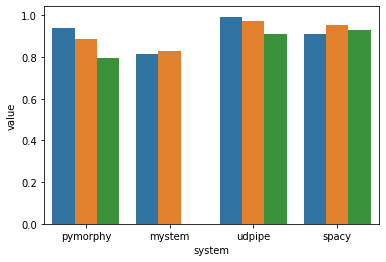

In [75]:
data = [['pymorphy', 'lemma', 0.939], ['pymorphy', 'pos', 0.887], ['pymorphy', 'tags', 0.793],
        ['mystem', 'lemma', 0.812],   ['mystem', 'pos', 0.828],   ['mystem', 'tags', 0], 
        ['udpipe', 'lemma', 0.993],   ['udpipe', 'pos', 0.972],   ['udpipe', 'tags', 0.909],
        ['spacy', 'lemma', 0.911],    ['spacy', 'pos', 0.951],    ['spacy', 'tags', 0.927]]

data_pd = pd.DataFrame(data, 
                       columns=['system', 'feature', 'value'], 
                      )

ax = sns.barplot(data=data_pd, x='system', y='value', hue='feature')
ax.get_legend().remove()

Всё! Можно подавать статью на конференцию! Только очень маленькую и совсем не продвинутую.